In [1]:
import re
import os
import math
import json
from typing import (
    List,
    Union, 
    Sequence,
    Callable
)

import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from IPython.core.display import HTML
from IPython.display import display

import spacy
from spacy import displacy
from spacy.tokens import Doc
from spacy.language import Language
from spacy_langdetect import LanguageDetector

%matplotlib inline
# %config InlineBackend.figure_format = 'svg'

# Arial for mpl plots
mpl.rcParams['font.family'] = 'Arial'

In [2]:
MODELS = { 
    'EL': spacy.util.get_lang_class('el')(),
    'DE': spacy.util.get_lang_class('de')(),
}

COLORS = {
    'de': '#a52040',
    'el': '#404080',
    'stern_yellow': '#c3c31d',
    'stern_blue': '#0b3f7e',
    'stern_purple': '#7c7cf8',
    'stern_darkbrown': '#370306',
    'darkgreen': '#006400',
    'orange': '#f4a460',
    'green': '#90ee90',
    'blue': '#add8e6',
    'purple': '#800080',
    'err': '#b4b446',
    'Gold': "#FFD700",
    'Light Green': "#90EE90",
    'Light Salmon': "#FFA07A",
    'Pale Turquoise': "#AFEEEE",
    'Light Coral': "#F08080",
    'Light Blue': "#ADD8E6",
    'Light Pink': "#FFB6C1",
    'Moccasin': "#FFE4B5",
    'Powder Blue': "#B0E0E6",
    'Light Grey': "#D3D3D3",
    'Lavender': "#E6E6FA",
    'Navajo White': "#FFDEAD",
    'Wheat': "#F5DEB3",
    'Lemon Chiffon': "#FFFACD",
    'Dark Khaki': "#BDB76B",
    'Light Slate Blue': "#8787df",
    'Light Cyan': "#E0FFFF",
}

MORPH_LOC = {
    'POS'        : 'Μέρη του λόγου',
    'Case'       : 'Πτώσεις',
    'Gender'     : 'Γένος',
    'Number'     : 'Αριθμός',
    'Person'     : 'Πρόσωπο',
    'Tense'      : 'Χρόνος',
    'VerbForm'   : 'Μορφή ρήματος',
    'Mood'       : 'Ρήμα',
    'Voice'      : 'Φωνή',
    'Definite'   : 'Οριστικότητα',
    'Degree'     : 'Βαθμίδα',
    'Poss'       : 'Κτητικότητα',
    'NumType'    : 'Τύπος αριθμού',
    'PronType'   : 'Τύπος αντωνυμίας',
    'AdpType'    : 'Τύπος προθέσης',
    'AdvType'    : 'Τύπος επιρρήματος',
    'VerbType'   : 'Τύπος ρήματος',
    'Aspect'     : 'Ποιόν',
    'Subcat'     : 'Υποκατηγορία',
    'Foreign'    : 'Ξενική λέξη',
    'Typo'       : 'Ορθογραφικό λάθος',
    'SpaceAfter' : 'Κενό μετά',
    'PunctType'  : 'Τύπος στίξης',
    'PunctSide'  : 'Πλευρά στίξης',
    'Hyph'       : 'Παύλα',
    'NumForm'    : 'Μορφή αριθμού',
    # Parts of speech
    'ADJ'        : 'Επίθετο',
    'ADP'        : 'Πρόθεση',
    'ADV'        : 'Επίρρημα',
    'AUX'        : 'Βοηθητικό ρήμα',
    'CONJ'       : 'Σύνδεσμος',
    'CCONJ'      : 'Σύνδεσμος',
    'SCONJ'      : 'Σύνδεσμος',
    'DET'        : 'Άρθρο',
    'INTJ'       : 'Επιφώνημα',
    'NOUN'       : 'Ουσιαστικό',
    'NUM'        : 'Αριθμητικό',
    'PART'       : 'Μόριο',
    'PRON'       : 'Αντωνυμία',
    'PROPN'      : 'Ονοματικό',
    'PUNCT'      : 'Στίξη',
    'SYM'        : 'Σύμβολο',
    'VERB'       : 'Ρήμα',
    'X'          : 'Άγνωστο',
    'SPACE'      : 'Κενό',
    'PUNCT'      : 'Στίξη',
    # Morphological features
    'Nom'        : 'Ονομαστική',
    'Gen'        : 'Γενική',
    'Dat'        : 'Δοτική',
    'Acc'        : 'Αιτιατική',
    'Voc'        : 'Κλητική',
    'Def'        : 'Οριστικό',
    'Ind'        : 'Αόριστο',
    'Masc'       : 'Αρσενικό',
    'Fem'        : 'Θηλυκό',
    'Neut'       : 'Ουδέτερο',
    'Sing'       : 'Ενικός',
    'Plur'       : 'Πληθυντικός',
    'Art'        : 'Άρθρο',
    'Dem'        : 'Δεικτικό',
    'Emp'        : 'Εμφατικό',
    'Int'        : 'Ερωτηματικό',
    'Neg'        : 'Αρνητικό',
    'Prs'        : 'Προσωπικό',
    'Rel'        : 'Αναφορικό',
    'Fin'        : 'Κλιτός τύπος',
    'Ger'        : 'Γερούνδιο',
    'Inf'        : 'Απαρέμφατο',
    'Part'       : 'Μετοχή',
    'Act'        : 'Ενεργητική',
    'Pass'       : 'Παθητική',
    'Cmp'        : 'Συγκριτκός',
    'Pos'        : 'Θετικός',
    'Sup'        : 'Υπερθετικός',
    'Past'       : 'Παρελθοντικός',
    'Pres'       : 'Ενεστωτικός',
    'Perf'       : 'Συντελεσμένος',
    'Card'       : 'Απόλυτο',
    'Mult'       : 'Πολλαπλασιαστικά',
    'Ord'        : 'Τακτικό',
}

# http://universaldependencies.org/u/pos/
# extracted from https://github.com/explosion/spaCy/blob/57a230c6e4844d368d4d12b09993877fc9e50946/spacy/glossary.py#L23
UPOS_TAGS = {
    'ADJ': 'adjective',
    'ADP': 'adposition',
    'ADV': 'adverb',
    'AUX': 'auxiliary',
    'CONJ': 'conjunction',
    'CCONJ': 'coordinating conjunction',
    'DET': 'determiner',
    'INTJ': 'interjection',
    'NOUN': 'noun',
    'NUM': 'numeral',
    'PART': 'particle',
    'PRON': 'pronoun',
    'PROPN': 'proper noun',
    'PUNCT': 'punctuation',
    'SCONJ': 'subordinating conjunction',
    'SYM': 'symbol',
    'VERB': 'verb',
    'X': 'other',
    'EOL': 'end of line',
    'SPACE': 'space',
}

# UPOS_COLORS = dict(zip(UPOS_TAGS.keys(), COLORS.values()))

UPOS_COLORS_light = {
    'ADJ': '#FFB74D',       # Light Orange
    'ADP': '#FFCC80',       # Light Amber
    'ADV': '#CE93D8',       # Light Purple
    'AUX': '#F06292',       # Light Pink
    'CONJ': '#9FA8DA',      # Light Indigo
    'CCONJ': '#9FA8DA',     # Light Indigo
    'DET': '#80DEEA',       # Light Cyan
    'INTJ': '#F06292',      # Light Pink
    'NOUN': '#FFD54F',      # Light Yellow
    'NUM': '#C5E1A5',       # Light Green
    'PART': '#A5D6A7',      # Light Greenish
    'PRON': '#A5D6A7',      # Light Greenish
    'PROPN': '#B39DDB',     # Light Purple
    'PUNCT': '#BCAAA4',     # Light Brown
    'SCONJ': '#9FA8DA',     # Light Indigo
    'SYM': '#BCAAA4',       # Light Brown
    'VERB': '#FFB74D',      # Light Orange
    'X': '#E0E0E0',         # Light Gray
    'EOL': '#E0E0E0',       # Light Gray
    'SPACE': '#E0E0E0',     # Light Gray
}

UPOS_COLORS = {
    # 'ADJ': '#FF5722',       # Deep Orange
    # 'ADP': '#FF9800',       # Orange
    # 'ADV': '#9C27B0',       # Purple
    # 'AUX': '#E91E63',       # Pink
    # 'CONJ': '#3F51B5',      # Indigo
    # 'CCONJ': '#3F51B5',     # Indigo
    # 'DET': '#00BCD4',       # Cyan
    # 'INTJ': '#E91E63',      # Pink
    # 'NOUN': '#FFC107',      # Amber
    # 'NUM': '#8BC34A',       # Light Green
    # 'PART': '#4CAF50',      # Green
    # 'PRON': '#4CAF50',      # Green
    # 'PROPN': '#673AB7',     # Deep Purple
    # 'PUNCT': '#795548',     # Brown
    # 'SCONJ': '#3F51B5',     # Indigo
    # 'SYM': '#795548',       # Brown
    # 'VERB': '#FF5722',      # Deep Orange
    # 'X': '#424242',         # Dark Gray
    # 'EOL': '#424242',       # Dark Gray
    # 'SPACE': '#424242',     # Dark Gray
    'SCONJ': '#FF7F50',     # Coral
    'CCONJ': '#FF7F50',     # Coral
    'VERB': '#8A2BE2',      # Blue Violet
    'ADV': '#32CD32',       # Lime Green
    'NUM': '#FF69B4',       # Hot Pink
    'PRON': '#FF4500',      # Orange Red
    'DET': '#1E90FF',       # Dodger Blue
    'PUNCT': '#808080',     # Gray
    'ADP': '#FF8C00',       # Dark Orange
    'ADJ': '#00CED1',       # Dark Turquoise
    'PART': '#FF1493',      # Deep Pink
    'PROPN': '#9932CC',     # Dark Orchid
    'AUX': '#4B0082',       # Indigo
    'NOUN': '#800000',      # Maroon
    'INTJ': '#00FFFF',      # Cyan
    'SYM': '#FF00FF',       # Magenta
    'X': '#808080',         # Dark Gray
    'EOL': '#808080',       # Dark Gray
    'SPACE': '#808080',     # Dark Gray
}


TAG_ENT_TEMPLATE = """
<mark style="color: #fff; background: {bg}; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em; font-family: Arial;">
    {text}
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 1ch">{label}{kb_link}</span>
</mark>
"""


def get_lang_detector(nlp, name):
    return LanguageDetector()

def vcu(df_grouped, col, *args):
    """Returns the value counts unstacked of a column of a grouped DataFrame."""
    return df_grouped[col].value_counts().unstack()

def meets_plot_criteria(
        df: pd.DataFrame,
        col: str,
        *,
        grouped: pd.DataFrame, 
        func: Callable,
        func_args: Sequence = None,
) -> bool:
    return  (
        col[0].isupper()
        # do not plot columns with only one value
        and len(df[col].value_counts()) > 1
        # do not plot columns with only one language 
        # and len(grouped[col].value_counts()) > 1
        # do not plot columns with values only in one language
        # and len(func(grouped, col, func_args)) > 1
    )

def convert_to_lang_tick(lang: str, level: int = 1) -> str:
    """Returns the language ticks for the plots."""
    level = level - 1
    lang = lang.removeprefix('(').removesuffix(')').replace("'", '')
    # lang = lang.upper()
    return lang.split(',')[level].strip()

def save_fig(
            fig: plt.Figure, 
            name: str, 
            path: str = './graphs', 
            format: str = 'svg',
    **kwargs) -> None:
    """Saves a matplotlib figure to a file in `./graphs`
    if `path` not specified."""
    if path is None:
        path = os.getcwd()
    else:
        path = os.path.join('graphs', path)
    if not os.path.exists(path):
        os.makedirs(path)
    fig.savefig(
        os.path.join(path, f'{name}.{format}'), 
        format=format, 
        bbox_inches='tight',
        **kwargs
    )

In [3]:
UPOS_COLORS

{'SCONJ': '#FF7F50',
 'CCONJ': '#FF7F50',
 'VERB': '#8A2BE2',
 'ADV': '#32CD32',
 'NUM': '#FF69B4',
 'PRON': '#FF4500',
 'DET': '#1E90FF',
 'PUNCT': '#808080',
 'ADP': '#FF8C00',
 'ADJ': '#00CED1',
 'PART': '#FF1493',
 'PROPN': '#9932CC',
 'AUX': '#4B0082',
 'NOUN': '#800000',
 'INTJ': '#00FFFF',
 'SYM': '#FF00FF',
 'X': '#808080',
 'EOL': '#808080',
 'SPACE': '#808080'}

In [4]:
class TextAnalyzer:
    """A class to analyse a text and return a quantitative analysis of the:
    - number of words/tokens
    - POS tags
    - morphological features
    - syntactic dependencies
    - named entities
    - lemmas
    - word vectors
    - similarity between words
    - similarity between sentences"""

    def __init__(self) -> None:
        self.nlp_models = {}
        self.nlp_el = spacy.load('el_core_news_lg')
        Language.factory('language_detector', func=get_lang_detector)
        self.nlp_el.add_pipe('language_detector', last=True)
        self.remove_crossrefs = True
        self.digits_to_zeros = True
        self.remove_punct = True

    def detect_language(self, text: str) -> str:
        doc = self.nlp_el(text)
        return doc._.language['language']

    def load_model(self, lang: str) -> None:
        spacy_models = {
            'el': 'el_core_news_lg',
            'de': 'de_core_news_lg',
        }
        if isinstance(lang, Language):
            lang = lang.lang
        else:
            lang = lang.lower()
        if lang in spacy_models:
            if lang not in self.nlp_models:
                self.nlp_models[lang] = spacy.load(spacy_models[lang])
            return self.nlp_models[lang]
        else:
            raise ValueError(f"No available model for language: {lang}")

    @staticmethod
    def get_lang_model(lang: str) -> Language:
        return MODELS[lang]

    def _remove_crossrefs(self, text: str) -> str:
        """Remove cross references from text.
        A cross reference is a string of the form (ΑΚ 123) or (BGB § 123)."""
        pattern = r'\((ΑΚ|AK|BGB)[\s§]*\d+\)'
        return re.sub(pattern, '', text)

    def _digits_to_zeros(self, text: str) -> str:
        """Replace all numbers with zeros (including article numbers),
        maintaining the same length of the string."""
        return re.sub(r'\d', '0', text)

    def _remove_punctuation(self, text: str) -> str:
        """Remove punctuation from text."""
        return re.sub(r'[^\w\s]', '', text)

    def preprocess(
            self, 
            text: str,
            *,
            remove_crossrefs: bool = False,
            digits_to_zeros: bool = True,
            remove_punctuation: bool = True,
    ) -> str:
        """Preprocess text by removing cross references and punctuation,
        and replacing numbers with zeros."""
        if remove_crossrefs:
            text = self._remove_crossrefs(text)
        if digits_to_zeros:
            text = self._digits_to_zeros(text)
        if remove_punctuation:
            text = self._remove_punctuation(text)
        text = re.sub(r'\s+', ' ', text)
        return text


    def word_freqs(
            self,
            text: str,
            *, 
            preprocess: bool = True,
            exclude_stopwords: bool = False, 
            lemmas: bool = False
    ) -> dict:
        """Count a dict with the number of words in a text.
        If `lemmas` is False, the number of tokens is returned, 
        otherwise the number of lemmas."""
        if preprocess:
            text = text.lower()
            text = self.preprocess(text,
                                   remove_crossrefs=self.remove_crossrefs,
                                   digits_to_zeros=self.digits_to_zeros,
                                   remove_punctuation=self.remove_punct)
        lang = self.detect_language(text)
        nlp = self.load_model(lang)
        doc = nlp(text)
        if lemmas:
            words = [token.lemma_ for token in doc]
        else:
            words = [token.text for token in doc]
        if exclude_stopwords:
            words = [word for word in words 
                     if not word in self.nlp.Defaults.stop_words]
        return pd.Series(words).value_counts(sort=False).to_dict()

    def analyze(
            self, 
            text: str, 
            *, 
            preprocess: bool = True,
            as_dataframe: bool = False
    ) -> Union[dict, pd.DataFrame]:
        if preprocess:
            text = self.preprocess(text, 
                                   remove_crossrefs=self.remove_crossrefs,
                                   digits_to_zeros=self.digits_to_zeros,
                                   remove_punctuation=self.remove_punct)
        lang = self.detect_language(text)
        nlp = self.load_model(lang)
        doc = nlp(text)
        analysis = {
            'preprocessed_text': text,
            'detected_lang': doc._.language['language'].upper(),
            'num_tokens': len(doc),
            'token_freqs': self.word_freqs(text),
            'lemma_freqs': self.word_freqs(text, lemmas=True),
            'token_lemma_diff': len(set(self.word_freqs(text).keys())) -
                                len(set(self.word_freqs(text, lemmas=True).keys())),
            'pos_tags': [tkn.pos_ for tkn in doc],
            'pos_freqs': {pos: len([tkn for tkn in doc if tkn.pos_ == pos]) 
                          for pos in set([tkn.pos_ for tkn in doc])},
            'morph_features': json.dumps(
                [{tkn.text: {'POS': tkn.pos_, **tkn.morph.to_dict()} 
                 for tkn in doc if len(tkn.morph.to_dict()) > 0}], 
                ensure_ascii=False
            ),
            'syntax_deps': [tkn.dep_ for tkn in doc],
            'named_entities': [(ent.text, ent.label_) for ent in doc.ents],
            'lemmas': [tkn.lemma_ for tkn in doc],
            'word_vectors': [tkn.vector for tkn in doc],
            'avg_vector': np.mean([tkn.vector for tkn in doc], axis=0)
        }
        if as_dataframe:
            return pd.DataFrame(analysis, encoding='utf-8')
        return analysis

    class CustomTagger:
        def __init__(self, nlp):
            self.nlp = nlp

        def __call__(self, doc: Doc) -> Doc:
            for token in doc:
                token.tag_ = token.pos_
            return doc

    if not Language.has_factory("custom_tagger"):
        @Language.factory("custom_tagger")
        def create_custom_tagger(nlp, name):
            return TextAnalyzer.CustomTagger(nlp)

    def get_pos_tags(self, text: str, model: str) -> list:
        nlp = self.load_model(model)

        if 'custom_tagger' not in nlp.pipe_names:
            nlp.add_pipe('custom_tagger', before='morphologizer')

        doc = nlp(text)

        # get the POS tags directly from the Doc object
        pos_tags = [token.pos_ for token in doc]
        pos_tags = sorted(list(set(pos_tags)))

        return pos_tags

class ComparisonVisualizer:
    def __init__(self, dataframe: pd.DataFrame, analyzer: TextAnalyzer) -> None:
        self.dataframe = dataframe
        self.analyzer = analyzer

    def compare_texts(
            self, 
            *, 
            group_by: str = None
    ) -> None:
        grouped_df = self.dataframe.groupby(group_by)

        for _, group in grouped_df:
            data = []
            for _, row in group.iterrows():
                text = row['sentence']
                analysis = self.analyzer.analyze(text, preprocess=True)
                data.append(analysis)

            df_analysis = pd.DataFrame(data)
            self.visualize_analysis(df_analysis)

    def visualize_analysis(self, df_analysis: pd.DataFrame) -> None:
        cols_with_numeric_values = df_analysis.select_dtypes(np.number).columns
        print(cols_with_numeric_values)
        df_analysis[cols_with_numeric_values].plot.bar(rot=0)
        plt.show()

    def compare_sentence_similarity(
            self, 
            df_analysis: pd.DataFrame
    ) -> np.ndarray:
        sentence_vectors = np.stack(df_analysis['avg_vector'].values)
        similarities = cosine_similarity(sentence_vectors)
        return similarities

    def sentence_similarity_heatmap(
            self, 
            df_analysis, 
            *, 
            group_by: Union[str, list] = None,
            save: bool = False,
            savedir: str = None
    ) -> None:
        """Plot a heatmap of sentence similarities, grouped by language 
        along with the sentences."""
        similarities = self.compare_sentence_similarity(df_analysis)
        ax_title = "Ομοιότητα συνημιτόνου ανά πρόταση"
        if group_by is None:
            id = df_analysis['id'].iloc[0]
            fig, ax = plt.subplots()
            ax.set_title(ax_title)
            ax.set_xticks(np.arange(len(df_analysis)))
            ax.set_yticks(np.arange(len(df_analysis)))
        else:
            grouped_df = df_analysis.groupby(group_by)
            for _, group in grouped_df:
                # lang = group['lang'].iloc[0]
                id = group['id'].iloc[0]
                sentences = group['sentence'].values
                print(len(sentences))
                fig, ax = plt.subplots()
                ax.set_xticks(np.arange(len(sentences)))
                ax.set_yticks(np.arange(len(sentences)))
                ax.set_title(f'{ax_title}')
        ax.set_xticklabels(df_analysis['translator'], rotation=45, ha="right")
        ax.set_yticklabels(df_analysis['translator'])
        fig.suptitle(f'Παράδειγμα {id}')
        im = ax.imshow(similarities, cmap='Blues', interpolation='nearest', vmin=0, vmax=1)
        plt.colorbar(im)
        # plt.clim(0, 1)
        # display the values over 0.5 inside the heatmap
        for i, _ in enumerate(similarities):
            for j, _ in enumerate(similarities):
                if similarities[i, j] >= 0.5:
                    text = ax.text(j, i, round(similarities[i, j], 2),
                                   ha='center', va='center', color='white')
        if save:
            save_fig(fig, f'example_{id}', 
                     path='translations/similarity' if savedir is None else savedir)
        plt.show()

    def _prepare_morphology_data(
            self, 
            df_analysis: pd.DataFrame,
            *,
            meta_columns: list = ['id', 'lang', 'version', 'translator'],
            morph_column: str = 'morph_features'
    ) -> pd.DataFrame:
        present_meta_columns = [col for col in meta_columns 
                                if col in df_analysis.columns]
        df = df_analysis[present_meta_columns + [morph_column]].copy()
        df['morph_features'] = df['morph_features'].apply(json.loads)
        df = df.explode('morph_features')
        df = pd.concat([df.drop(['morph_features'], axis=1), 
                        df['morph_features'].apply(pd.Series, dtype='object')
                        .stack().reset_index(level=1, name='morphology')],
                       axis=1)
        df = pd.concat([df.drop(['morphology'], axis=1), 
                        df['morphology'].apply(pd.Series, dtype='object')], 
                       axis=1)
        # df = df.rename(columns={'POS': 'pos'})
        return df


    def visualize_morphology(
            self, 
            df_analysis: pd.DataFrame,
            *, 
            long_xlabels: bool = False,
            colors: Sequence = None, 
            group_by: Union[str, list] = None,
            save: bool = False,
            savedir: str = None,
    ) -> None:
        if colors is None:
            colors = mpl.colormaps['tab20'] # old version: plt.cm.tab20

        df = self._prepare_morphology_data(df_analysis)

        df_grouped = df.groupby(group_by)
        display(df_grouped.head(3))
        cols = [col for col in df.columns if col[0].isupper()]
        print(cols, end='\n\n')

        num_plots = len(cols)
        n_rows = math.ceil(num_plots / 2)
        n_cols = 2 if num_plots > 1 else 1

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 5 * n_rows))
        fig.suptitle(f"Παράδειγμα {df['id'].iloc[0]}")
        translators = df['translator'].unique()

        for i, col in enumerate(cols):
            ax = axes[i // n_cols, i % n_cols]
            ax.set_title(MORPH_LOC.get(col, col))
            # display(df_grouped.value_counts().unstack())
            (df_grouped
                .apply(lambda x: x[col].value_counts())
                .unstack()
                # .value_counts()
                # .unstack()
                .plot(
                    kind='bar', 
                    ax=ax, 
                    color=[list(COLORS.values())[i] 
                           for i, _ in enumerate(df_grouped.groups)],
                    stacked=True, 
                    # sharey=True, 
                    rot=0, 
                    zorder=3
                )
            )
            # langs = [convert_to_lang_tick(str(idx))
            #          for idx in vcu(df_grouped, col).index]
            if long_xlabels:
                try:
                    xlabels = ax.set_xticklabels(translators, fontsize=8)
                except ValueError:
                    xlabels = ax.get_xticklabels()
                for i, label in enumerate(xlabels):
                    print(label)
                    label.set_y(label.get_position()[1] - (i % 2) * 0.075)
            else:
                ax.set_xticklabels(translators)
            # make sure y ticks are rounded to the nearest integer,
            # without showing zero
            ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
            ax.set_xlabel(None)
            ax.set_ylabel('Απόλυτη συχνότητα')
            # translate the legend labels to greek
            handles, labels = ax.get_legend_handles_labels()
            ax.legend(
                handles, 
                [MORPH_LOC.get(label, label) for label in labels],
                loc='lower center'
            ).set_title(None)
            ax.grid(axis='both', color='lightgray', zorder=0)

        # check if the number of plots is odd and remove the last subplot
        if num_plots % 2 != 0:
            fig.delaxes(axes[-1, -1])

        if save:
            path = 'translations/morphology' if savedir is None else savedir
            path += f'/{group_by}' if group_by is not None else ''
            save_fig(fig, f"example_{df['id'].iloc[0]}", path=path)
        plt.show()

    def visualize_pos(self, text: str, model: str, *, colors: dict) -> None:
        nlp = self.analyzer.load_model(model)

        if 'custom_tagger' not in nlp.pipe_names:
            nlp.add_pipe('custom_tagger', before='morphologizer')

        doc = nlp(text)

        pos_tags = self.analyzer.get_pos_tags(text, model)

        ents = []
        for token in doc:
            if token.pos_ in pos_tags:
                ents.append({'start': token.idx,
                             'end': token.idx + len(token),
                             'label': token.pos_})

        doc = {'text': text, 'ents': ents}

        options = {'ents': pos_tags, 'colors': colors,
                   'template': TAG_ENT_TEMPLATE}

        html = displacy.render(doc,
                               style='ent',
                               options=options,
                               manual=True,
                               jupyter=True,
                               )
        display(HTML(html))

In [5]:
df = pd.read_csv('translations.csv', encoding='utf-8')
# set appropriate dtypes
df = df.astype({'id': 'int32', 'lang': 'category'})

with pd.option_context('display.max_colwidth', None):
    display(df)

id lang                   version  \
0    1   EL                ελλΑΚ-1940   
1    1   DE          ελλΑΚ-1951-Γώγος   
2    1   DE          ελλΑΚ-1940-DeepL   
3    1   DE         ελλΑΚ-1940-Google   
4    1   DE      Τεκμηριωτική-ChatGPT   
5    1   DE  Ομοιολειτουργική-ChatGPT   
6    2   EL                ελλΑΚ-1940   
7    2   DE          ελλΑΚ-1951-Γώγος   
8    2   DE          ελλΑΚ-1940-DeepL   
9    2   DE         ελλΑΚ-1940-Google   
10   2   DE      Τεκμηριωτική-ChatGPT   
11   2   DE  Ομοιολειτουργική-ChatGPT   
12   3   EL                ελλΑΚ-1940   
13   3   DE          ελλΑΚ-1951-Γώγος   
14   3   DE          ελλΑΚ-1940-DeepL   
15   3   DE         ελλΑΚ-1940-Google   
16   3   DE      Τεκμηριωτική-ChatGPT   
17   3   DE  Ομοιολειτουργική-ChatGPT   
18   4   EL                ελλΑΚ-1940   
19   4   DE          ελλΑΚ-1951-Γώγος   
20   4   DE          ελλΑΚ-1940-DeepL   
21   4   DE         ελλΑΚ-1940-Google   
22   4   DE      Τεκμηριωτική-ChatGPT   
23   4   DE  Ομοιολειτουργική-ChatGPT   
24   5   EL                ελλΑΚ-1940   
25   5   DE          ελλΑΚ-1951-Γώγος   
26   5   DE          ελλΑΚ-1940-DeepL   
27   5   DE         ελλΑΚ-1940-Google   
28   5   DE      Τεκμηριωτική-ChatGPT   
29   5   DE  Ομοιολειτουργική-ChatGPT   

                                                                                                                                                                                  sentence  
0                                                                                 Κατὰ τὴν ἑρμηνείαν τῆς δηλώσεως βουλήσεως ἀναζητεῖται ἤ ἀληθὴς βούλησις ἄνευ προσηλώσεως εἱς τὰς λέξεις.  
1                                                                               Bei der Auslegung einer Willenserklärung wird der wirkliche Wille erforscht, ohne an den Worten zu haften.  
2                                                                                      Bei der Auslegung einer Willenserklärung wird der wahre Wille ohne Bindung an den Wortlaut gesucht.  
3                                                                                     Bei der Auslegung der Willenserklärung sucht man nach einem wahren Willen ohne Bindung an die Worte.  
4                                                                        Bei der Auslegung der Willenserklärung wird die tatsächliche Absicht ohne strikte Bindung an die Worte ermittelt.  
5                                                                                         Bei der Auslegung der Willenserklärung wird die wahre Absicht ohne Bindung an die Worte gesucht.  
6                                         Διὰ τὰς προθεσμίας τὰς καθοριζομένας διὰ νόμου, δικαστικῆς αποφάσεως ἤ δικαιοπραξίας ἰσχύουσιν αἱ ἑρμηνευτικαὶ διατάξεις τῶν ἄρθρων 241 ἔως 246.  
7                             Für die Fristen, welche durch Gesetz, gerichtliche Entscheidung oder Rechtsgeschäft bestimmt werden, gelten die Auslegungsvorschriften der Art. 241 bis 246.  
8                                     Für die durch Gesetz, gerichtliche Entscheidung oder Rechtsgeschäft festgesetzten Fristen gelten die Auslegungsbestimmungen der Artikel 241 bis 246.  
9                                                       Die Auslegungsbestimmungen der Artikel 241 bis 246 gelten für die durch Gesetz, Gerichtsentscheidung oder Klage gesetzten Fristen.  
10                                    Die interpretativen Bestimmungen der Artikel 241 bis 246 gelten für die durch Gesetz, Gerichtsentscheidung oder Rechtshandlung festgelegten Fristen.  
11                                       Für die durch Gesetz, Gerichtsentscheidung oder rechtliche Handlung festgelegten Fristen gelten die Auslegungsregelungen der Artikel 241 bis 246.  
12                              Ἡ μετὰ τὴν ἐπιχείρησιν τῆς δικαιπραξὶας παρεχομένη συγκατάθεσις (ἔγκρισις), ἐφ’ ὄσον δὲν ὁρίζεται τὸ ἐναντὶον, ἀνατρέχει εἰς τον χρόνον τῆς δικαιοπραξίας.  
13  Die nach der Vorname des Rechtsgeschäfts erteilte Zustimmung (Genehmigugng) wirkt,

In [6]:
df_el = df[df['lang'] == 'EL'] # original Greek texts
df_de = df[df['lang'] == 'DE'] # German translations

len(df_el), len(df_de)

(5, 25)

In [7]:
df = df_de.reset_index(drop=True)
df = df.assign(translator=df['version'].apply(lambda x: x.rsplit('-')[-1] if not 'GPT' in x else x))
df['translator'] = df['translator'].apply(lambda x: 'ChatGPT (Τεκ.)' if 'Τεκμηριωτική-ChatGPT' in x else 'ChatGPT (Ομ.)' 
                                                                     if 'Ομοιολειτουργική-ChatGPT' in x else x)
df['version'] = df['version'].apply(lambda x: '-'.join(x.rsplit('-')[:-1]))
df = df[['id', 'version', 'translator', 'sentence']]

with pd.option_context('display.max_colwidth', None):
    display(df)

id           version      translator  \
0    1        ελλΑΚ-1951           Γώγος   
1    1        ελλΑΚ-1940           DeepL   
2    1        ελλΑΚ-1940          Google   
3    1      Τεκμηριωτική  ChatGPT (Τεκ.)   
4    1  Ομοιολειτουργική   ChatGPT (Ομ.)   
5    2        ελλΑΚ-1951           Γώγος   
6    2        ελλΑΚ-1940           DeepL   
7    2        ελλΑΚ-1940          Google   
8    2      Τεκμηριωτική  ChatGPT (Τεκ.)   
9    2  Ομοιολειτουργική   ChatGPT (Ομ.)   
10   3        ελλΑΚ-1951           Γώγος   
11   3        ελλΑΚ-1940           DeepL   
12   3        ελλΑΚ-1940          Google   
13   3      Τεκμηριωτική  ChatGPT (Τεκ.)   
14   3  Ομοιολειτουργική   ChatGPT (Ομ.)   
15   4        ελλΑΚ-1951           Γώγος   
16   4        ελλΑΚ-1940           DeepL   
17   4        ελλΑΚ-1940          Google   
18   4      Τεκμηριωτική  ChatGPT (Τεκ.)   
19   4  Ομοιολειτουργική   ChatGPT (Ομ.)   
20   5        ελλΑΚ-1951           Γώγος   
21   5        ελλΑΚ-1940           DeepL   
22   5        ελλΑΚ-1940          Google   
23   5      Τεκμηριωτική  ChatGPT (Τεκ.)   
24   5  Ομοιολειτουργική   ChatGPT (Ομ.)   

                                                                                                                                                                                  sentence  
0                                                                               Bei der Auslegung einer Willenserklärung wird der wirkliche Wille erforscht, ohne an den Worten zu haften.  
1                                                                                      Bei der Auslegung einer Willenserklärung wird der wahre Wille ohne Bindung an den Wortlaut gesucht.  
2                                                                                     Bei der Auslegung der Willenserklärung sucht man nach einem wahren Willen ohne Bindung an die Worte.  
3                                                                        Bei der Auslegung der Willenserklärung wird die tatsächliche Absicht ohne strikte Bindung an die Worte ermittelt.  
4                                                                                         Bei der Auslegung der Willenserklärung wird die wahre Absicht ohne Bindung an die Worte gesucht.  
5                             Für die Fristen, welche durch Gesetz, gerichtliche Entscheidung oder Rechtsgeschäft bestimmt werden, gelten die Auslegungsvorschriften der Art. 241 bis 246.  
6                                     Für die durch Gesetz, gerichtliche Entscheidung oder Rechtsgeschäft festgesetzten Fristen gelten die Auslegungsbestimmungen der Artikel 241 bis 246.  
7                                                       Die Auslegungsbestimmungen der Artikel 241 bis 246 gelten für die durch Gesetz, Gerichtsentscheidung oder Klage gesetzten Fristen.  
8                                     Die interpretativen Bestimmungen der Artikel 241 bis 246 gelten für die durch Gesetz, Gerichtsentscheidung oder Rechtshandlung festgelegten Fristen.  
9                                        Für die durch Gesetz, Gerichtsentscheidung oder rechtliche Handlung festgelegten Fristen gelten die Auslegungsregelungen der Artikel 241 bis 246.  
10  Die nach der Vorname des Rechtsgeschäfts erteilte Zustimmung (Genehmigugng) wirkt, sofern nicht das Gegenteil bestimmt ist, auf den Zeitpunkt der Vornahme des Rechtsgeschäfts zurück.  
11                Die Zustimmung (Genehmigung), die nach der Ausübung der Konzession erteilt wird, gilt, wenn das Gegenteil nicht angegeben ist, als zum Zeitpunkt der Konzession erteilt.  
12                                Die nach der Rechtshandlung erteilte Einwilligung (Genehmigung) reicht, soweit nichts anderes bestimmt ist, bis zum Zeitpunkt der Rechtshandlung zurück.  
13    Die nach der Durchführung des Rechtsverfahrens gewährte Zustimmung (Genehmigung), soweit nichts Gegenteiliges festgelegt ist, bezieht sich auf die Zeit des Rechtsverfahrens zurück.  
14              Die Zust

In [8]:
df['translator'].unique()

array(['Γώγος', 'DeepL', 'Google', 'ChatGPT (Τεκ.)', 'ChatGPT (Ομ.)'],
      dtype=object)

Index(['num_tokens', 'token_lemma_diff'], dtype='object')


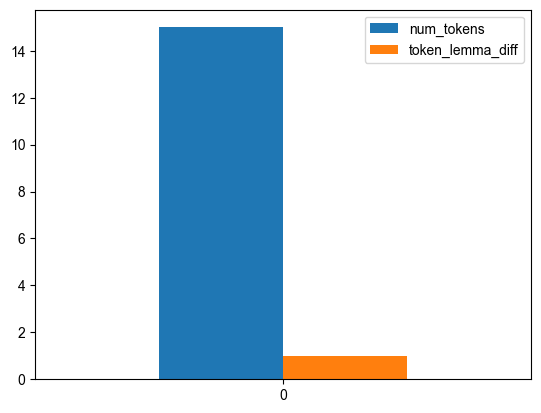

Index(['num_tokens', 'token_lemma_diff'], dtype='object')


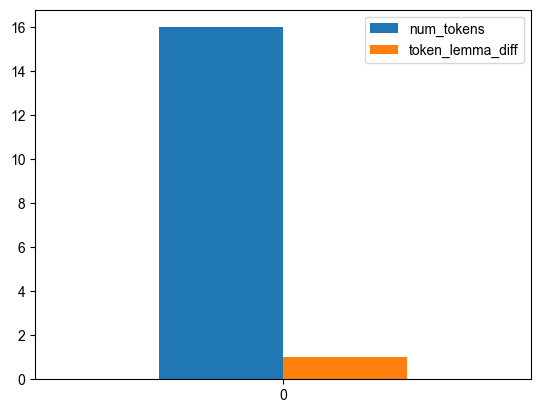

Index(['num_tokens', 'token_lemma_diff'], dtype='object')


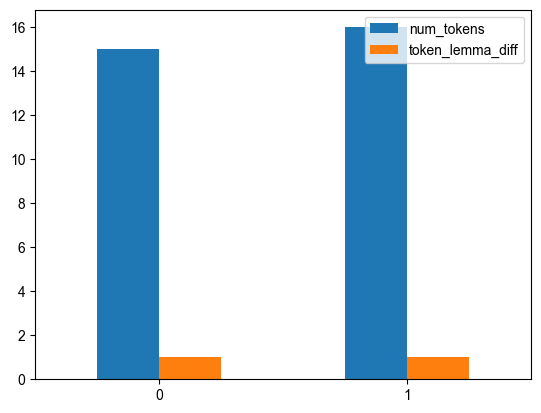

Index(['num_tokens', 'token_lemma_diff'], dtype='object')


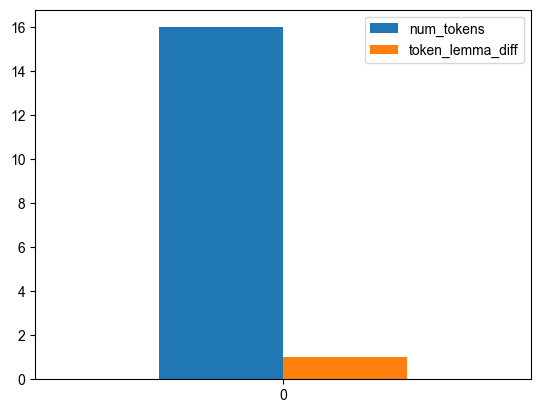

Index(['num_tokens', 'token_lemma_diff'], dtype='object')


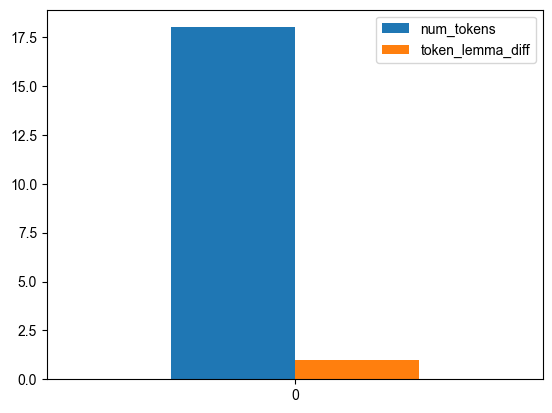

Index(['num_tokens', 'token_lemma_diff'], dtype='object')


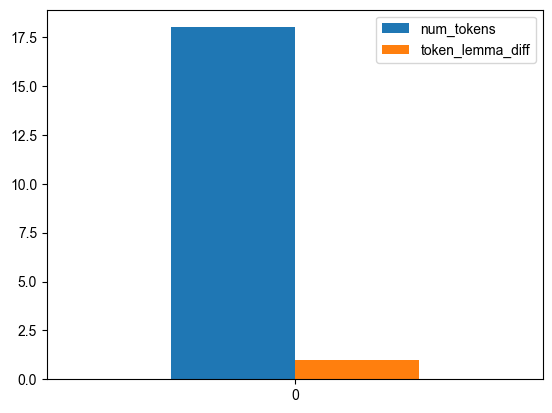

Index(['num_tokens', 'token_lemma_diff'], dtype='object')


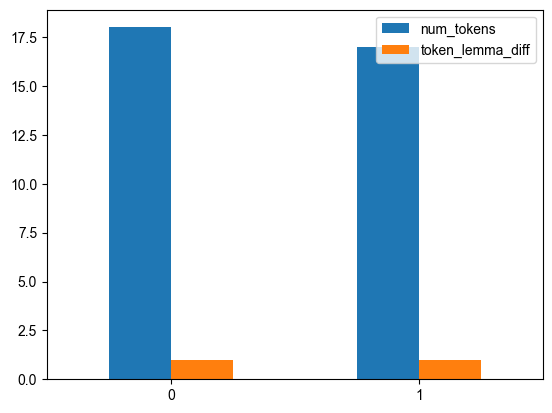

Index(['num_tokens', 'token_lemma_diff'], dtype='object')


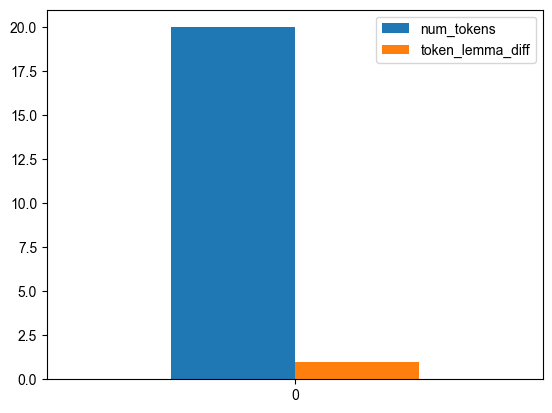

Index(['num_tokens', 'token_lemma_diff'], dtype='object')


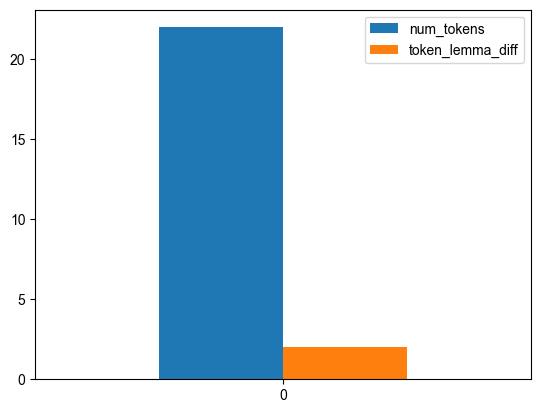

Index(['num_tokens', 'token_lemma_diff'], dtype='object')


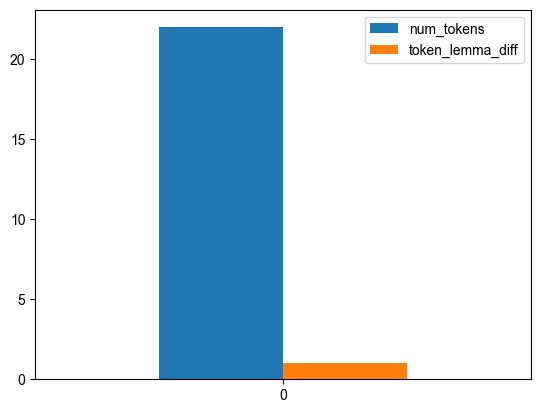

Index(['num_tokens', 'token_lemma_diff'], dtype='object')


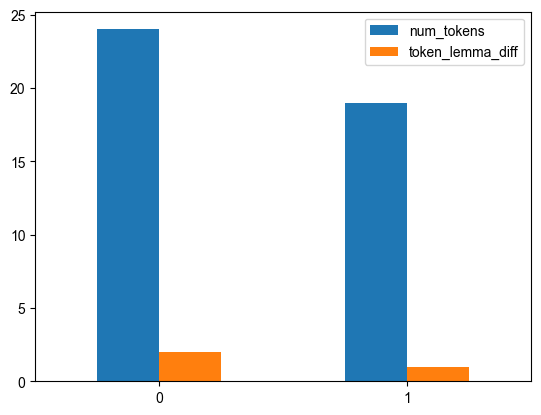

Index(['num_tokens', 'token_lemma_diff'], dtype='object')


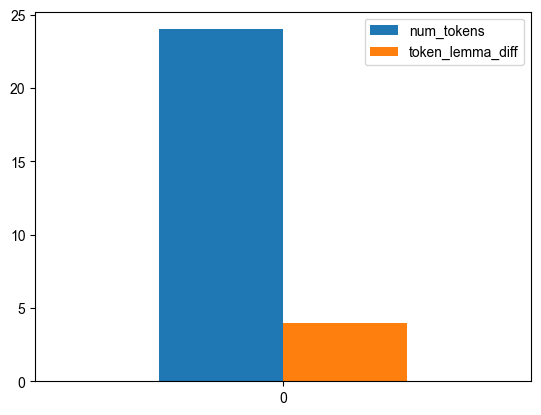

Index(['num_tokens', 'token_lemma_diff'], dtype='object')


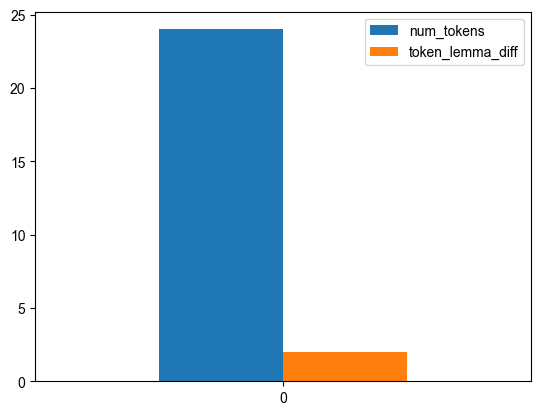

Index(['num_tokens', 'token_lemma_diff'], dtype='object')


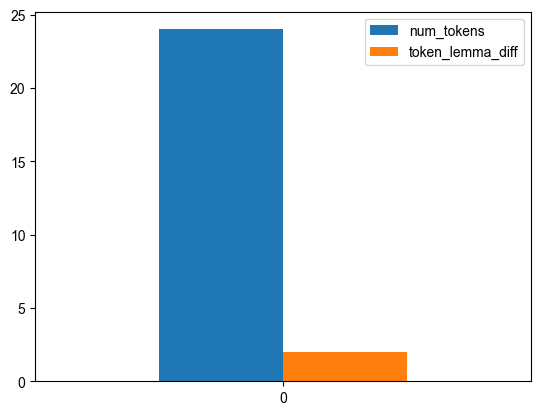

Index(['num_tokens', 'token_lemma_diff'], dtype='object')


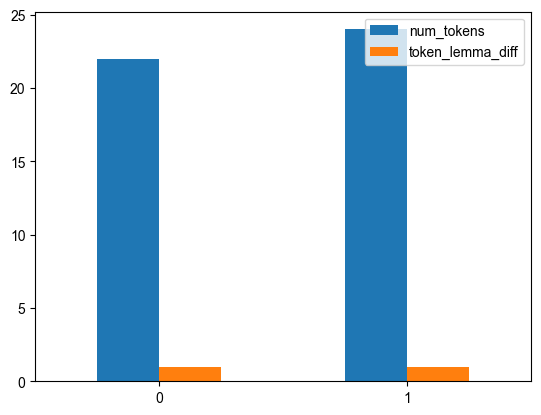

Index(['num_tokens', 'token_lemma_diff'], dtype='object')


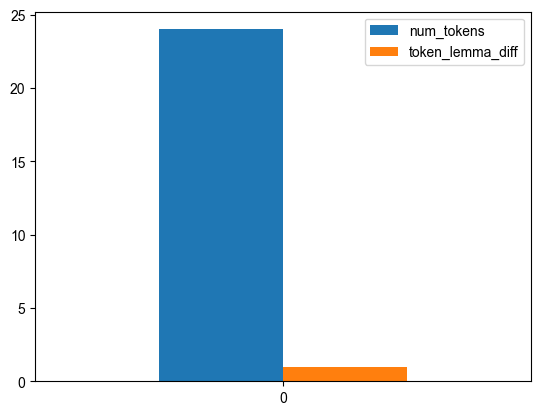

Index(['num_tokens', 'token_lemma_diff'], dtype='object')


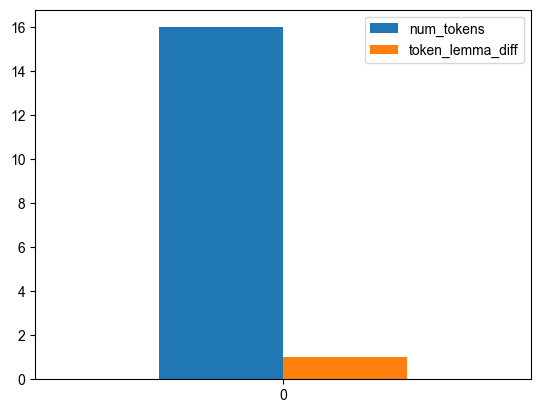

Index(['num_tokens', 'token_lemma_diff'], dtype='object')


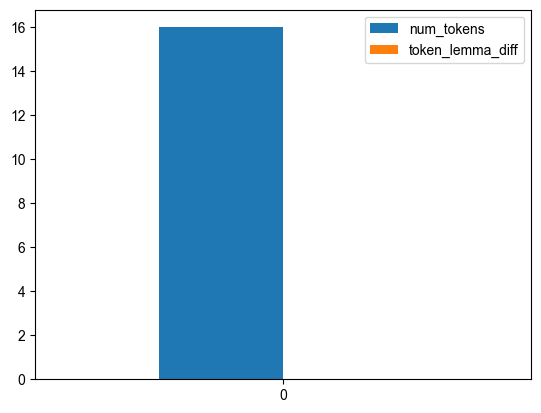

Index(['num_tokens', 'token_lemma_diff'], dtype='object')


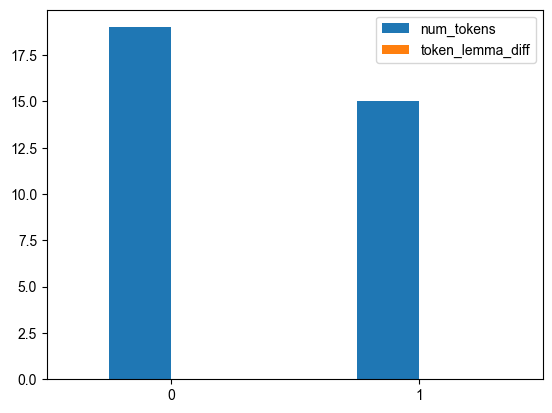

Index(['num_tokens', 'token_lemma_diff'], dtype='object')


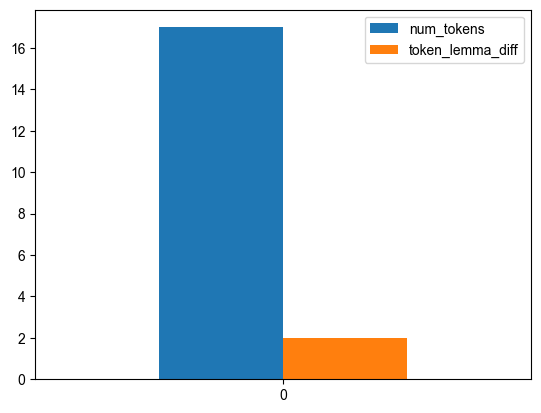

In [9]:
analyzer = TextAnalyzer()
visualizer = ComparisonVisualizer(df, analyzer)
visualizer.compare_texts(group_by=['id', 'version'])

In [10]:
# Perform analysis and store the results in a DataFrame
data = []
for _, row in df.iterrows():
    analysis = analyzer.analyze(row['sentence'])
    data.append(analysis)
    # dicts = []
    # lists = []
    # for col, val in analysis.items():
    #     if isinstance(val, list):
    #         lists.append(val)
    #     elif isinstance(val, dict):
    #         dicts.append(val)
    # lists_lengths = [len(l) for l in lists if l]
    # # calculate the length of each dictionary by adding its values
    # dicts_lengths = [sum(v for v in d.values()) for d in dicts if d]
    # display(pd.DataFrame(dicts))
    # display(pd.DataFrame(lists))
# check if all lists have the same length
# print(all(x == lists_lengths[0] for x in lists_lengths))

df_analysis = pd.DataFrame(data)
analysis_df = pd.concat([df, df_analysis], axis=1)
analysis_df.to_csv('translations_analysis.csv', encoding='utf-8', index=False)

def highlight_mismatches(
        df: pd.DataFrame, 
        color: str = 'red', 
        pairs: list[tuple] = None,
        regex: str = None,
) -> pd.DataFrame:
    """Highlight the cells in `df` where the values in `pairs` are
    different. If `pairs` is not set, compare all columns that match
    `regex` (e.g. `regex='^pos_'` will compare all columns that start with
    `pos_`)."""
    if pairs is None and regex is None:
        raise ValueError("Either `pairs` or `regex` must be set.")
    elif pairs is not None and regex is not None:
        raise ValueError("Only one of `pairs` or `regex` can be set.")

    attr = f'background-color: {color}'
    result = pd.DataFrame('', index=df.index, columns=df.columns)

    if regex:
        import itertools
        matching_cols = [col for col in df.columns if re.match(regex, col)]
        permutations = itertools.permutations(matching_cols, 2)
        pairs = [(col1, col2) for col1, col2 in permutations 
                 if col1 != col2]
        pairs = set(tuple(sorted(pair)) for pair in pairs) # unique pairs

    for col1, col2 in pairs:
        print(f"Comparing `{col1}` and `{col2}`...")
        is_diff = df[col1] != df[col2]
        result[col1] = np.where(is_diff, attr, '')
        result[col2] = np.where(is_diff, attr, '')
        # keep track of the index of the rows that have different values
        diff_rows = df[is_diff].index
        suffix = 's' if len(diff_rows) > 1 else ''
        print(f"Found different values in {len(diff_rows)} row{suffix}:")
        for i in diff_rows:
            print(f"- Row {i}: {df.loc[i, col1]} != {df.loc[i, col2]}",
                  end='\n\n' if i != diff_rows[-1] else '\n')
    print("-" * 50)
    print(f"Found {is_diff.sum()} different value{suffix} in total.")

    return result

In [11]:
styled = (analysis_df
    .drop(['word_vectors', 'avg_vector'], axis=1)
    .style.apply(
            highlight_mismatches, 
            regex='^token_lemma',
            axis=None
        )
    )

In [12]:
with pd.option_context('display.max_colwidth', None):
    display(pd.Series(analysis_df.loc[0, :]).to_frame())

0
id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

In [13]:
# get the dict inside of the pos_freqs column and convert the values into a DataFrame with the keys as columns
pos_freqs = pd.DataFrame(
    pd.concat(
        [analysis_df[['id', 'version', 'translator', 'preprocessed_text']], 
         analysis_df['pos_freqs'].apply(pd.Series, dtype='object').fillna(0).astype(int)], 
    axis=1)
)
cols_to_style = [col for col in pos_freqs.columns if col.isupper()]

def is_light_color(hex_color):
    r, g, b = mpl.colors.to_rgb(hex_color)
    # scaling the rgb components to the range [0, 255]
    r *= 255
    g *= 255
    b *= 255
    brightness = (r * 299 + g * 587 + b * 114) / 1000
    return brightness > 127

def color_columns(val, df, colors, hide_zeros=True):
    to_color = []
    for col in df.columns:
        if col.upper() in colors.keys():
            color = colors[col.upper()]
            style = f'background-color: {color}; '
            if is_light_color(color):
                style += 'color: #000;'
            else:
                style += 'color: #fff;'
            if hide_zeros and val[col] == 0:
                style += f'color: {color};'
            to_color.append(style)
        else:
            to_color.append('')
    return to_color

pos_freqs = pos_freqs.style.apply(color_columns, df=pos_freqs, colors=UPOS_COLORS, axis=1)
pos_df = pd.read_html(pos_freqs.to_html(), index_col=0)[0]
pos_freqs

In [14]:
lemma_freqs = pd.DataFrame(analysis_df['lemma_freqs'].apply(pd.Series, dtype='object'))
lemma_df = pd.concat([analysis_df[['id', 'version']], lemma_freqs], axis=1)
lemma_df = lemma_freqs.fillna(0)

In [15]:
token_freqs = pd.DataFrame(analysis_df['token_freqs'].apply(pd.Series, dtype='object').fillna(0).astype(int))
token_freqs

bei  der  auslegung  einer  willenserklärung  wird  wirkliche  wille  \
0     1    2          1      1                 1     1          1      1   
1     1    2          1      1                 1     1          0      1   
2     1    2          1      0                 1     0          0      0   
3     1    2          1      0                 1     1          0      0   
4     1    2          1      0                 1     1          0      0   
5     0    1          0      0                 0     0          0      0   
6     0    1          0      0                 0     0          0      0   
7     0    1          0      0                 0     0          0      0   
8     0    1          0      0                 0     0          0      0   
9     0    1          0      0                 0     0          0      0   
10    0    2          0      0                 0     0          0      0   
11    0    3          0      0                 0     1          0      0   
12    0    2          0      0                 0     0          0      0   
13    0    1          0      0                 0     0          0      0   
14    0    3          0      0                 0     1          0      0   
15    0    0          0      1                 0     0          0      0   
16    0    0          0      1                 0     0          0      0   
17    0    0          0      1                 0     0          0      0   
18    0    0          0      1                 0     0          0      0   
19    0    0          0      1                 0     0          0      0   
20    0    2          0      0                 0     0          0      0   
21    0    0          0      0                 0     0          0      0   
22    0    1          0      0                 0     0          0      0   
23    0    2          0      0                 0     0          0      0   
24    0    2          0      0                 0     0          0      0   

    erforscht  ohne  ...  zumindest  verstorben  wer  erbschaftseröffnung  \
0           1     1  ...          0           0    0                    0   
1           0     1  ...          0           0    0                    0   
2           0     1  ...          0           0    0                    0   
3           0     1  ...          0           0    0                    0   
4           0     1  ...          0           0    0                    0   
5           0     0  ...          0           0    0                    0   
6           0     0  ...          0           0    0                    0   
7           0     0  ...          0           0    0                    0   
8           0     0  ...          0           0    0                    0   
9           0     0  ...          0           0    0                    0   
10          0     0  ...          0           0    0                    0   
11          0     0  ...          0           0    0                    0   
12          0     0  ...          0           0    0                    0   
13          0     0  ...          0           0    0                    0   
14          0     0  ...          0           0    0                    0   
15          0     0  ...          0           0    0                    0   
16          0     0  ...          0           0    0                    0   
17          0     0  ...          0           0    0                    0   
18          0     0  ...          0           0    0                    0   
19          0     0  ...          0           0    0                    0   
20          0     0  ...          0           0    0                    0   
21          0     0  ...          1           1    0                    0   
22          0     0  ...          1           0    1                    1   
23          0     0  ...          1           0    0                    0   
24          0     0  ...          1           0    0                    0   

    gezeugt  jemand  erb

In [16]:
# For each column, check if it contains dictionary, and if so, explode it
# in each own dataframe and use 'count' on the values column

df_ = analysis_df.copy()
df__ = pd.DataFrame()

def is_col_instance(col: pd.Series, instance: Union[str, dict, list]) -> bool:
    return col.apply(lambda x: isinstance(x, instance)).any()

for col in df_.columns:
    if is_col_instance(df_[col], str):
        df__ = pd.concat([df__, df_[col]], axis=1)
    elif is_col_instance(df_[col], dict):
        df__ = pd.concat([df__, df_[col]], axis=1)
        df__ = df__.explode(col)
        break
display(df__)

version     translator  \
0         ελλΑΚ-1951          Γώγος   
0         ελλΑΚ-1951          Γώγος   
0         ελλΑΚ-1951          Γώγος   
0         ελλΑΚ-1951          Γώγος   
0         ελλΑΚ-1951          Γώγος   
..               ...            ...   
24  Ομοιολειτουργική  ChatGPT (Ομ.)   
24  Ομοιολειτουργική  ChatGPT (Ομ.)   
24  Ομοιολειτουργική  ChatGPT (Ομ.)   
24  Ομοιολειτουργική  ChatGPT (Ομ.)   
24  Ομοιολειτουργική  ChatGPT (Ομ.)   

                                             sentence  \
0   Bei der Auslegung einer Willenserklärung wird ...   
0   Bei der Auslegung einer Willenserklärung wird ...   
0   Bei der Auslegung einer Willenserklärung wird ...   
0   Bei der Auslegung einer Willenserklärung wird ...   
0   Bei der Auslegung einer Willenserklärung wird ...   
..                                                ...   
24  Ein Erbe kann nur derjenige werden, der zum Ze...   
24  Ein Erbe kann nur derjenige werden, der zum Ze...   
24  Ein Erbe kann nur derjenige werden, der zum Ze...   
24  Ein Erbe kann nur derjenige werden, der zum Ze...   
24  Ein Erbe kann nur derjenige werden, der zum Ze...   

                                    preprocessed_text detected_lang  \
0   Bei der Auslegung einer Willenserklärung wird ...            DE   
0   Bei der Auslegung einer Willenserklärung wird ...            DE   
0   Bei der Auslegung einer Willenserklärung wird ...            DE   
0   Bei der Auslegung einer Willenserklärung wird ...            DE   
0   Bei der Auslegung einer Willenserklärung wird ...            DE   
..                                                ...           ...   
24  Ein Erbe kann nur derjenige werden der zum Zei...            DE   
24  Ein Erbe kann nur derjenige werden der zum Zei...            DE   
24  Ein Erbe kann nur derjenige werden der zum Zei...            DE   
24  Ein Erbe kann nur derjenige werden der zum Zei...            DE   
24  Ein Erbe kann nur derjenige werden der zum Zei...            DE   

         token_freqs  
0                bei  
0                der  
0          auslegung  
0              einer  
0   willenserklärung  
..               ...  
24              lebt  
24              oder  
24         zumindest  
24           gezeugt  
24             wurde  

[435 rows x 6 columns]

In [17]:
df__.groupby(['version', 'preprocessed_text']).count()

translator  \
version          preprocessed_text                                                
Ομοιολειτουργική Bei der Auslegung der Willenserklärung wird die...          13   
                 Die Zustimmung Genehmigung die nach der Durchfü...          18   
                 Ein Erbe kann nur derjenige werden der zum Zeit...          15   
                 Für die durch Gesetz Gerichtsentscheidung oder ...          16   
                 Mit dem Tod einer Person geht ihr gesamtes Verm...          22   
Τεκμηριωτική     Bei der Auslegung der Willenserklärung wird die...          14   
                 Die interpretativen Bestimmungen der Artikel 00...          16   
                 Die nach der Durchführung des Rechtsverfahrens ...          19   
                 Ein Erbe kann nur jemand sein der zur Zeit der ...          15   
                 Mit dem Tod einer Person geht sein gesamtes Ver...          22   
ελλΑΚ-1940       Bei der Auslegung der Willenserklärung sucht ma...          15   
                 Bei der Auslegung einer Willenserklärung wird d...          14   
                 Beim Tod einer Person geht ihr Vermögen als Gan...          21   
                 Die Auslegungsbestimmungen der Artikel 000 bis ...          15   
                 Die Zustimmung Genehmigung die nach der Ausübun...          19   
                 Die nach der Rechtshandlung erteilte Einwilligu...          17   
                 Ein Erbe kann nur dann Erbe werden wenn er zum ...          18   
                 Für die durch Gesetz gerichtliche Entscheidung ...          16   
                 Nur wer zum Zeitpunkt der Erbschaftseröffnung n...          15   
                 Was den Tod einer Person betrifft so geht ihr V...          23   
ελλΑΚ-1951       Bei der Auslegung einer Willenserklärung wird d...          15   
                 Die nach der Vorname des Rechtsgeschäfts erteil...          21   
                 Erbe kann nur derjenige sein der zur Zeit des A...          16   
                 Für die Fristen welche durch Gesetz gerichtlich...          18   
                 Mit dem Tode einer Person geht deren Vermögen a...          22   

                                                                     sentence  \
version          preprocessed_text                                              
Ομοιολειτουργική Bei der Auslegung der Willenserklärung wird die...        13   
                 Die Zustimmung Genehmigung die nach der Durchfü...        18   
                 Ein Erbe kann nur derjenige werden der zum Zeit...        15   
                 Für die durch Gesetz Gerichtsentscheidung oder ...        16   
                 Mit dem Tod einer Person geht ihr gesamtes Verm...        22   
Τεκμηριωτική     Bei der Auslegung der Willenserklärung wird die...        14   
                 Die interpretativen Bestimmungen der Artikel 00...        16   
                 Die nach der Durchführung des Rechtsverfahrens ...        19   
                 Ein Erbe kann nur jemand sein der zur Zeit der ...        15   
                 Mit dem Tod einer Person geht sein gesamtes Ver...        22   
ελλΑΚ-1940       Bei der Auslegung der Willenserklärung sucht ma...        15   
                 Bei der Auslegung einer Willenserklärung wird d...        14   
                 Beim Tod einer Person geht ihr Vermögen als Gan...        21   
                 Die Auslegungsbestimmungen der Artikel 000 bis ...        15   
                 Die Zustimmung Genehmigung die nach der Ausübun...        19   
                 Die nach der Rechtshandlung erteilte Einwilligu...        17   
                 Ein Erbe kann nur dann Erbe werden wenn er zum ...        18   
                 Für die durch Gesetz gerichtliche Entscheidung ...        16   
                 Nur wer zum Zeitpunkt der Erbschaftseröffnung n...        15   
                 Was den Tod einer Person betrifft so geht ihr V...        23   
ελλΑΚ-1951       Bei der Auslegung einer Will

In [18]:
# For each row in the dataframe, get the text, and convert each column that has
# either a list or a dictionary to a new, individual DataFrame
for _, row in analysis_df.iterrows():
    list_cols = [col for col in analysis_df.columns 
                 if isinstance(row[col], list) and not 'entities' in col]
    freqs_df = pd.DataFrame(row[list_cols]).T
    preprocessed_text_col = pd.DataFrame(row[['preprocessed_text']]).T
    freqs_df = pd.concat([preprocessed_text_col, freqs_df], axis=1)
    # convert the sentence column into a list with split() 
    freqs_df['preprocessed_text'] = freqs_df['preprocessed_text'].str.split()
    list_cols.append('preprocessed_text')
    print(f"Παράδειγμα {row['id']} ({row['version']}):", 
          " ".join(freqs_df['preprocessed_text'].iloc[0]))
    # print([len(col) for col in freqs_df[list_cols].iloc[0]])
    # explode all columns into separate rows
    freqs_df = freqs_df.explode(list_cols)
    with pd.option_context('display.max_colwidth', None):
        display(freqs_df.drop('word_vectors', axis=1))
        # count the number of times each value appears in pos_tags and lemmas
        display(freqs_df['pos_tags'].value_counts())

    dict_cols = [col for col in analysis_df.columns if isinstance(row[col], dict)]
    for col in dict_cols:
        dict_df = pd.DataFrame(row[col], index=[0]).T
        # set as column name the name of the column that was exploded
        dict_df.columns = [col]
        # display(dict_df)

Παράδειγμα 1 (ελλΑΚ-1951): Bei der Auslegung einer Willenserklärung wird der wirkliche Wille erforscht ohne an den Worten zu haften


preprocessed_text pos_tags syntax_deps            lemmas
0               Bei      ADP          mo               bei
0               der      DET          nk               der
0         Auslegung     NOUN          nk         Auslegung
0             einer      DET          nk               ein
0  Willenserklärung     NOUN          ag  Willenserklärung
0              wird      AUX        ROOT            werden
0               der      DET          nk               der
0         wirkliche      ADJ          nk          wirklich
0             Wille     NOUN          sb             Wille
0         erforscht     VERB          oc        erforschen
0              ohne      ADP          mo              ohne
0                an      ADP          mo                an
0               den      DET          nk               der
0            Worten     NOUN          nk              Wort
0                zu     PART          pm                zu
0            haften     VERB          oc            haften

DET     4
NOUN    4
ADP     3
VERB    2
AUX     1
ADJ     1
PART    1
Name: pos_tags, dtype: int64

Παράδειγμα 1 (ελλΑΚ-1940): Bei der Auslegung einer Willenserklärung wird der wahre Wille ohne Bindung an den Wortlaut gesucht


preprocessed_text pos_tags syntax_deps            lemmas
1               Bei      ADP          mo               bei
1               der      DET          nk               der
1         Auslegung     NOUN          nk         Auslegung
1             einer      DET          nk               ein
1  Willenserklärung     NOUN          ag  Willenserklärung
1              wird      AUX        ROOT            werden
1               der      DET          nk               der
1             wahre      ADJ          nk              wahr
1             Wille     NOUN          sb             Wille
1              ohne      ADP          mo              ohne
1           Bindung     NOUN          nk           Bindung
1                an      ADP         mnr                an
1               den      DET          nk               der
1          Wortlaut     NOUN          nk          Wortlaut
1           gesucht     VERB          oc            suchen

NOUN    5
DET     4
ADP     3
AUX     1
ADJ     1
VERB    1
Name: pos_tags, dtype: int64

Παράδειγμα 1 (ελλΑΚ-1940): Bei der Auslegung der Willenserklärung sucht man nach einem wahren Willen ohne Bindung an die Worte


preprocessed_text pos_tags syntax_deps            lemmas
2               Bei      ADP          mo               bei
2               der      DET          nk               der
2         Auslegung     NOUN          nk         Auslegung
2               der      DET          nk               der
2  Willenserklärung     NOUN          ag  Willenserklärung
2             sucht     VERB        ROOT            suchen
2               man     PRON          sb               man
2              nach      ADP          mo              nach
2             einem      DET          nk               ein
2            wahren      ADJ          nk              wahr
2            Willen     NOUN          nk             Wille
2              ohne      ADP          op              ohne
2           Bindung     NOUN          nk           Bindung
2                an      ADP         mnr                an
2               die      DET          nk               der
2             Worte     NOUN          nk              Wort

NOUN    5
ADP     4
DET     4
VERB    1
PRON    1
ADJ     1
Name: pos_tags, dtype: int64

Παράδειγμα 1 (Τεκμηριωτική): Bei der Auslegung der Willenserklärung wird die tatsächliche Absicht ohne strikte Bindung an die Worte ermittelt


preprocessed_text pos_tags syntax_deps            lemmas
3               Bei      ADP          mo               bei
3               der      DET          nk               der
3         Auslegung     NOUN          nk         Auslegung
3               der      DET          nk               der
3  Willenserklärung     NOUN          ag  Willenserklärung
3              wird      AUX        ROOT            werden
3               die      DET          nk               der
3      tatsächliche      ADJ          nk       tatsächlich
3           Absicht     NOUN          sb           Absicht
3              ohne      ADP          mo              ohne
3           strikte      ADJ          nk            strikt
3           Bindung     NOUN          nk           Bindung
3                an      ADP         mnr                an
3               die      DET          nk               der
3             Worte     NOUN          nk              Wort
3         ermittelt     VERB          oc         ermitteln

NOUN    5
DET     4
ADP     3
ADJ     2
AUX     1
VERB    1
Name: pos_tags, dtype: int64

Παράδειγμα 1 (Ομοιολειτουργική): Bei der Auslegung der Willenserklärung wird die wahre Absicht ohne Bindung an die Worte gesucht


preprocessed_text pos_tags syntax_deps            lemmas
4               Bei      ADP          mo               bei
4               der      DET          nk               der
4         Auslegung     NOUN          nk         Auslegung
4               der      DET          nk               der
4  Willenserklärung     NOUN          ag  Willenserklärung
4              wird      AUX        ROOT            werden
4               die      DET          nk               der
4             wahre      ADJ          nk              wahr
4           Absicht     NOUN          sb           Absicht
4              ohne      ADP          mo              ohne
4           Bindung     NOUN          nk           Bindung
4                an      ADP         mnr                an
4               die      DET          nk               der
4             Worte     NOUN          nk              Wort
4           gesucht     VERB          oc            suchen

NOUN    5
DET     4
ADP     3
AUX     1
ADJ     1
VERB    1
Name: pos_tags, dtype: int64

Παράδειγμα 2 (ελλΑΚ-1951): Für die Fristen welche durch Gesetz gerichtliche Entscheidung oder Rechtsgeschäft bestimmt werden gelten die Auslegungsvorschriften der Art 000 bis 000


preprocessed_text pos_tags syntax_deps                 lemmas
5                     Für      ADP          mo                    für
5                     die      DET          nk                    der
5                 Fristen     NOUN          nk                  Frist
5                  welche      DET          nk                welcher
5                   durch      ADP          mo                  durch
5                  Gesetz     NOUN          nk                 Gesetz
5            gerichtliche      ADJ          nk            gerichtlich
5            Entscheidung     NOUN          oa           Entscheidung
5                    oder    CCONJ          cd                   oder
5          Rechtsgeschäft     NOUN          cj         Rechtsgeschäft
5                bestimmt     VERB          oc              bestimmen
5                  werden      AUX          oc                 werden
5                  gelten     VERB        ROOT                 gelten
5                     die      DET          nk                    der
5  Auslegungsvorschriften     NOUN          sb  Auslegungsvorschrifte
5                     der      DET          nk                    der
5                     Art     NOUN          ag                    Art
5                     000      NUM          nk                    000
5                     bis    CCONJ          cd                    bis
5                     000      NUM          cj                    000

NOUN     6
DET      4
ADP      2
CCONJ    2
VERB     2
NUM      2
ADJ      1
AUX      1
Name: pos_tags, dtype: int64

Παράδειγμα 2 (ελλΑΚ-1940): Für die durch Gesetz gerichtliche Entscheidung oder Rechtsgeschäft festgesetzten Fristen gelten die Auslegungsbestimmungen der Artikel 000 bis 000


preprocessed_text pos_tags syntax_deps                lemmas
6                     Für      ADP          mo                   für
6                     die      DET          nk                   der
6                   durch      ADP          mo                 durch
6                  Gesetz     NOUN          nk                Gesetz
6            gerichtliche      ADJ          nk           gerichtlich
6            Entscheidung     NOUN          nk          Entscheidung
6                    oder    CCONJ          cd                  oder
6          Rechtsgeschäft     NOUN          cj        Rechtsgeschäft
6           festgesetzten      ADJ          nk           festgesetzt
6                 Fristen     NOUN          ag                 Frist
6                  gelten     VERB        ROOT                gelten
6                     die      DET          nk                   der
6  Auslegungsbestimmungen     NOUN          sb  Auslegungsbestimmung
6                     der      DET          nk                   der
6                 Artikel     NOUN          ag               Artikel
6                     000      NUM          nk                   000
6                     bis    CCONJ          cd                   bis
6                     000      NUM          cj                   000

NOUN     6
DET      3
ADP      2
ADJ      2
CCONJ    2
NUM      2
VERB     1
Name: pos_tags, dtype: int64

Παράδειγμα 2 (ελλΑΚ-1940): Die Auslegungsbestimmungen der Artikel 000 bis 000 gelten für die durch Gesetz Gerichtsentscheidung oder Klage gesetzten Fristen


preprocessed_text pos_tags syntax_deps                lemmas
7                     Die      DET          nk                   der
7  Auslegungsbestimmungen     NOUN          sb  Auslegungsbestimmung
7                     der      DET          nk                   der
7                 Artikel     NOUN          ag               Artikel
7                     000      NUM          nk                   000
7                     bis    CCONJ          cd                   bis
7                     000      NUM          cj                   000
7                  gelten     VERB        ROOT                gelten
7                     für      ADP          mo                   für
7                     die      DET          nk                   der
7                   durch      ADP          mo                 durch
7                  Gesetz     NOUN          nk                Gesetz
7    Gerichtsentscheidung     NOUN          nk  Gerichtsentscheidung
7                    oder    CCONJ          cd                  oder
7                   Klage     NOUN          cj                 Klage
7               gesetzten      ADJ          nk               gesetzt
7                 Fristen     NOUN          nk                 Frist

NOUN     6
DET      3
NUM      2
CCONJ    2
ADP      2
VERB     1
ADJ      1
Name: pos_tags, dtype: int64

Παράδειγμα 2 (Τεκμηριωτική): Die interpretativen Bestimmungen der Artikel 000 bis 000 gelten für die durch Gesetz Gerichtsentscheidung oder Rechtshandlung festgelegten Fristen


preprocessed_text pos_tags syntax_deps                lemmas
8                   Die      DET          nk                   der
8       interpretativen      ADJ          nk         interpretativ
8          Bestimmungen     NOUN          sb            Bestimmung
8                   der      DET          nk                   der
8               Artikel     NOUN          ag               Artikel
8                   000      NUM          nk                   000
8                   bis    CCONJ          cd                   bis
8                   000      NUM          cj                   000
8                gelten     VERB        ROOT                gelten
8                   für      ADP          mo                   für
8                   die      DET          nk                   der
8                 durch      ADP          mo                 durch
8                Gesetz     NOUN          nk                Gesetz
8  Gerichtsentscheidung     NOUN          nk  Gerichtsentscheidung
8                  oder    CCONJ          cd                  oder
8        Rechtshandlung     NOUN          cj        Rechtshandlung
8          festgelegten      ADJ          nk            festgelegt
8               Fristen     NOUN          nk                 Frist

NOUN     6
DET      3
ADJ      2
NUM      2
CCONJ    2
ADP      2
VERB     1
Name: pos_tags, dtype: int64

Παράδειγμα 2 (Ομοιολειτουργική): Für die durch Gesetz Gerichtsentscheidung oder rechtliche Handlung festgelegten Fristen gelten die Auslegungsregelungen der Artikel 000 bis 000


preprocessed_text pos_tags syntax_deps                lemmas
9                   Für      ADP          mo                   für
9                   die      DET          nk                   der
9                 durch      ADP          mo                 durch
9                Gesetz     NOUN          nk                Gesetz
9  Gerichtsentscheidung     NOUN          nk  Gerichtsentscheidung
9                  oder    CCONJ          cd                  oder
9            rechtliche      ADJ          nk             rechtlich
9              Handlung     NOUN          cj              Handlung
9          festgelegten      ADJ          nk            festgelegt
9               Fristen     NOUN          nk                 Frist
9                gelten     VERB        ROOT                gelten
9                   die      DET          nk                   der
9  Auslegungsregelungen     NOUN          sb   Auslegungsregelunge
9                   der      DET          nk                   der
9               Artikel     NOUN          ag               Artikel
9                   000      NUM          nk                   000
9                   bis    CCONJ          cd                   bis
9                   000      NUM          cj                   000

NOUN     6
DET      3
ADP      2
CCONJ    2
ADJ      2
NUM      2
VERB     1
Name: pos_tags, dtype: int64

Παράδειγμα 3 (ελλΑΚ-1951): Die nach der Vorname des Rechtsgeschäfts erteilte Zustimmung Genehmigugng wirkt sofern nicht das Gegenteil bestimmt ist auf den Zeitpunkt der Vornahme des Rechtsgeschäfts zurück


preprocessed_text pos_tags syntax_deps          lemmas
10               Die      DET          nk             der
10              nach      ADP          mo            nach
10               der      DET          nk             der
10           Vorname     NOUN          nk         Vorname
10               des      DET          nk             der
10   Rechtsgeschäfts     NOUN          ag  Rechtsgeschäft
10          erteilte      ADJ          nk         erteilt
10        Zustimmung     NOUN          sb      Zustimmung
10      Genehmigugng    PROPN          sb    Genehmigugng
10             wirkt     VERB        ROOT          wirken
10            sofern    SCONJ          mo          sofern
10             nicht     PART          ng           nicht
10               das      DET          nk             der
10         Gegenteil     NOUN          sb       Gegenteil
10          bestimmt     VERB          pd       bestimmen
10               ist      AUX          cj            sein
10               auf      ADP          mo             auf
10               den      DET          nk             der
10         Zeitpunkt     NOUN          nk       Zeitpunkt
10               der      DET          nk             der
10          Vornahme     NOUN          ag        Vornahme
10               des      DET          nk             der
10   Rechtsgeschäfts     NOUN          ag  Rechtsgeschäft
10            zurück      ADV         svp          zurück

DET      7
NOUN     7
ADP      2
VERB     2
ADJ      1
PROPN    1
SCONJ    1
PART     1
AUX      1
ADV      1
Name: pos_tags, dtype: int64

Παράδειγμα 3 (ελλΑΚ-1940): Die Zustimmung Genehmigung die nach der Ausübung der Konzession erteilt wird gilt wenn das Gegenteil nicht angegeben ist als zum Zeitpunkt der Konzession erteilt


preprocessed_text pos_tags syntax_deps       lemmas
11               Die      DET          nk          der
11        Zustimmung     NOUN          nk   Zustimmung
11       Genehmigung     NOUN          sb  Genehmigung
11               die      DET          nk          der
11              nach      ADP          mo         nach
11               der      DET          nk          der
11          Ausübung     NOUN          nk     Ausübung
11               der      DET          nk          der
11        Konzession     NOUN          ag   Konzession
11           erteilt     VERB          oc     erteilen
11              wird      AUX          oc       werden
11              gilt     VERB        ROOT       gelten
11              wenn    SCONJ          mo         wenn
11               das      DET          nk          der
11         Gegenteil     NOUN          sb    Gegenteil
11             nicht     PART          ng        nicht
11         angegeben     VERB          oc      angeben
11               ist      AUX          oc         sein
11               als      ADP          cm          als
11               zum      ADP         dep           zu
11         Zeitpunkt     NOUN          nk    Zeitpunkt
11               der      DET          nk          der
11        Konzession     NOUN          ag   Konzession
11           erteilt     VERB          pd     erteilen

NOUN     7
DET      6
VERB     4
ADP      3
AUX      2
SCONJ    1
PART     1
Name: pos_tags, dtype: int64

Παράδειγμα 3 (ελλΑΚ-1940): Die nach der Rechtshandlung erteilte Einwilligung Genehmigung reicht soweit nichts anderes bestimmt ist bis zum Zeitpunkt der Rechtshandlung zurück


preprocessed_text pos_tags syntax_deps          lemmas
12               Die      DET          nk             der
12              nach      ADP          mo            nach
12               der      DET          nk             der
12    Rechtshandlung     NOUN          nk  Rechtshandlung
12          erteilte      ADJ          nk         erteilt
12      Einwilligung     NOUN        ROOT    Einwilligung
12       Genehmigung     NOUN          sb     Genehmigung
12            reicht     VERB        ROOT         reichen
12            soweit      ADV          mo          soweit
12            nichts     PRON          nk          nichts
12           anderes     PRON          sb         anderer
12          bestimmt     VERB          pd       bestimmen
12               ist      AUX          cj            sein
12               bis      ADP          ac             bis
12               zum      ADP          mo              zu
12         Zeitpunkt     NOUN          nk       Zeitpunkt
12               der      DET          nk             der
12    Rechtshandlung     NOUN          ag  Rechtshandlung
12            zurück      ADV         svp          zurück

NOUN    5
DET     3
ADP     3
VERB    2
ADV     2
PRON    2
ADJ     1
AUX     1
Name: pos_tags, dtype: int64

Παράδειγμα 3 (Τεκμηριωτική): Die nach der Durchführung des Rechtsverfahrens gewährte Zustimmung Genehmigung soweit nichts Gegenteiliges festgelegt ist bezieht sich auf die Zeit des Rechtsverfahrens zurück


preprocessed_text pos_tags syntax_deps           lemmas
13               Die      DET          nk              der
13              nach      ADP          mo             nach
13               der      DET          nk              der
13      Durchführung     NOUN          nk     Durchführung
13               des      DET          nk              der
13  Rechtsverfahrens     NOUN          ag  Rechtsverfahren
13          gewährte      ADJ          nk          gewährt
13        Zustimmung     NOUN        ROOT       Zustimmung
13       Genehmigung     NOUN          sb      Genehmigung
13            soweit      ADV         mnr           soweit
13            nichts      DET          nk           nichts
13     Gegenteiliges     NOUN          sb      Gegenteilig
13        festgelegt     VERB          oc        festlegen
13               ist      AUX        ROOT             sein
13           bezieht     VERB          pd         beziehen
13              sich     PRON          oa             sich
13               auf      ADP          op              auf
13               die      DET          nk              der
13              Zeit     NOUN          nk             Zeit
13               des      DET          nk              der
13  Rechtsverfahrens     NOUN          ag  Rechtsverfahren
13            zurück      ADV         svp           zurück

NOUN    7
DET     6
ADP     2
ADV     2
VERB    2
ADJ     1
AUX     1
PRON    1
Name: pos_tags, dtype: int64

Παράδειγμα 3 (Ομοιολειτουργική): Die Zustimmung Genehmigung die nach der Durchführung der Rechtshandlung gewährt wird geht sofern nicht anders angegeben auf den Zeitpunkt der Rechtshandlung zurück


preprocessed_text pos_tags syntax_deps          lemmas
14               Die      DET          nk             der
14        Zustimmung     NOUN          nk      Zustimmung
14       Genehmigung     NOUN          oa     Genehmigung
14               die      DET          nk             der
14              nach      ADP          mo            nach
14               der      DET          nk             der
14      Durchführung     NOUN          nk    Durchführung
14               der      DET          nk             der
14    Rechtshandlung     NOUN          ag  Rechtshandlung
14           gewährt     VERB          oc        gewähren
14              wird      AUX        ROOT          werden
14              geht     VERB          cj           gehen
14            sofern    SCONJ          mo          sofern
14             nicht     PART          ng           nicht
14            anders      ADV          mo          anders
14         angegeben     VERB          mo         angeben
14               auf      ADP          mo             auf
14               den      DET          nk             der
14         Zeitpunkt     NOUN          nk       Zeitpunkt
14               der      DET          nk             der
14    Rechtshandlung     NOUN          ag  Rechtshandlung
14            zurück      ADV         svp          zurück

DET      6
NOUN     6
VERB     3
ADP      2
ADV      2
AUX      1
SCONJ    1
PART     1
Name: pos_tags, dtype: int64

Παράδειγμα 4 (ελλΑΚ-1951): Mit dem Tode einer Person geht deren Vermögen als Ganzes Erbschaft kraft Gesetzes oder kraft Testaments auf eine oder mehrere andere Personen Erben über


preprocessed_text pos_tags syntax_deps     lemmas
15               Mit      ADP          mo        mit
15               dem      DET          nk        der
15              Tode     NOUN          nk        Tod
15             einer      DET          nk        ein
15            Person     NOUN          ag     Person
15              geht     VERB        ROOT      gehen
15             deren     PRON          ag        der
15          Vermögen     NOUN          sb   Vermögen
15               als      ADP         mnr        als
15            Ganzes     NOUN          nk      ganze
15         Erbschaft     NOUN          nk  Erbschaft
15             kraft      ADP         mnr      kraft
15          Gesetzes     NOUN          nk     Gesetz
15              oder    CCONJ          cd       oder
15             kraft      ADP          cj      kraft
15        Testaments     NOUN          cj  Testament
15               auf      ADP          mo        auf
15              eine     PRON          nk      einer
15              oder    CCONJ          cd       oder
15           mehrere      DET          nk    mehrere
15            andere      ADJ          nk    anderer
15          Personen     NOUN          cj     Person
15             Erben     NOUN          nk       Erbe
15              über      ADP         svp       über

NOUN     9
ADP      6
DET      3
PRON     2
CCONJ    2
VERB     1
ADJ      1
Name: pos_tags, dtype: int64

Παράδειγμα 4 (ελλΑΚ-1940): Beim Tod einer Person geht ihr Vermögen als Ganzes Erbschaft kraft Gesetzes oder durch Testament auf eine oder mehrere Personen Erben über


preprocessed_text pos_tags syntax_deps     lemmas
16              Beim      ADP          mo        bei
16               Tod     NOUN          nk        Tod
16             einer      DET          nk        ein
16            Person     NOUN          ag     Person
16              geht     VERB        ROOT      gehen
16               ihr      DET          nk        ihr
16          Vermögen     NOUN          sb   Vermögen
16               als      ADP         mnr        als
16            Ganzes     NOUN          nk      ganze
16         Erbschaft     NOUN          nk  Erbschaft
16             kraft      ADP          mo      kraft
16          Gesetzes     NOUN          nk     Gesetz
16              oder    CCONJ          cd       oder
16             durch      ADP          cj      durch
16         Testament     NOUN          nk  Testament
16               auf      ADP          mo        auf
16              eine      DET          nk        ein
16              oder    CCONJ          cd       oder
16           mehrere      DET          cj    mehrere
16          Personen     NOUN          nk     Person
16             Erben     NOUN          sb       Erbe
16              über      ADP         svp       über

NOUN     9
ADP      6
DET      4
CCONJ    2
VERB     1
Name: pos_tags, dtype: int64

Παράδειγμα 4 (ελλΑΚ-1940): Was den Tod einer Person betrifft so geht ihr Vermögen als Ganzes Erbschaft per Gesetz oder Testament auf eine oder mehrere Personen Erben über


preprocessed_text pos_tags syntax_deps     lemmas
17               Was     PRON          sb        was
17               den      DET          nk        der
17               Tod     NOUN          oa        Tod
17             einer      DET          nk        ein
17            Person     NOUN          ag     Person
17          betrifft     VERB          sb  betreffen
17                so      ADV          mo         so
17              geht     VERB        ROOT      gehen
17               ihr      DET          nk        ihr
17          Vermögen     NOUN          sb   Vermögen
17               als      ADP          mo        als
17            Ganzes     NOUN          nk      ganze
17         Erbschaft     NOUN          nk  Erbschaft
17               per      ADP          mo        per
17            Gesetz     NOUN          nk     Gesetz
17              oder    CCONJ          cd       oder
17         Testament     NOUN          cj  Testament
17               auf      ADP          mo        auf
17              eine      DET          nk        ein
17              oder    CCONJ          cd       oder
17           mehrere      DET          cj    mehrere
17          Personen     NOUN          nk     Person
17             Erben     NOUN          oa       Erbe
17              über      ADP         svp       über

NOUN     9
DET      5
ADP      4
VERB     2
CCONJ    2
PRON     1
ADV      1
Name: pos_tags, dtype: int64

Παράδειγμα 4 (Τεκμηριωτική): Mit dem Tod einer Person geht sein gesamtes Vermögen Erbschaft nach dem Gesetz oder durch ein Testament auf eine oder mehrere Personen Erben über


preprocessed_text pos_tags syntax_deps     lemmas
18               Mit      ADP          mo        mit
18               dem      DET          nk        der
18               Tod     NOUN          nk        Tod
18             einer      DET          nk        ein
18            Person     NOUN          ag     Person
18              geht     VERB        ROOT      gehen
18              sein      DET          nk       sein
18          gesamtes      ADJ          nk     gesamt
18          Vermögen     NOUN          sb   Vermögen
18         Erbschaft     NOUN          nk  Erbschaft
18              nach      ADP          mo       nach
18               dem      DET          nk        der
18            Gesetz     NOUN          nk     Gesetz
18              oder    CCONJ          cd       oder
18             durch      ADP          cj      durch
18               ein      DET          nk        ein
18         Testament     NOUN          nk  Testament
18               auf      ADP          op        auf
18              eine      DET          nk        ein
18              oder    CCONJ          cd       oder
18           mehrere      DET          cj    mehrere
18          Personen     NOUN          nk     Person
18             Erben     NOUN          sb       Erbe
18              über      ADP         svp       über

NOUN     8
DET      7
ADP      5
CCONJ    2
VERB     1
ADJ      1
Name: pos_tags, dtype: int64

Παράδειγμα 4 (Ομοιολειτουργική): Mit dem Tod einer Person geht ihr gesamtes Vermögen Erbschaft nach dem Gesetz oder durch ein Testament auf eine oder mehrere Personen Erben über


preprocessed_text pos_tags syntax_deps     lemmas
19               Mit      ADP          mo        mit
19               dem      DET          nk        der
19               Tod     NOUN          nk        Tod
19             einer      DET          nk        ein
19            Person     NOUN          ag     Person
19              geht     VERB        ROOT      gehen
19               ihr      DET          nk        ihr
19          gesamtes      ADJ          nk     gesamt
19          Vermögen     NOUN          sb   Vermögen
19         Erbschaft     NOUN          nk  Erbschaft
19              nach      ADP          mo       nach
19               dem      DET          nk        der
19            Gesetz     NOUN          nk     Gesetz
19              oder    CCONJ          cd       oder
19             durch      ADP          cj      durch
19               ein      DET          nk        ein
19         Testament     NOUN          nk  Testament
19               auf      ADP          op        auf
19              eine      DET          nk        ein
19              oder    CCONJ          cd       oder
19           mehrere      DET          cj    mehrere
19          Personen     NOUN          nk     Person
19             Erben     NOUN          sb       Erbe
19              über      ADP         svp       über

NOUN     8
DET      7
ADP      5
CCONJ    2
VERB     1
ADJ      1
Name: pos_tags, dtype: int64

Παράδειγμα 5 (ελλΑΚ-1951): Erbe kann nur derjenige sein der zur Zeit des Anfalls der Erbschaft lebt oder wenigstens erzeugt ist


preprocessed_text pos_tags syntax_deps      lemmas
20              Erbe     NOUN          sb        Erbe
20              kann      AUX        ROOT      können
20               nur      ADV          mo         nur
20         derjenige     PRON          sb   derjenige
20              sein      AUX          oc        sein
20               der      DET          sb         der
20               zur      ADP          mo          zu
20              Zeit     NOUN          nk        Zeit
20               des      DET          nk         der
20           Anfalls     NOUN          ag      Anfall
20               der      DET          nk         der
20         Erbschaft     NOUN          ag   Erbschaft
20              lebt     VERB          rc       leben
20              oder    CCONJ          cd        oder
20        wenigstens      ADV          mo  wenigstens
20           erzeugt     VERB          cj    erzeugen
20               ist      AUX       punct        sein

NOUN     4
AUX      3
DET      3
ADV      2
VERB     2
PRON     1
ADP      1
CCONJ    1
Name: pos_tags, dtype: int64

Παράδειγμα 5 (ελλΑΚ-1940): Ein Erbe kann nur dann Erbe werden wenn er zum Zeitpunkt des Erbfalls noch lebt oder zumindest verstorben ist


preprocessed_text pos_tags syntax_deps      lemmas
21               Ein      DET          nk         ein
21              Erbe     NOUN          sb        Erbe
21              kann      AUX        ROOT      können
21               nur      ADV          mo         nur
21              dann      ADV          mo        dann
21              Erbe     NOUN          pd        Erbe
21            werden      AUX          oc      werden
21              wenn    SCONJ          cp        wenn
21                er     PRON          sb          er
21               zum      ADP          mo          zu
21         Zeitpunkt     NOUN          nk   Zeitpunkt
21               des      DET          nk         der
21          Erbfalls     NOUN          ag     Erbfall
21              noch      ADV          mo        noch
21              lebt     VERB          oc       leben
21              oder    CCONJ          cd        oder
21         zumindest      ADV          mo   zumindest
21        verstorben      ADV          pd  verstorben
21               ist      AUX          cj        sein

ADV      5
NOUN     4
AUX      3
DET      2
SCONJ    1
PRON     1
ADP      1
VERB     1
CCONJ    1
Name: pos_tags, dtype: int64

Παράδειγμα 5 (ελλΑΚ-1940): Nur wer zum Zeitpunkt der Erbschaftseröffnung noch lebt oder zumindest gezeugt ist kann Erbe werden


preprocessed_text pos_tags syntax_deps               lemmas
22                  Nur      ADV          mo                  nur
22                  wer     PRON          sb                  wer
22                  zum      ADP          mo                   zu
22            Zeitpunkt     NOUN          nk            Zeitpunkt
22                  der      DET          nk                  der
22  Erbschaftseröffnung     NOUN          ag  Erbschaftseröffnung
22                 noch      ADV          mo                 noch
22                 lebt     VERB          oc                leben
22                 oder    CCONJ          cd                 oder
22            zumindest      ADV          mo            zumindest
22              gezeugt     VERB          pd               zeugen
22                  ist      AUX          oc                 sein
22                 kann      AUX          cj               können
22                 Erbe     NOUN          oa                 Erbe
22               werden      AUX        ROOT               werden

ADV      3
NOUN     3
AUX      3
VERB     2
PRON     1
ADP      1
DET      1
CCONJ    1
Name: pos_tags, dtype: int64

Παράδειγμα 5 (Τεκμηριωτική): Ein Erbe kann nur jemand sein der zur Zeit der Erbschaftsannahme lebt oder zumindest empfangen wurde


preprocessed_text pos_tags syntax_deps             lemmas
23                Ein      DET          nk                ein
23               Erbe     NOUN          sb               Erbe
23               kann      AUX        ROOT             können
23                nur      ADV          mo                nur
23             jemand     PRON          sb             jemand
23               sein      AUX          oc               sein
23                der      DET          sb                der
23                zur      ADP          mo                 zu
23               Zeit     NOUN          nk               Zeit
23                der      DET          nk                der
23  Erbschaftsannahme     NOUN          ag  Erbschaftsannahme
23               lebt     VERB          oc              leben
23               oder    CCONJ          cd               oder
23          zumindest      ADV          mo          zumindest
23          empfangen     VERB          cj          empfangen
23              wurde      AUX          cj             werden

DET      3
NOUN     3
AUX      3
ADV      2
VERB     2
PRON     1
ADP      1
CCONJ    1
Name: pos_tags, dtype: int64

Παράδειγμα 5 (Ομοιολειτουργική): Ein Erbe kann nur derjenige werden der zum Zeitpunkt der Erbschaftsankündigung lebt oder zumindest gezeugt wurde


preprocessed_text pos_tags syntax_deps                 lemmas
24                    Ein      DET          nk                    ein
24                   Erbe     NOUN          sb                   Erbe
24                   kann      AUX        ROOT                 können
24                    nur      ADV          mo                    nur
24              derjenige     PRON          sb              derjenige
24                 werden      AUX          oc                 werden
24                    der      DET          sb                    der
24                    zum      ADP          mo                     zu
24              Zeitpunkt     NOUN          nk              Zeitpunkt
24                    der      DET          nk                    der
24  Erbschaftsankündigung     NOUN          ag  Erbschaftsankündigung
24                   lebt     VERB          oc                  leben
24                   oder    CCONJ          cd                   oder
24              zumindest      ADV          mo              zumindest
24                gezeugt     VERB          oc                 zeugen
24                  wurde      AUX          cj                 werden

DET      3
NOUN     3
AUX      3
ADV      2
VERB     2
PRON     1
ADP      1
CCONJ    1
Name: pos_tags, dtype: int64

In [19]:
# DEBUGGING

with pd.option_context('display.max_colwidth', None):
    display(analysis_df.iloc[6][['preprocessed_text', 'sentence', 'lemmas']])
print(len(analysis_df.iloc[6]['preprocessed_text'].split()), len(analysis_df.iloc[6]['lemmas']))

preprocessed_text                Für die durch Gesetz gerichtliche Entscheidung oder Rechtsgeschäft festgesetzten Fristen gelten die Auslegungsbestimmungen der Artikel 000 bis 000
sentence                       Für die durch Gesetz, gerichtliche Entscheidung oder Rechtsgeschäft festgesetzten Fristen gelten die Auslegungsbestimmungen der Artikel 241 bis 246.
lemmas               [für, der, durch, Gesetz, gerichtlich, Entscheidung, oder, Rechtsgeschäft, festgesetzt, Frist, gelten, der, Auslegungsbestimmung, der, Artikel, 000, bis, 000]
Name: 6, dtype: object

18 18


In [20]:
json.loads(df_analysis['morph_features'][0])

[{'der': {'POS': 'DET',
   'Case': 'Nom',
   'Definite': 'Def',
   'Gender': 'Masc',
   'Number': 'Sing',
   'PronType': 'Art'},
  'Auslegung': {'POS': 'NOUN',
   'Case': 'Dat',
   'Gender': 'Fem',
   'Number': 'Sing'},
  'einer': {'POS': 'DET',
   'Case': 'Gen',
   'Definite': 'Ind',
   'Gender': 'Fem',
   'Number': 'Sing',
   'PronType': 'Art'},
  'Willenserklärung': {'POS': 'NOUN',
   'Case': 'Gen',
   'Gender': 'Fem',
   'Number': 'Sing'},
  'wird': {'POS': 'AUX',
   'Mood': 'Ind',
   'Number': 'Sing',
   'Person': '3',
   'Tense': 'Pres',
   'VerbForm': 'Fin'},
  'wirkliche': {'POS': 'ADJ',
   'Case': 'Nom',
   'Degree': 'Pos',
   'Gender': 'Masc',
   'Number': 'Sing'},
  'Wille': {'POS': 'NOUN', 'Case': 'Nom', 'Gender': 'Masc', 'Number': 'Sing'},
  'erforscht': {'POS': 'VERB',
   'Mood': 'Ind',
   'Number': 'Sing',
   'Person': '3',
   'Tense': 'Pres',
   'VerbForm': 'Fin'},
  'den': {'POS': 'DET',
   'Case': 'Dat',
   'Definite': 'Def',
   'Gender': 'Neut',
   'Number': 'Plur',


In [21]:
json.loads(df_analysis['morph_features'][2])

[{'der': {'POS': 'DET',
   'Case': 'Gen',
   'Definite': 'Def',
   'Gender': 'Fem',
   'Number': 'Sing',
   'PronType': 'Art'},
  'Auslegung': {'POS': 'NOUN',
   'Case': 'Dat',
   'Gender': 'Fem',
   'Number': 'Sing'},
  'Willenserklärung': {'POS': 'NOUN',
   'Case': 'Gen',
   'Gender': 'Fem',
   'Number': 'Sing'},
  'sucht': {'POS': 'VERB',
   'Mood': 'Ind',
   'Number': 'Sing',
   'Person': '3',
   'Tense': 'Pres',
   'VerbForm': 'Fin'},
  'man': {'POS': 'PRON', 'Case': 'Nom', 'Number': 'Sing', 'PronType': 'Ind'},
  'einem': {'POS': 'DET',
   'Case': 'Dat',
   'Definite': 'Ind',
   'Gender': 'Masc',
   'Number': 'Sing',
   'PronType': 'Art'},
  'wahren': {'POS': 'ADJ',
   'Case': 'Dat',
   'Degree': 'Pos',
   'Gender': 'Masc',
   'Number': 'Sing'},
  'Willen': {'POS': 'NOUN', 'Case': 'Dat', 'Gender': 'Masc', 'Number': 'Sing'},
  'Bindung': {'POS': 'NOUN', 'Case': 'Acc', 'Gender': 'Fem', 'Number': 'Sing'},
  'die': {'POS': 'DET',
   'Case': 'Acc',
   'Definite': 'Def',
   'Gender': 'N

In [22]:
for i, text in enumerate(analysis_df['preprocessed_text'].to_list()):
    html_output = visualizer.visualize_pos(text, 
                                           model=MODELS['DE'], 
                                           colors=UPOS_COLORS)
    # do not display `<IPython.core.display.HTML object>` twice
    display(html_output, display_id=f'pos_display_{i}') if html_output else None

<IPython.core.display.HTML object>

<IPython.core.display.HTML object>

<IPython.core.display.HTML object>

<IPython.core.display.HTML object>

<IPython.core.display.HTML object>

<IPython.core.display.HTML object>

<IPython.core.display.HTML object>

<IPython.core.display.HTML object>

<IPython.core.display.HTML object>

<IPython.core.display.HTML object>

<IPython.core.display.HTML object>

<IPython.core.display.HTML object>

<IPython.core.display.HTML object>

<IPython.core.display.HTML object>

<IPython.core.display.HTML object>

<IPython.core.display.HTML object>

<IPython.core.display.HTML object>

<IPython.core.display.HTML object>

<IPython.core.display.HTML object>

<IPython.core.display.HTML object>

<IPython.core.display.HTML object>

<IPython.core.display.HTML object>

<IPython.core.display.HTML object>

<IPython.core.display.HTML object>

<IPython.core.display.HTML object>

Παράδειγμα 1:


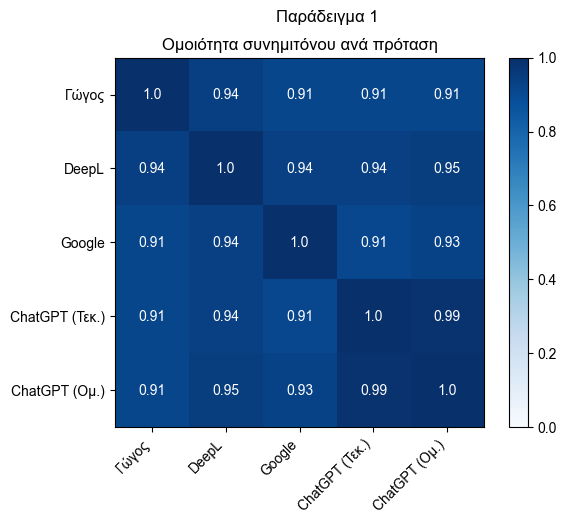

Παράδειγμα 2:


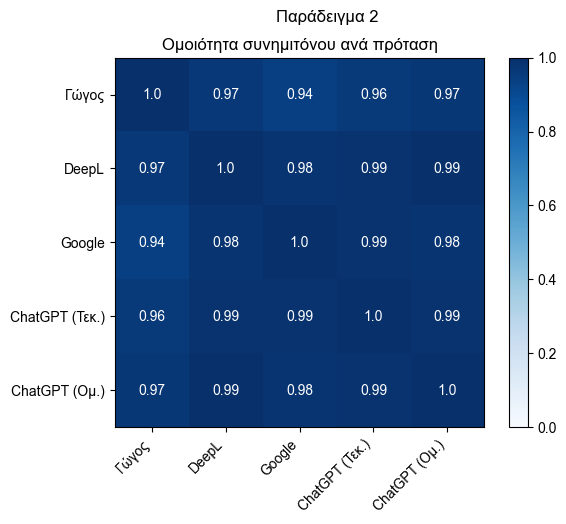

Παράδειγμα 3:


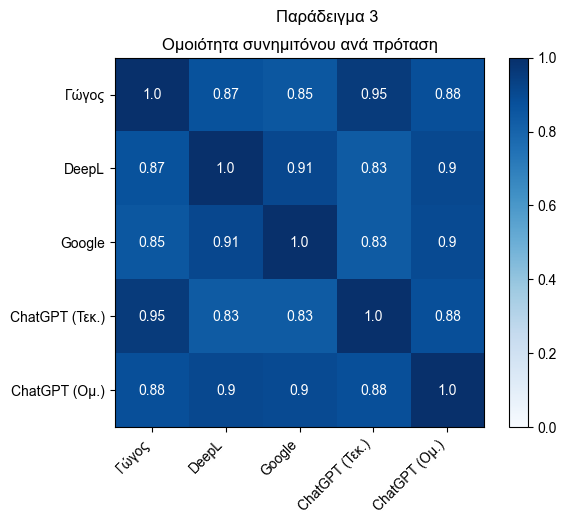

Παράδειγμα 4:


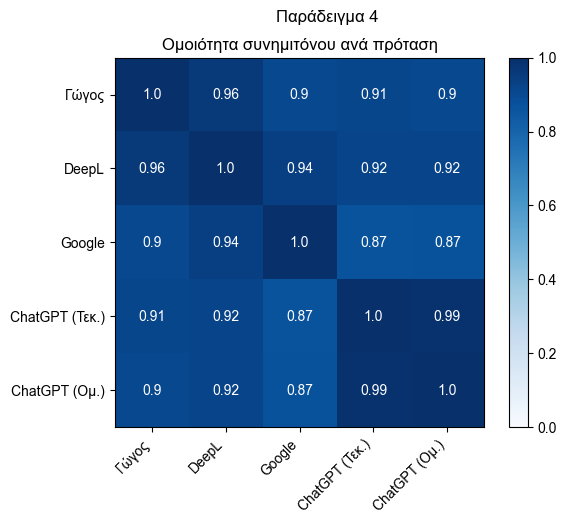

Παράδειγμα 5:


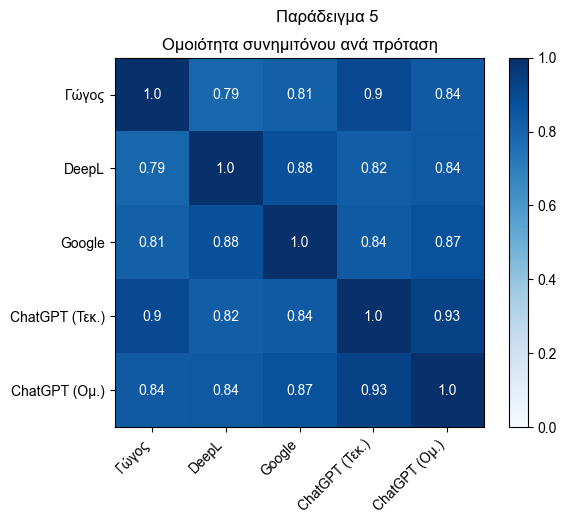

In [23]:
sent_similarities = visualizer.compare_sentence_similarity(analysis_df)

for i, row in analysis_df.groupby('id'):
    print(f'Παράδειγμα {i}:')
    visualizer.sentence_similarity_heatmap(row, save=True)

Παράδειγμα 1:


id           version      translator           level_1   POS Case Definite  \
0   1        ελλΑΚ-1951           Γώγος               der   DET  Nom      Def   
0   1        ελλΑΚ-1951           Γώγος         Auslegung  NOUN  Dat      NaN   
0   1        ελλΑΚ-1951           Γώγος             einer   DET  Gen      Ind   
1   1        ελλΑΚ-1940           DeepL               der   DET  Nom      Def   
1   1        ελλΑΚ-1940           DeepL         Auslegung  NOUN  Dat      NaN   
1   1        ελλΑΚ-1940           DeepL             einer   DET  Gen      Ind   
2   1        ελλΑΚ-1940          Google               der   DET  Gen      Def   
2   1        ελλΑΚ-1940          Google         Auslegung  NOUN  Dat      NaN   
2   1        ελλΑΚ-1940          Google  Willenserklärung  NOUN  Gen      NaN   
3   1      Τεκμηριωτική  ChatGPT (Τεκ.)               der   DET  Gen      Def   
3   1      Τεκμηριωτική  ChatGPT (Τεκ.)         Auslegung  NOUN  Dat      NaN   
3   1      Τεκμηριωτική  ChatGPT (Τεκ.)  Willenserklärung  NOUN  Gen      NaN   
4   1  Ομοιολειτουργική   ChatGPT (Ομ.)               der   DET  Gen      Def   
4   1  Ομοιολειτουργική   ChatGPT (Ομ.)         Auslegung  NOUN  Dat      NaN   
4   1  Ομοιολειτουργική   ChatGPT (Ομ.)  Willenserklärung  NOUN  Gen      NaN   

  Gender Number PronType Mood Person Tense VerbForm Degree  
0   Masc   Sing      Art  NaN    NaN   NaN      NaN    NaN  
0    Fem   Sing      NaN  NaN    NaN   NaN      NaN    NaN  
0    Fem   Sing      Art  NaN    NaN   NaN      NaN    NaN  
1   Masc   Sing      Art  NaN    NaN   NaN      NaN    NaN  
1    Fem   Sing      NaN  NaN    NaN   NaN      NaN    NaN  
1    Fem   Sing      Art  NaN    NaN   NaN      NaN    NaN  
2    Fem   Sing      Art  NaN    NaN   NaN      NaN    NaN  
2    Fem   Sing      NaN  NaN    NaN   NaN      NaN    NaN  
2    Fem   Sing      NaN  NaN    NaN   NaN      NaN    NaN  
3    Fem   Sing      Art  NaN    NaN   NaN      NaN    NaN  
3    Fem   Sing      NaN  NaN    NaN   NaN      NaN    NaN  
3    Fem   Sing      NaN  NaN    NaN   NaN      NaN    NaN  
4    Fem   Sing      Art  NaN    NaN   NaN      NaN    NaN  
4    Fem   Sing      NaN  NaN    NaN   NaN      NaN    NaN  
4    Fem   Sing      NaN  NaN    NaN   NaN      NaN    NaN

['POS', 'Case', 'Definite', 'Gender', 'Number', 'PronType', 'Mood', 'Person', 'Tense', 'VerbForm', 'Degree']

Text(0, 0, 'Γώγος')
Text(1, 0, 'DeepL')
Text(2, 0, 'Google')
Text(3, 0, 'ChatGPT (Τεκ.)')
Text(4, 0, 'ChatGPT (Ομ.)')
Text(0, 0, 'Γώγος')
Text(1, 0, 'DeepL')
Text(2, 0, 'Google')
Text(3, 0, 'ChatGPT (Τεκ.)')
Text(4, 0, 'ChatGPT (Ομ.)')
Text(0, 0, 'Γώγος')
Text(1, 0, 'DeepL')
Text(2, 0, 'Google')
Text(3, 0, 'ChatGPT (Τεκ.)')
Text(4, 0, 'ChatGPT (Ομ.)')
Text(0, 0, 'Γώγος')
Text(1, 0, 'DeepL')
Text(2, 0, 'Google')
Text(3, 0, 'ChatGPT (Τεκ.)')
Text(4, 0, 'ChatGPT (Ομ.)')
Text(0, 0, 'Γώγος')
Text(1, 0, 'DeepL')
Text(2, 0, 'Google')
Text(3, 0, 'ChatGPT (Τεκ.)')
Text(4, 0, 'ChatGPT (Ομ.)')
Text(0, 0, 'Γώγος')
Text(1, 0, 'DeepL')
Text(2, 0, 'Google')
Text(3, 0, 'ChatGPT (Τεκ.)')
Text(4, 0, 'ChatGPT (Ομ.)')
Text(0, 0, 'Γώγος')
Text(1, 0, 'DeepL')
Text(2, 0, 'Google')
Text(3, 0, 'ChatGPT (Τεκ.)')
Text(4, 0, 'ChatGPT (Ομ.)')
Text(0, 0, 'Γώγος')
Text(1, 0, 'DeepL')
Text(2, 0, 'Google')
Tex

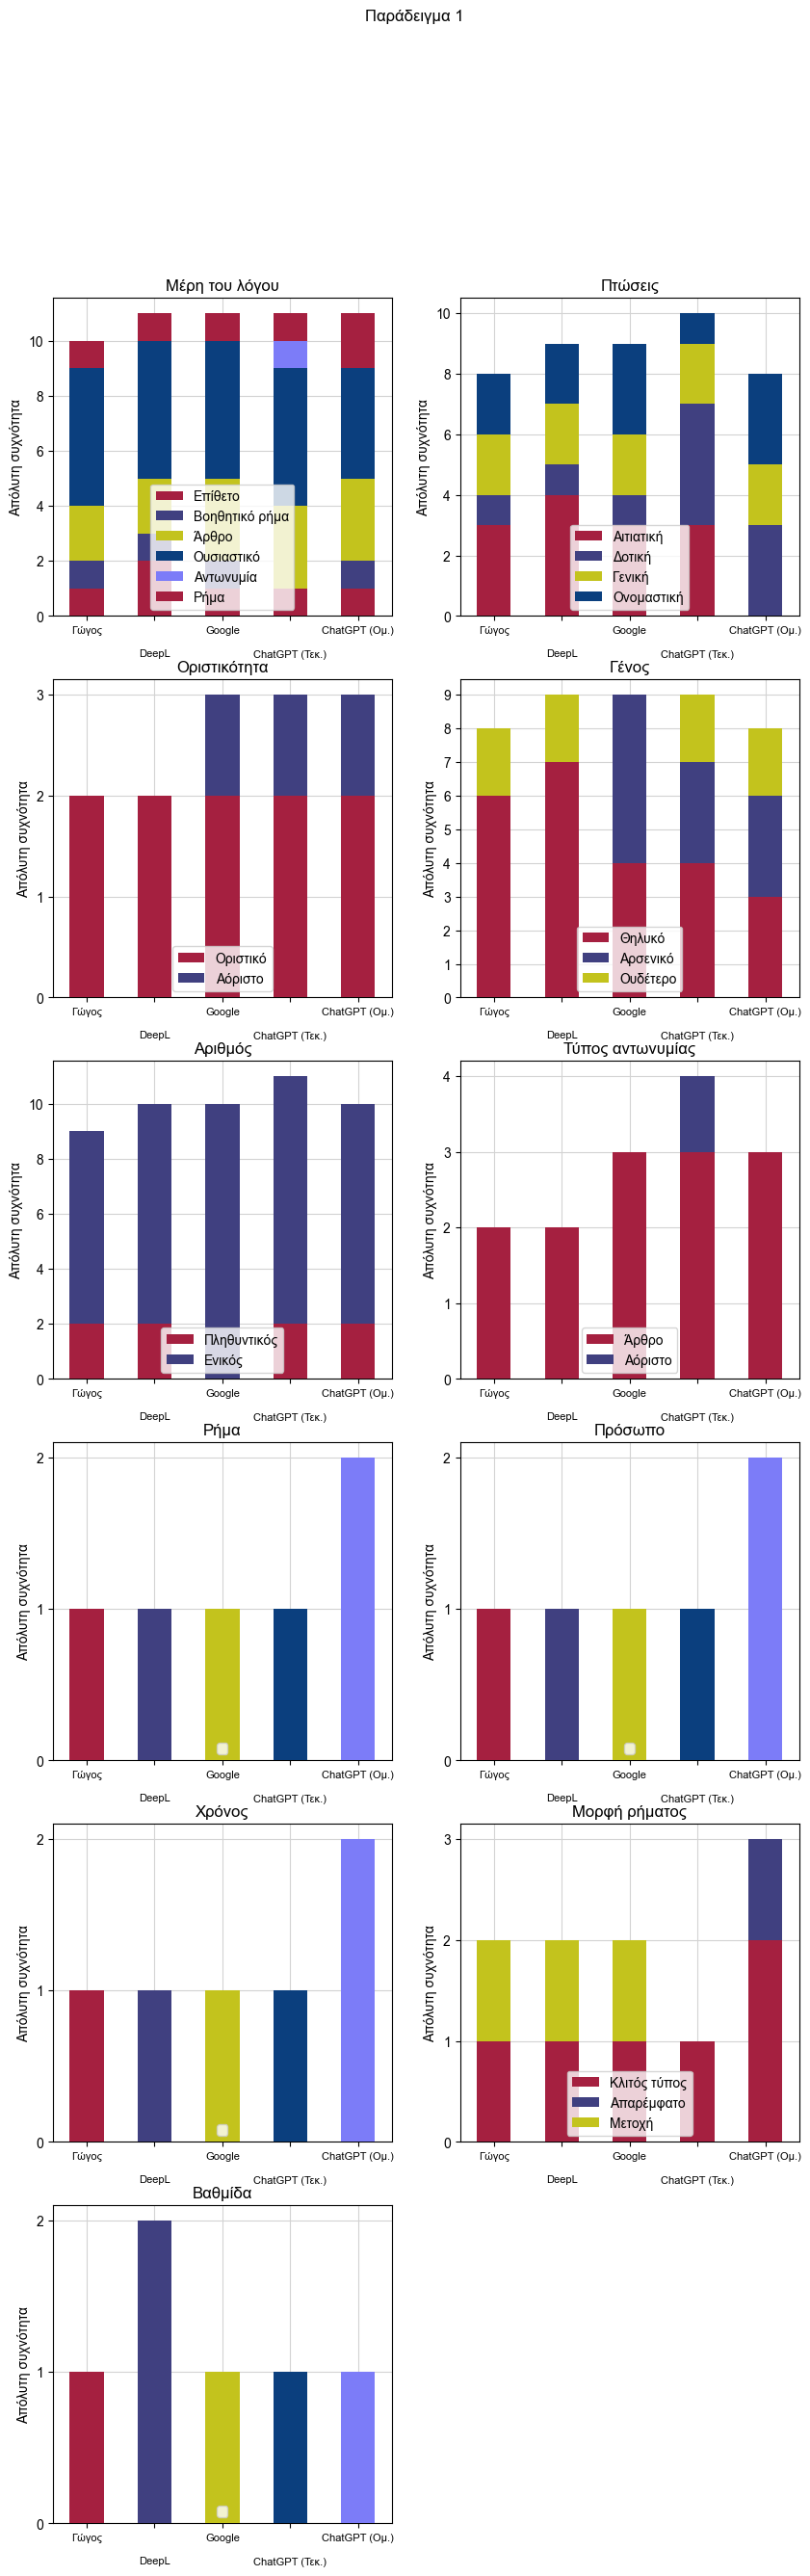

Παράδειγμα 2:


id           version      translator  level_1   POS Case Definite Gender  \
5   2        ελλΑΚ-1951           Γώγος      die   DET  Nom      Def    Fem   
5   2        ελλΑΚ-1951           Γώγος  Fristen  NOUN  Acc      NaN    Fem   
5   2        ελλΑΚ-1951           Γώγος   welche   DET  Acc      NaN   Neut   
6   2        ελλΑΚ-1940           DeepL      die   DET  Nom      Def    Fem   
6   2        ελλΑΚ-1940           DeepL  Fristen  NOUN  Gen      NaN    Fem   
6   2        ελλΑΚ-1940           DeepL   Gesetz  NOUN  Acc      NaN   Neut   
7   2        ελλΑΚ-1940          Google      die   DET  Acc      Def    Fem   
7   2        ελλΑΚ-1940          Google  Fristen  NOUN  Gen      NaN    Fem   
7   2        ελλΑΚ-1940          Google   Gesetz  NOUN  Acc      NaN   Neut   
8   2      Τεκμηριωτική  ChatGPT (Τεκ.)      die   DET  Acc      Def    Fem   
8   2      Τεκμηριωτική  ChatGPT (Τεκ.)  Fristen  NOUN  Acc      NaN    Fem   
8   2      Τεκμηριωτική  ChatGPT (Τεκ.)   Gesetz  NOUN  Acc      NaN   Neut   
9   2  Ομοιολειτουργική   ChatGPT (Ομ.)      die   DET  Nom      Def    Fem   
9   2  Ομοιολειτουργική   ChatGPT (Ομ.)  Fristen  NOUN  Nom      NaN    Fem   
9   2  Ομοιολειτουργική   ChatGPT (Ομ.)   Gesetz  NOUN  Acc      NaN   Neut   

  Number PronType Degree VerbForm Mood Person Tense  
5   Plur      Art    NaN      NaN  NaN    NaN   NaN  
5   Plur      NaN    NaN      NaN  NaN    NaN   NaN  
5   Plur      Int    NaN      NaN  NaN    NaN   NaN  
6   Plur      Art    NaN      NaN  NaN    NaN   NaN  
6   Plur      NaN    NaN      NaN  NaN    NaN   NaN  
6   Sing      NaN    NaN      NaN  NaN    NaN   NaN  
7   Sing      Art    NaN      NaN  NaN    NaN   NaN  
7   Plur      NaN    NaN      NaN  NaN    NaN   NaN  
7   Sing      NaN    NaN      NaN  NaN    NaN   NaN  
8   Sing      Art    NaN      NaN  NaN    NaN   NaN  
8   Plur      NaN    NaN      NaN  NaN    NaN   NaN  
8   Sing      NaN    NaN      NaN  NaN    NaN   NaN  
9   Plur      Art    NaN      NaN  NaN    NaN   NaN  
9   Plur      NaN    NaN      NaN  NaN    NaN   NaN  
9   Sing      NaN    NaN      NaN  NaN    NaN   NaN

['POS', 'Case', 'Definite', 'Gender', 'Number', 'PronType', 'Degree', 'VerbForm', 'Mood', 'Person', 'Tense']

Text(0, 0, 'Γώγος')
Text(1, 0, 'DeepL')
Text(2, 0, 'Google')
Text(3, 0, 'ChatGPT (Τεκ.)')
Text(4, 0, 'ChatGPT (Ομ.)')
Text(0, 0, 'Γώγος')
Text(1, 0, 'DeepL')
Text(2, 0, 'Google')
Text(3, 0, 'ChatGPT (Τεκ.)')
Text(4, 0, 'ChatGPT (Ομ.)')
Text(0, 0, 'Γώγος')
Text(1, 0, 'DeepL')
Text(2, 0, 'Google')
Text(3, 0, 'ChatGPT (Τεκ.)')
Text(4, 0, 'ChatGPT (Ομ.)')
Text(0, 0, 'Γώγος')
Text(1, 0, 'DeepL')
Text(2, 0, 'Google')
Text(3, 0, 'ChatGPT (Τεκ.)')
Text(4, 0, 'ChatGPT (Ομ.)')
Text(0, 0, 'Γώγος')
Text(1, 0, 'DeepL')
Text(2, 0, 'Google')
Text(3, 0, 'ChatGPT (Τεκ.)')
Text(4, 0, 'ChatGPT (Ομ.)')
Text(0, 0, 'Γώγος')
Text(1, 0, 'DeepL')
Text(2, 0, 'Google')
Text(3, 0, 'ChatGPT (Τεκ.)')
Text(4, 0, 'ChatGPT (Ομ.)')
Text(0, 0, 'Γώγος')
Text(1, 0, 'DeepL')
Text(2, 0, 'Google')
Text(3, 0, 'ChatGPT (Τεκ.)')
Text(4, 0, 'ChatGPT (Ομ.)')
Text(0, 0, 'Γώγος')
Text(1, 0, 'DeepL')
Text(2, 0, 'Google')
Tex

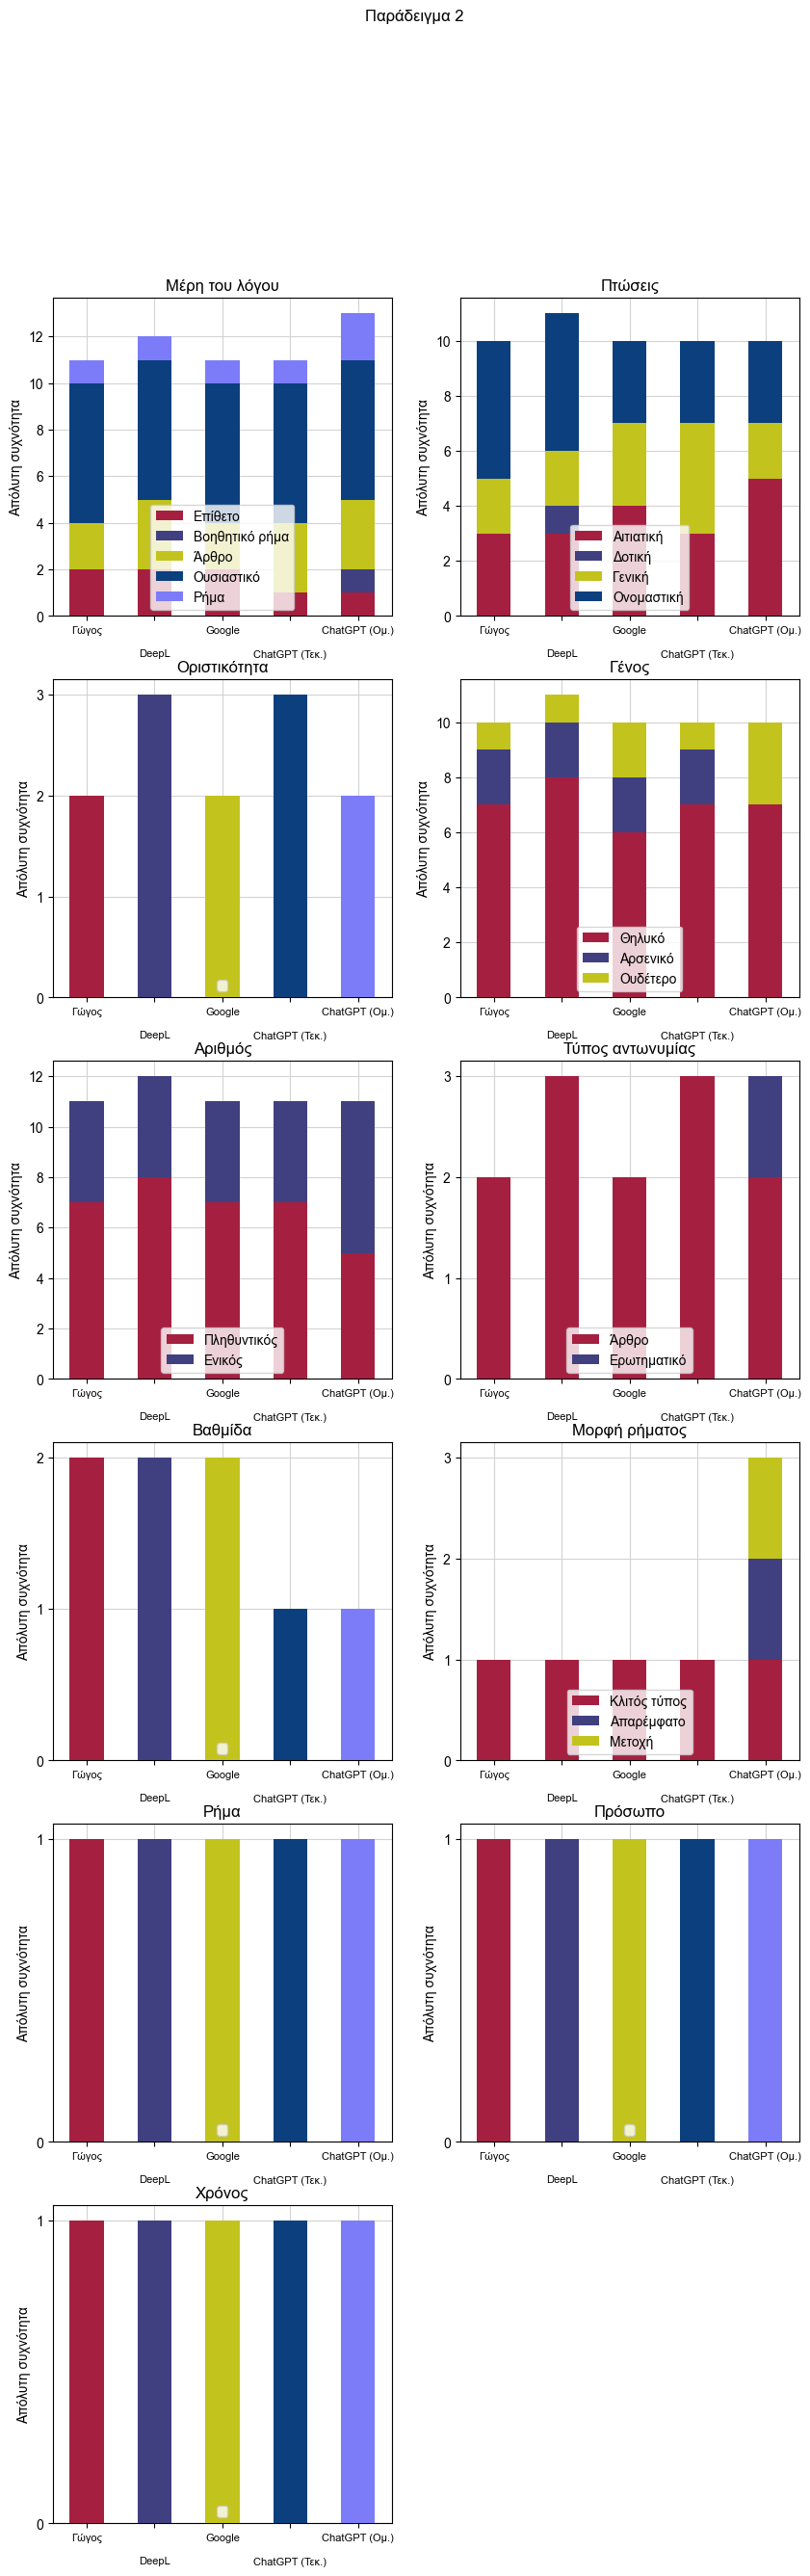

Παράδειγμα 3:


id           version      translator     level_1   POS Case Definite  \
10   3        ελλΑΚ-1951           Γώγος         Die   DET  Nom      Def   
10   3        ελλΑΚ-1951           Γώγος         der   DET  Gen      Def   
10   3        ελλΑΚ-1951           Γώγος     Vorname  NOUN  Dat      NaN   
11   3        ελλΑΚ-1940           DeepL         Die   DET  Nom      Def   
11   3        ελλΑΚ-1940           DeepL         der   DET  Gen      Def   
11   3        ελλΑΚ-1940           DeepL  Zustimmung  NOUN  Nom      NaN   
12   3        ελλΑΚ-1940          Google         Die   DET  Nom      Def   
12   3        ελλΑΚ-1940          Google         der   DET  Gen      Def   
12   3        ελλΑΚ-1940          Google    erteilte   ADJ  Acc      NaN   
13   3      Τεκμηριωτική  ChatGPT (Τεκ.)         Die   DET  Nom      Def   
13   3      Τεκμηριωτική  ChatGPT (Τεκ.)         der   DET  Dat      Def   
13   3      Τεκμηριωτική  ChatGPT (Τεκ.)         des   DET  Gen      Def   
14   3  Ομοιολειτουργική   ChatGPT (Ομ.)         Die   DET  Nom      Def   
14   3  Ομοιολειτουργική   ChatGPT (Ομ.)         der   DET  Gen      Def   
14   3  Ομοιολειτουργική   ChatGPT (Ομ.)  Zustimmung  NOUN  Nom      NaN   

   Gender Number PronType Degree Mood Person Tense VerbForm Reflex  
10    Fem   Sing      Art    NaN  NaN    NaN   NaN      NaN    NaN  
10    Fem   Sing      Art    NaN  NaN    NaN   NaN      NaN    NaN  
10    Fem   Sing      NaN    NaN  NaN    NaN   NaN      NaN    NaN  
11    Fem   Sing      Art    NaN  NaN    NaN   NaN      NaN    NaN  
11    Fem   Sing      Art    NaN  NaN    NaN   NaN      NaN    NaN  
11    Fem   Sing      NaN    NaN  NaN    NaN   NaN      NaN    NaN  
12    Fem   Sing      Art    NaN  NaN    NaN   NaN      NaN    NaN  
12    Fem   Sing      Art    NaN  NaN    NaN   NaN      NaN    NaN  
12    Fem   Sing      NaN    Pos  NaN    NaN   NaN      NaN    NaN  
13    Fem   Sing      Art    NaN  NaN    NaN   NaN      NaN    NaN  
13    Fem   Sing      Art    NaN  NaN    NaN   NaN      NaN    NaN  
13   Neut   Sing      Art    NaN  NaN    NaN   NaN      NaN    NaN  
14    Fem   Sing      Art    NaN  NaN    NaN   NaN      NaN    NaN  
14    Fem   Sing      Art    NaN  NaN    NaN   NaN      NaN    NaN  
14    Fem   Sing      NaN    NaN  NaN    NaN   NaN      NaN    NaN

['POS', 'Case', 'Definite', 'Gender', 'Number', 'PronType', 'Degree', 'Mood', 'Person', 'Tense', 'VerbForm', 'Reflex']

Text(0, 0, 'Γώγος')
Text(1, 0, 'DeepL')
Text(2, 0, 'Google')
Text(3, 0, 'ChatGPT (Τεκ.)')
Text(4, 0, 'ChatGPT (Ομ.)')
Text(0, 0, 'Γώγος')
Text(1, 0, 'DeepL')
Text(2, 0, 'Google')
Text(3, 0, 'ChatGPT (Τεκ.)')
Text(4, 0, 'ChatGPT (Ομ.)')
Text(0, 0, 'Γώγος')
Text(1, 0, 'DeepL')
Text(2, 0, 'Google')
Text(3, 0, 'ChatGPT (Τεκ.)')
Text(4, 0, 'ChatGPT (Ομ.)')
Text(0, 0, 'Γώγος')
Text(1, 0, 'DeepL')
Text(2, 0, 'Google')
Text(3, 0, 'ChatGPT (Τεκ.)')
Text(4, 0, 'ChatGPT (Ομ.)')
Text(0, 0, 'Γώγος')
Text(1, 0, 'DeepL')
Text(2, 0, 'Google')
Text(3, 0, 'ChatGPT (Τεκ.)')
Text(4, 0, 'ChatGPT (Ομ.)')
Text(0, 0, 'Γώγος')
Text(1, 0, 'DeepL')
Text(2, 0, 'Google')
Text(3, 0, 'ChatGPT (Τεκ.)')
Text(4, 0, 'ChatGPT (Ομ.)')
Text(0, 0, 'ChatGPT (Τεκ.)')
Text(1, 0, 'Google')
Text(2, 0, 'Γώγος')
Text(0, 0, 'Γώγος')
Text(1, 0, 'DeepL')
Text(2, 0, 'Google')
Text(3, 0, 'ChatGPT (Τεκ.)')
Text(4, 0, '

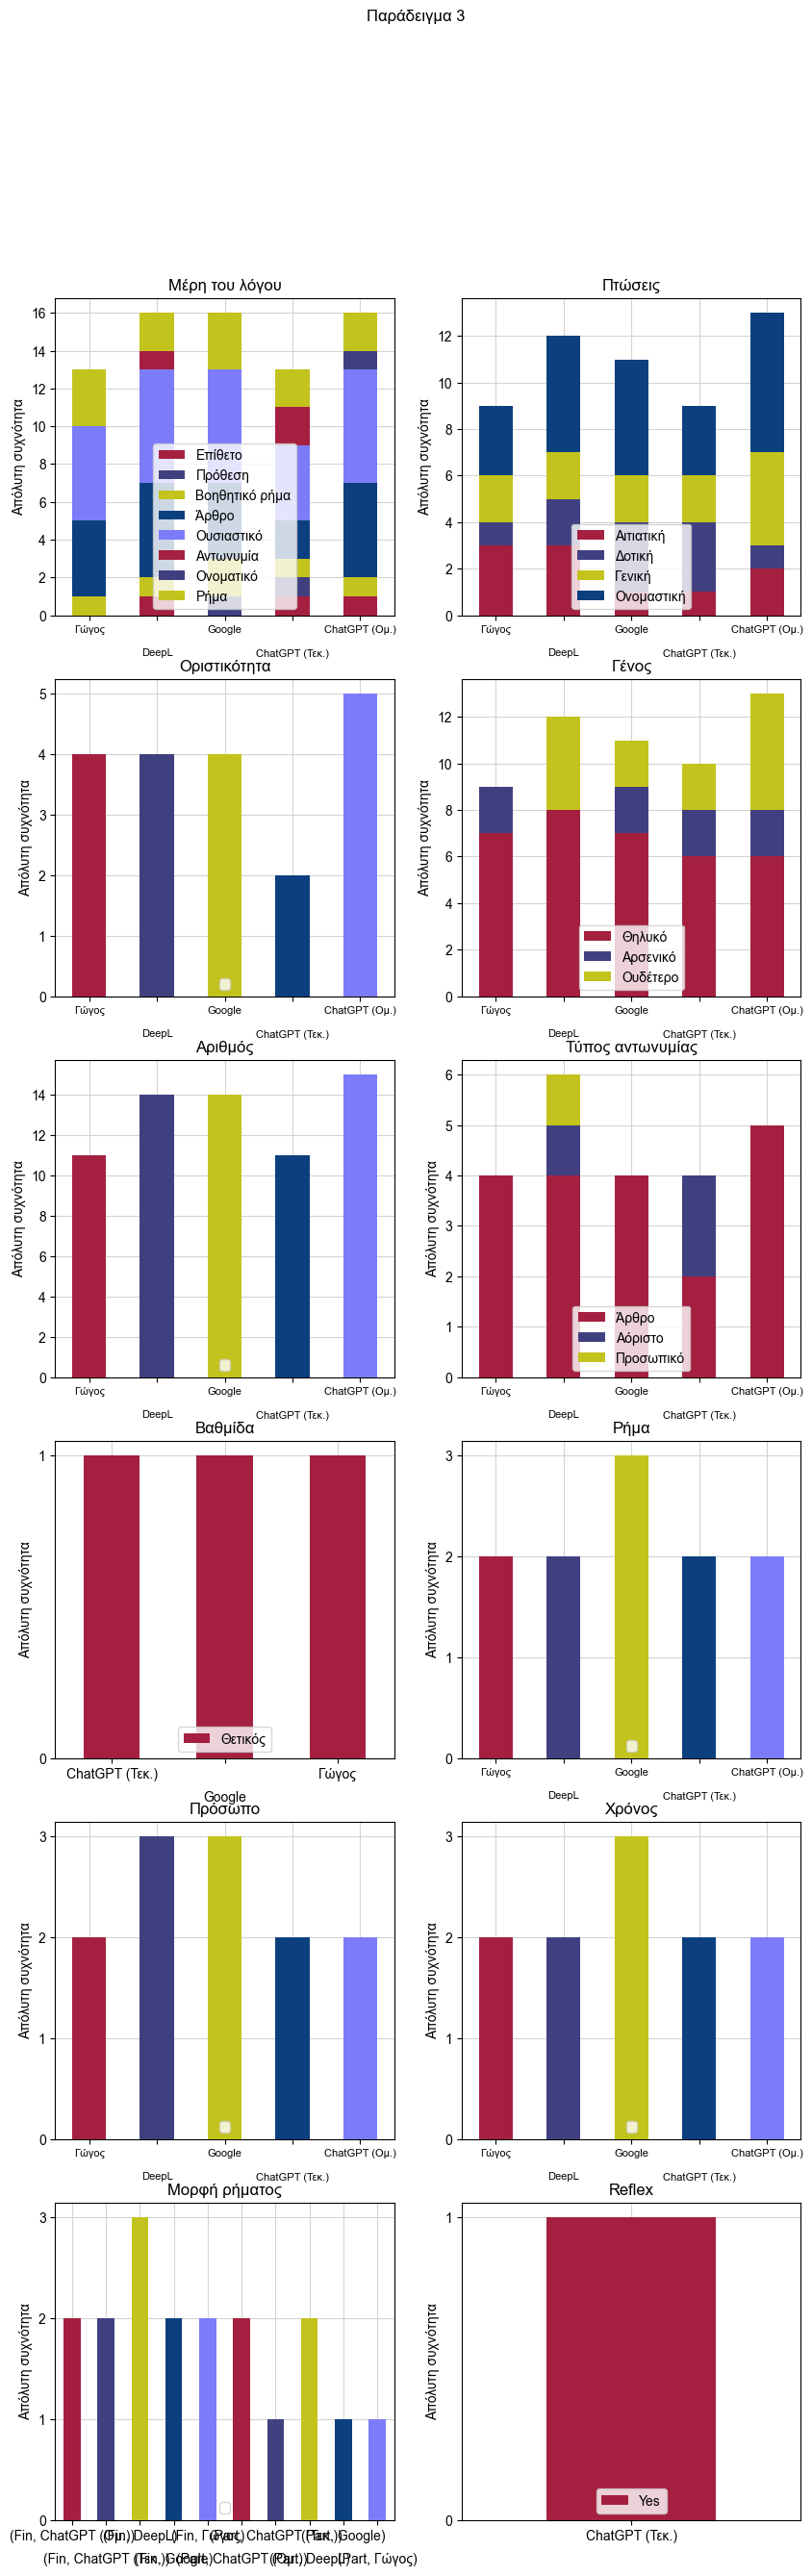

Παράδειγμα 4:


id           version      translator level_1   POS Case Definite Gender  \
15   4        ελλΑΚ-1951           Γώγος     dem   DET  Dat      Def   Masc   
15   4        ελλΑΚ-1951           Γώγος    Tode  NOUN  Dat      NaN   Masc   
15   4        ελλΑΚ-1951           Γώγος   einer   DET  Gen      Ind    Fem   
16   4        ελλΑΚ-1940           DeepL   einer   DET  Gen      Ind    Fem   
16   4        ελλΑΚ-1940           DeepL  Person  NOUN  Gen      NaN    Fem   
16   4        ελλΑΚ-1940           DeepL    geht  VERB  NaN      NaN    NaN   
17   4        ελλΑΚ-1940          Google   einer   DET  Gen      Ind    Fem   
17   4        ελλΑΚ-1940          Google  Person  NOUN  Gen      NaN    Fem   
17   4        ελλΑΚ-1940          Google    geht  VERB  NaN      NaN    NaN   
18   4      Τεκμηριωτική  ChatGPT (Τεκ.)     dem   DET  Dat      Def   Neut   
18   4      Τεκμηριωτική  ChatGPT (Τεκ.)   einer   DET  Gen      Ind    Fem   
18   4      Τεκμηριωτική  ChatGPT (Τεκ.)  Person  NOUN  Gen      NaN    Fem   
19   4  Ομοιολειτουργική   ChatGPT (Ομ.)     dem   DET  Dat      Def   Neut   
19   4  Ομοιολειτουργική   ChatGPT (Ομ.)   einer   DET  Gen      Ind    Fem   
19   4  Ομοιολειτουργική   ChatGPT (Ομ.)  Person  NOUN  Gen      NaN    Fem   

   Number PronType Mood Person Tense VerbForm Degree Poss  
15   Sing      Art  NaN    NaN   NaN      NaN    NaN  NaN  
15   Sing      NaN  NaN    NaN   NaN      NaN    NaN  NaN  
15   Sing      Art  NaN    NaN   NaN      NaN    NaN  NaN  
16   Sing      Art  NaN    NaN   NaN      NaN    NaN  NaN  
16   Sing      NaN  NaN    NaN   NaN      NaN    NaN  NaN  
16   Sing      NaN  Ind      3  Pres      Fin    NaN  NaN  
17   Sing      Art  NaN    NaN   NaN      NaN    NaN  NaN  
17   Sing      NaN  NaN    NaN   NaN      NaN    NaN  NaN  
17   Sing      NaN  Ind      3  Pres      Fin    NaN  NaN  
18   Sing      Art  NaN    NaN   NaN      NaN    NaN  NaN  
18   Sing      Art  NaN    NaN   NaN      NaN    NaN  NaN  
18   Sing      NaN  NaN    NaN   NaN      NaN    NaN  NaN  
19   Sing      Art  NaN    NaN   NaN      NaN    NaN  NaN  
19   Sing      Art  NaN    NaN   NaN      NaN    NaN  NaN  
19   Sing      NaN  NaN    NaN   NaN      NaN    NaN  NaN

['POS', 'Case', 'Definite', 'Gender', 'Number', 'PronType', 'Mood', 'Person', 'Tense', 'VerbForm', 'Degree', 'Poss']

Text(0, 0, 'Γώγος')
Text(1, 0, 'DeepL')
Text(2, 0, 'Google')
Text(3, 0, 'ChatGPT (Τεκ.)')
Text(4, 0, 'ChatGPT (Ομ.)')
Text(0, 0, 'Γώγος')
Text(1, 0, 'DeepL')
Text(2, 0, 'Google')
Text(3, 0, 'ChatGPT (Τεκ.)')
Text(4, 0, 'ChatGPT (Ομ.)')
Text(0, 0, 'Γώγος')
Text(1, 0, 'DeepL')
Text(2, 0, 'Google')
Text(3, 0, 'ChatGPT (Τεκ.)')
Text(4, 0, 'ChatGPT (Ομ.)')
Text(0, 0, 'Γώγος')
Text(1, 0, 'DeepL')
Text(2, 0, 'Google')
Text(3, 0, 'ChatGPT (Τεκ.)')
Text(4, 0, 'ChatGPT (Ομ.)')
Text(0, 0, '(Sing, ChatGPT (Ομ.))')
Text(1, 0, '(Sing, ChatGPT (Τεκ.))')
Text(2, 0, '(Sing, DeepL)')
Text(3, 0, '(Sing, Google)')
Text(4, 0, '(Sing, Γώγος)')
Text(5, 0, '(Plur, ChatGPT (Ομ.))')
Text(6, 0, '(Plur, ChatGPT (Τεκ.))')
Text(7, 0, '(Plur, DeepL)')
Text(8, 0, '(Plur, Google)')
Text(9, 0, '(Plur, Γώγος)')
Text(0, 0, 'Γώγος')
Text(1, 0, 'DeepL')
Text(2, 0, 'Google')
Text(3, 0, 'ChatGPT (Τεκ.)')
Text

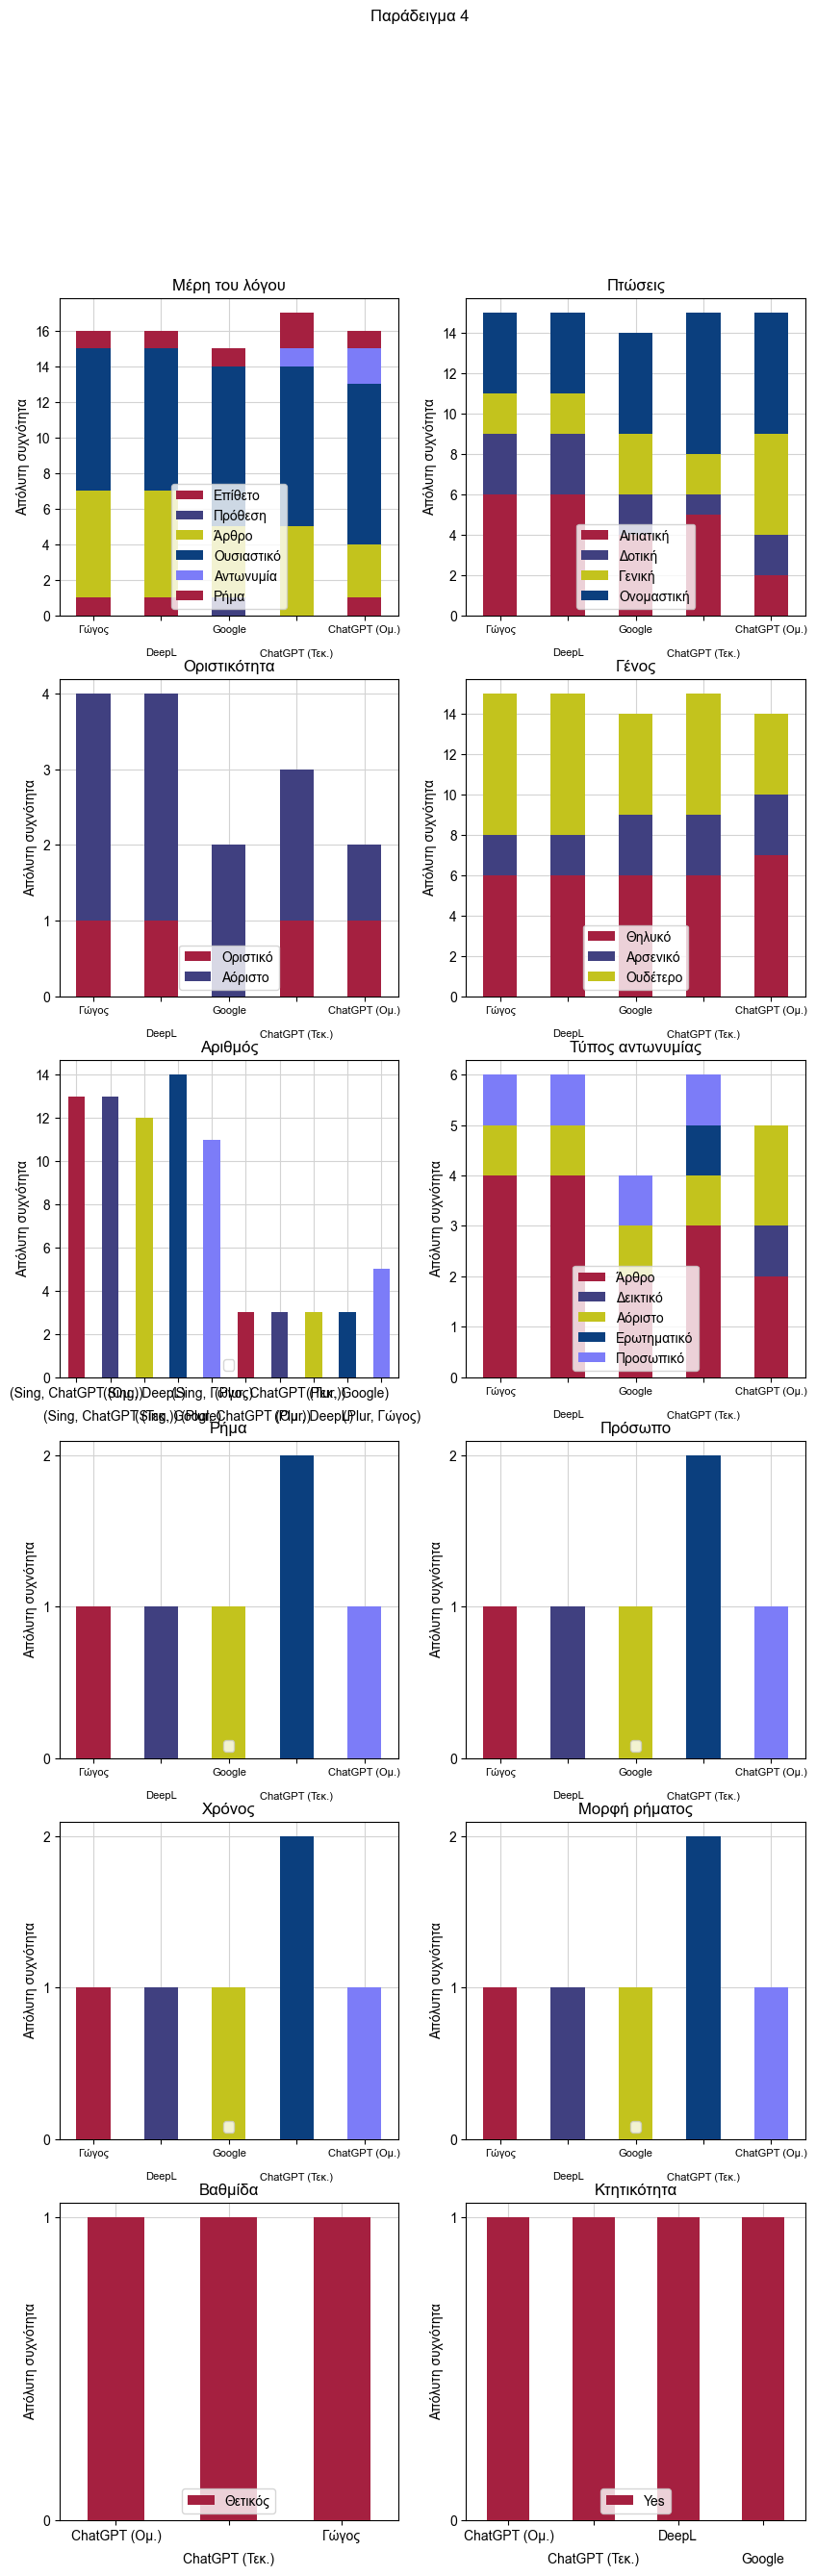

Παράδειγμα 5:


id           version      translator    level_1   POS Case Gender Number  \
20   5        ελλΑΚ-1951           Γώγος       Erbe  NOUN  Nom   Neut   Sing   
20   5        ελλΑΚ-1951           Γώγος       kann   AUX  NaN    NaN   Sing   
20   5        ελλΑΚ-1951           Γώγος  derjenige  PRON  Nom   Masc   Sing   
21   5        ελλΑΚ-1940           DeepL       Erbe  NOUN  Acc   Neut   Sing   
21   5        ελλΑΚ-1940           DeepL       kann   AUX  NaN    NaN   Sing   
21   5        ελλΑΚ-1940           DeepL        des   DET  Gen   Masc   Sing   
22   5        ελλΑΚ-1940          Google       Erbe  NOUN  Nom   Neut   Sing   
22   5        ελλΑΚ-1940          Google       kann   AUX  NaN    NaN   Sing   
22   5        ελλΑΚ-1940          Google        der   DET  Gen    Fem   Sing   
23   5      Τεκμηριωτική  ChatGPT (Τεκ.)       Erbe  NOUN  Nom   Neut   Sing   
23   5      Τεκμηριωτική  ChatGPT (Τεκ.)       kann   AUX  NaN    NaN   Sing   
23   5      Τεκμηριωτική  ChatGPT (Τεκ.)       sein   AUX  NaN    NaN    NaN   
24   5  Ομοιολειτουργική   ChatGPT (Ομ.)       Erbe  NOUN  Nom   Neut   Sing   
24   5  Ομοιολειτουργική   ChatGPT (Ομ.)       kann   AUX  NaN    NaN   Sing   
24   5  Ομοιολειτουργική   ChatGPT (Ομ.)  derjenige  PRON  Nom   Masc   Sing   

   Mood Person Tense VerbForm PronType Definite Degree  
20  NaN    NaN   NaN      NaN      NaN      NaN    NaN  
20  Ind      3  Pres      Fin      NaN      NaN    NaN  
20  NaN    NaN   NaN      NaN      Dem      NaN    NaN  
21  NaN    NaN   NaN      NaN      NaN      NaN    NaN  
21  Ind      3  Pres      Fin      NaN      NaN    NaN  
21  NaN    NaN   NaN      NaN      Art      Def    NaN  
22  NaN    NaN   NaN      NaN      NaN      NaN    NaN  
22  Ind      3  Pres      Fin      NaN      NaN    NaN  
22  NaN    NaN   NaN      NaN      Art      Def    NaN  
23  NaN    NaN   NaN      NaN      NaN      NaN    NaN  
23  Ind      3  Pres      Fin      NaN      NaN    NaN  
23  NaN    NaN   NaN      Inf      NaN      NaN    NaN  
24  NaN    NaN   NaN      NaN      NaN      NaN    NaN  
24  Ind      3  Pres      Fin      NaN      NaN    NaN  
24  NaN    NaN   NaN      NaN      Dem      NaN    NaN

['POS', 'Case', 'Gender', 'Number', 'Mood', 'Person', 'Tense', 'VerbForm', 'PronType', 'Definite', 'Degree']

Text(0, 0, 'Γώγος')
Text(1, 0, 'DeepL')
Text(2, 0, 'Google')
Text(3, 0, 'ChatGPT (Τεκ.)')
Text(4, 0, 'ChatGPT (Ομ.)')
Text(0, 0, 'Γώγος')
Text(1, 0, 'DeepL')
Text(2, 0, 'Google')
Text(3, 0, 'ChatGPT (Τεκ.)')
Text(4, 0, 'ChatGPT (Ομ.)')
Text(0, 0, 'Γώγος')
Text(1, 0, 'DeepL')
Text(2, 0, 'Google')
Text(3, 0, 'ChatGPT (Τεκ.)')
Text(4, 0, 'ChatGPT (Ομ.)')
Text(0, 0, 'Γώγος')
Text(1, 0, 'DeepL')
Text(2, 0, 'Google')
Text(3, 0, 'ChatGPT (Τεκ.)')
Text(4, 0, 'ChatGPT (Ομ.)')
Text(0, 0, 'Γώγος')
Text(1, 0, 'DeepL')
Text(2, 0, 'Google')
Text(3, 0, 'ChatGPT (Τεκ.)')
Text(4, 0, 'ChatGPT (Ομ.)')
Text(0, 0, 'Γώγος')
Text(1, 0, 'DeepL')
Text(2, 0, 'Google')
Text(3, 0, 'ChatGPT (Τεκ.)')
Text(4, 0, 'ChatGPT (Ομ.)')
Text(0, 0, 'Γώγος')
Text(1, 0, 'DeepL')
Text(2, 0, 'Google')
Text(3, 0, 'ChatGPT (Τεκ.)')
Text(4, 0, 'ChatGPT (Ομ.)')
Text(0, 0, 'Γώγος')
Text(1, 0, 'DeepL')
Text(2, 0, 'Google')
Tex

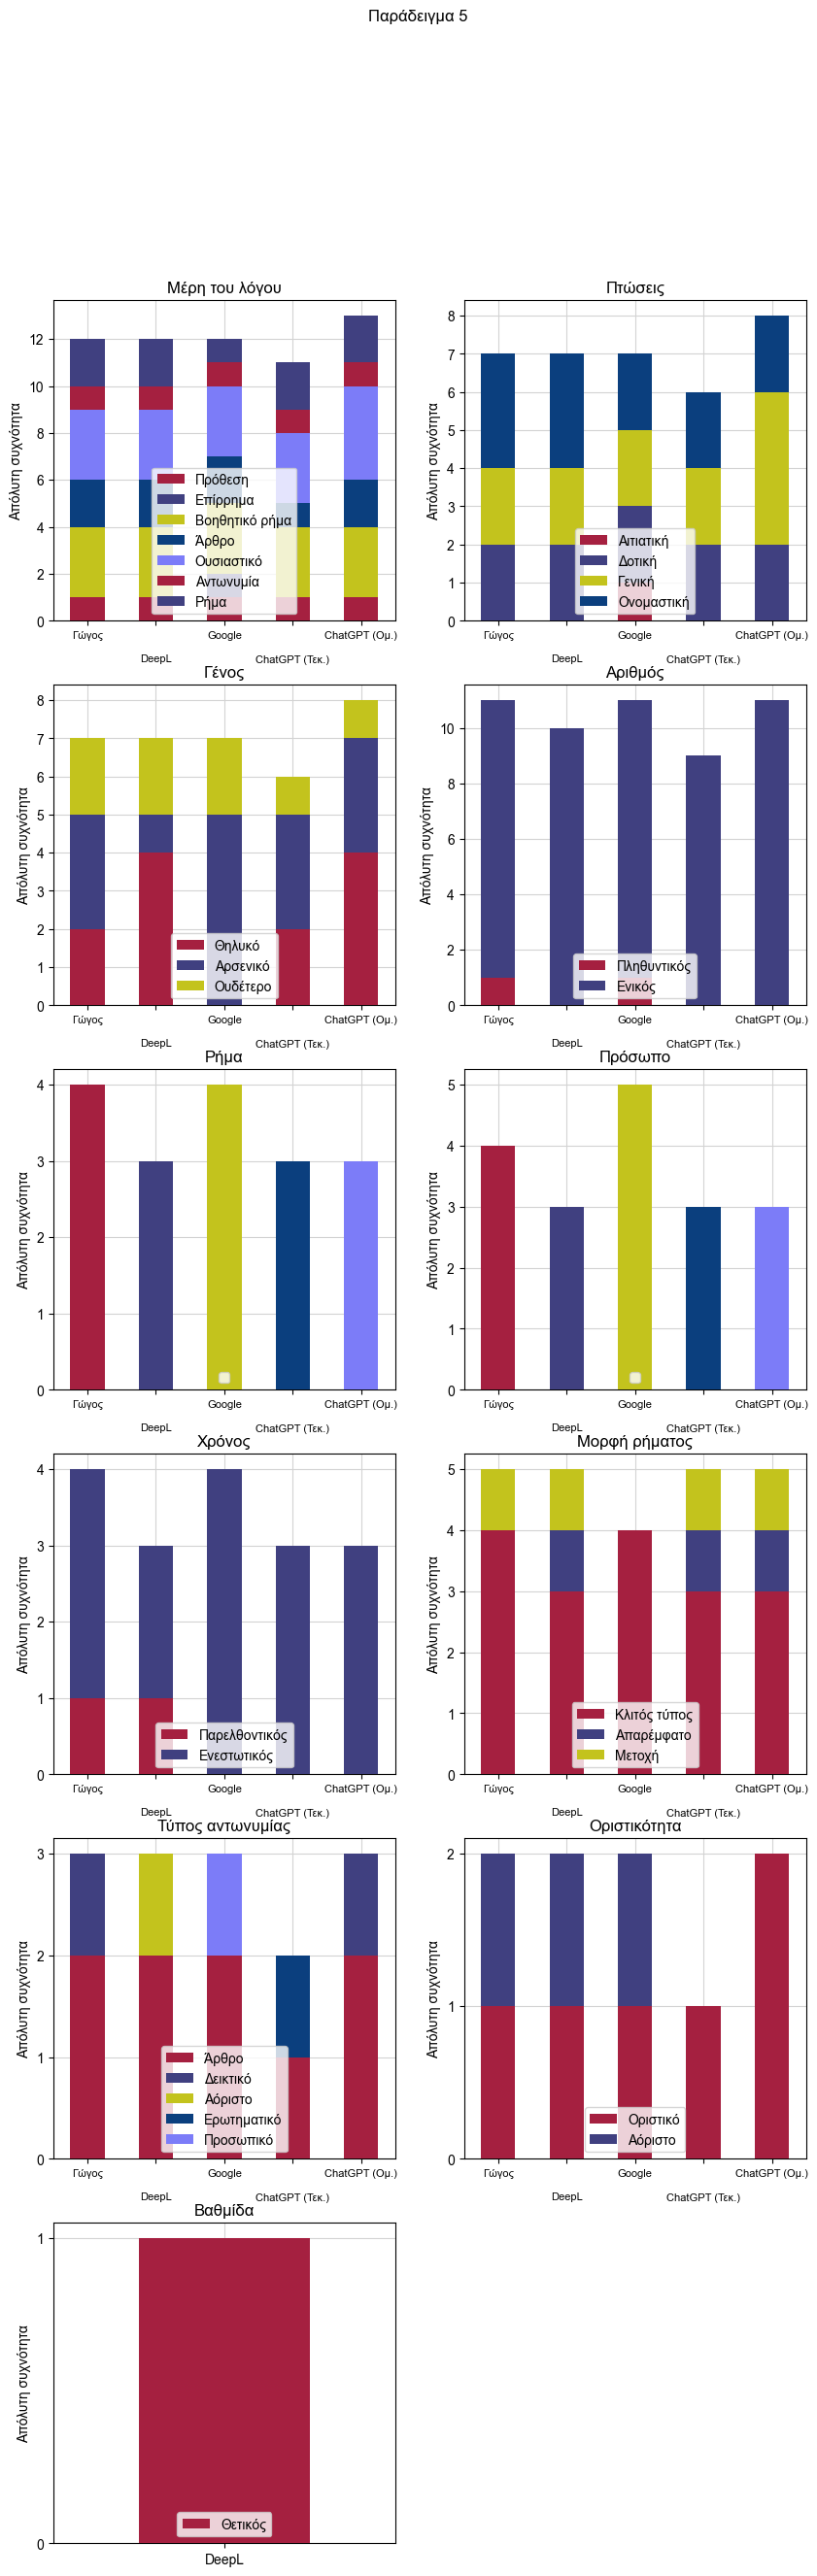

In [24]:
for id, row in analysis_df.groupby('id'):
    print(f"Παράδειγμα {id}:")
    visualizer.visualize_morphology(row, group_by='translator', save=True, long_xlabels=True)

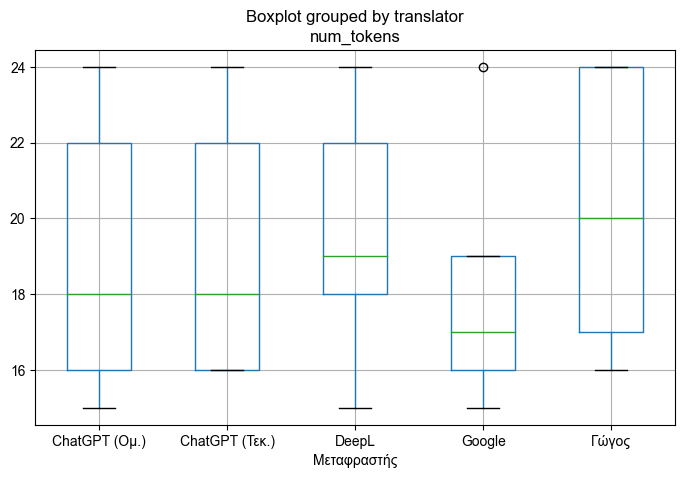

In [25]:
analysis_df.boxplot(column='num_tokens', by='translator', figsize=(8, 5)).set_xlabel('Μεταφραστής');

Μετάφραση: ChatGPT (Ομ.)


id           version     translator           level_1   POS Case Definite  \
4   1  Ομοιολειτουργική  ChatGPT (Ομ.)               der   DET  Gen      Def   
4   1  Ομοιολειτουργική  ChatGPT (Ομ.)         Auslegung  NOUN  Dat      NaN   
4   1  Ομοιολειτουργική  ChatGPT (Ομ.)  Willenserklärung  NOUN  Gen      NaN   

  Gender Number PronType Mood Person Tense VerbForm Degree Poss  
4    Fem   Sing      Art  NaN    NaN   NaN      NaN    NaN  NaN  
4    Fem   Sing      NaN  NaN    NaN   NaN      NaN    NaN  NaN  
4    Fem   Sing      NaN  NaN    NaN   NaN      NaN    NaN  NaN

['POS', 'Case', 'Definite', 'Gender', 'Number', 'PronType', 'Mood', 'Person', 'Tense', 'VerbForm', 'Degree', 'Poss']

Μετάφραση: ChatGPT (Τεκ.)


id       version      translator           level_1   POS Case Definite  \
3   1  Τεκμηριωτική  ChatGPT (Τεκ.)               der   DET  Gen      Def   
3   1  Τεκμηριωτική  ChatGPT (Τεκ.)         Auslegung  NOUN  Dat      NaN   
3   1  Τεκμηριωτική  ChatGPT (Τεκ.)  Willenserklärung  NOUN  Gen      NaN   

  Gender Number PronType Mood Person Tense VerbForm Degree Reflex Poss  
3    Fem   Sing      Art  NaN    NaN   NaN      NaN    NaN    NaN  NaN  
3    Fem   Sing      NaN  NaN    NaN   NaN      NaN    NaN    NaN  NaN  
3    Fem   Sing      NaN  NaN    NaN   NaN      NaN    NaN    NaN  NaN

['POS', 'Case', 'Definite', 'Gender', 'Number', 'PronType', 'Mood', 'Person', 'Tense', 'VerbForm', 'Degree', 'Reflex', 'Poss']

Μετάφραση: DeepL


id     version translator    level_1   POS Case Definite Gender Number  \
1   1  ελλΑΚ-1940      DeepL        der   DET  Nom      Def   Masc   Sing   
1   1  ελλΑΚ-1940      DeepL  Auslegung  NOUN  Dat      NaN    Fem   Sing   
1   1  ελλΑΚ-1940      DeepL      einer   DET  Gen      Ind    Fem   Sing   

  PronType Mood Person Tense VerbForm Degree Poss  
1      Art  NaN    NaN   NaN      NaN    NaN  NaN  
1      NaN  NaN    NaN   NaN      NaN    NaN  NaN  
1      Art  NaN    NaN   NaN      NaN    NaN  NaN

['POS', 'Case', 'Definite', 'Gender', 'Number', 'PronType', 'Mood', 'Person', 'Tense', 'VerbForm', 'Degree', 'Poss']

Μετάφραση: Google


id     version translator           level_1   POS Case Definite Gender  \
2   1  ελλΑΚ-1940     Google               der   DET  Gen      Def    Fem   
2   1  ελλΑΚ-1940     Google         Auslegung  NOUN  Dat      NaN    Fem   
2   1  ελλΑΚ-1940     Google  Willenserklärung  NOUN  Gen      NaN    Fem   

  Number PronType Mood Person Tense VerbForm Degree Poss  
2   Sing      Art  NaN    NaN   NaN      NaN    NaN  NaN  
2   Sing      NaN  NaN    NaN   NaN      NaN    NaN  NaN  
2   Sing      NaN  NaN    NaN   NaN      NaN    NaN  NaN

['POS', 'Case', 'Definite', 'Gender', 'Number', 'PronType', 'Mood', 'Person', 'Tense', 'VerbForm', 'Degree', 'Poss']

Μετάφραση: Γώγος


id     version translator    level_1   POS Case Definite Gender Number  \
0   1  ελλΑΚ-1951      Γώγος        der   DET  Nom      Def   Masc   Sing   
0   1  ελλΑΚ-1951      Γώγος  Auslegung  NOUN  Dat      NaN    Fem   Sing   
0   1  ελλΑΚ-1951      Γώγος      einer   DET  Gen      Ind    Fem   Sing   

  PronType Mood Person Tense VerbForm Degree  
0      Art  NaN    NaN   NaN      NaN    NaN  
0      NaN  NaN    NaN   NaN      NaN    NaN  
0      Art  NaN    NaN   NaN      NaN    NaN

['POS', 'Case', 'Definite', 'Gender', 'Number', 'PronType', 'Mood', 'Person', 'Tense', 'VerbForm', 'Degree']



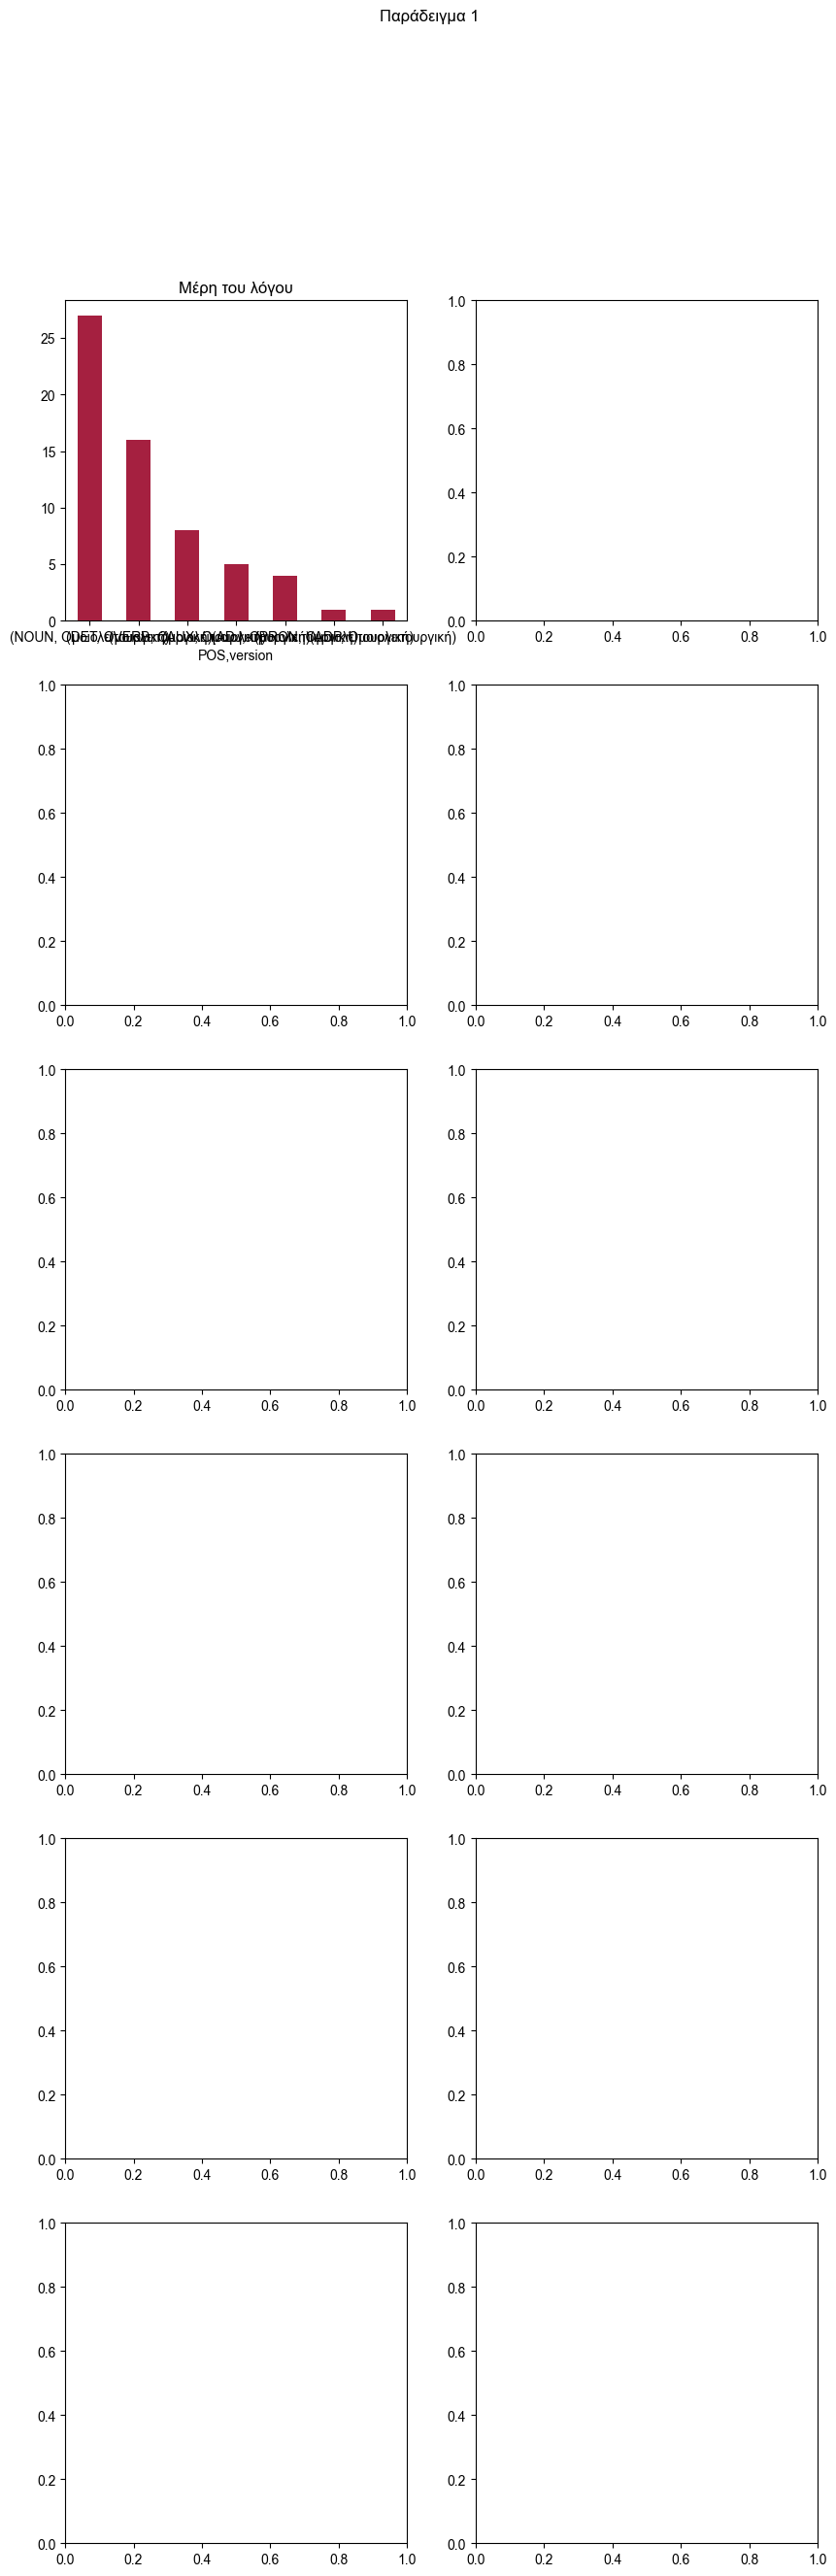

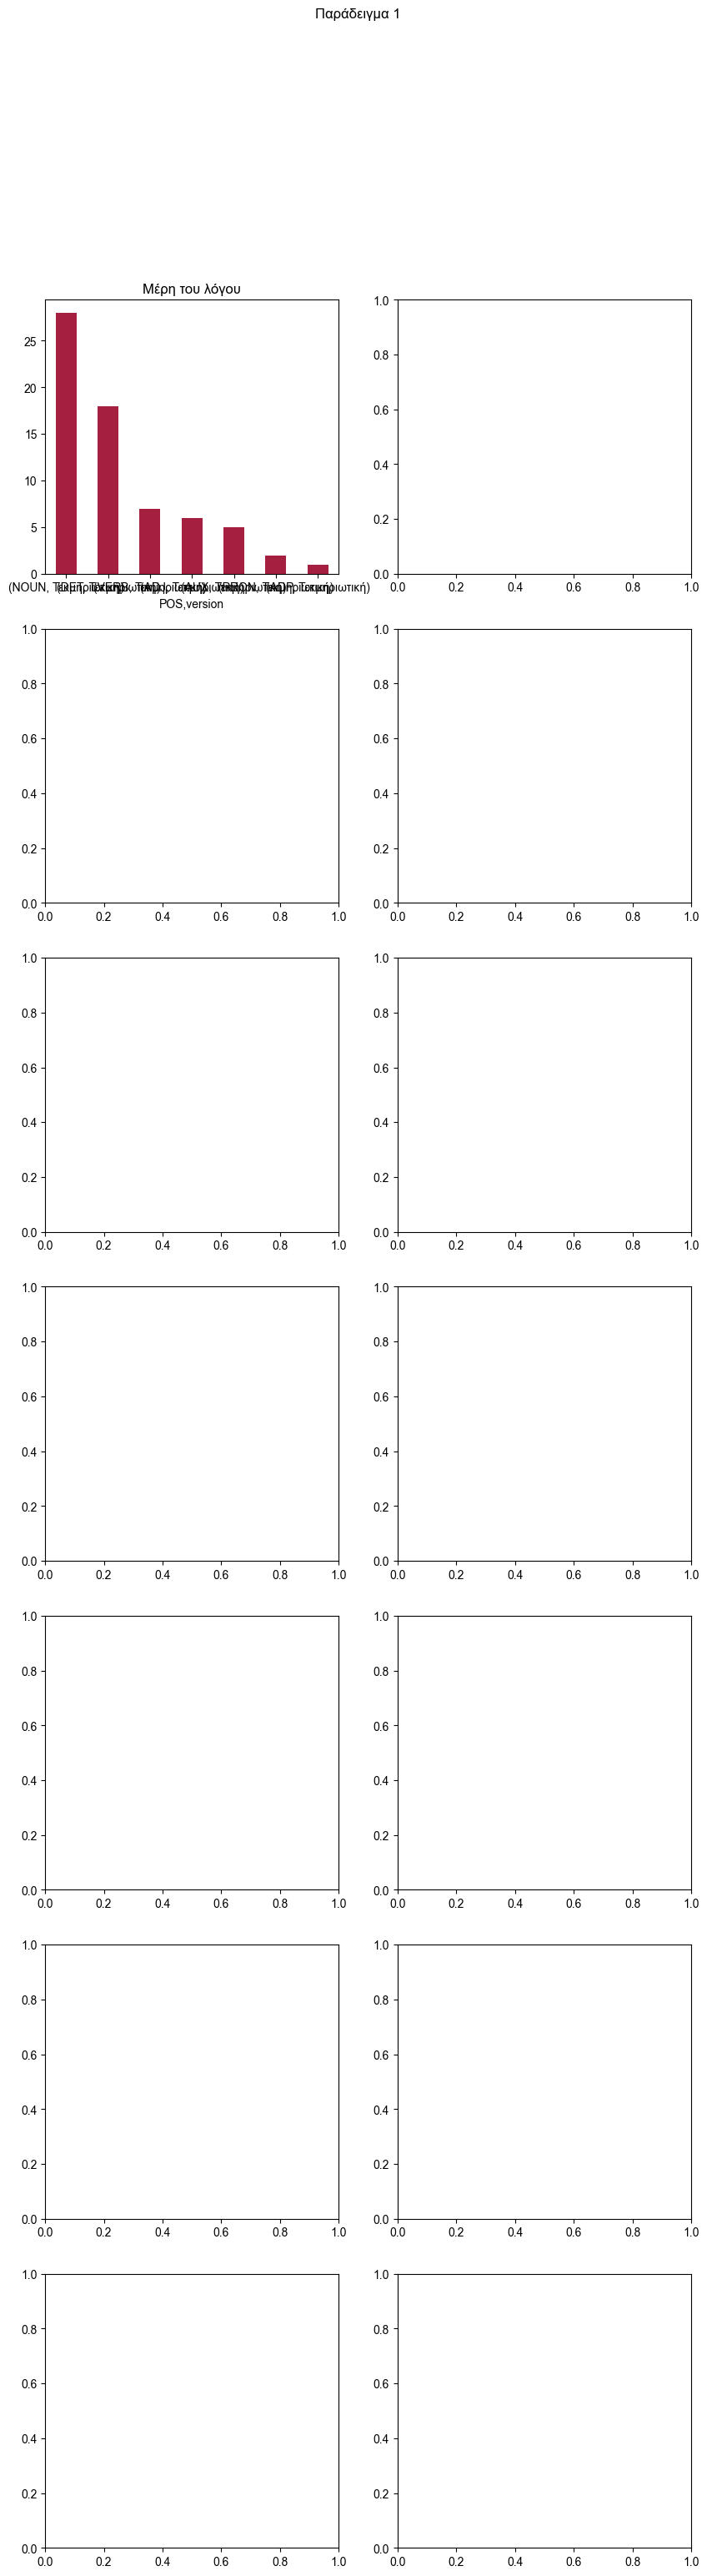

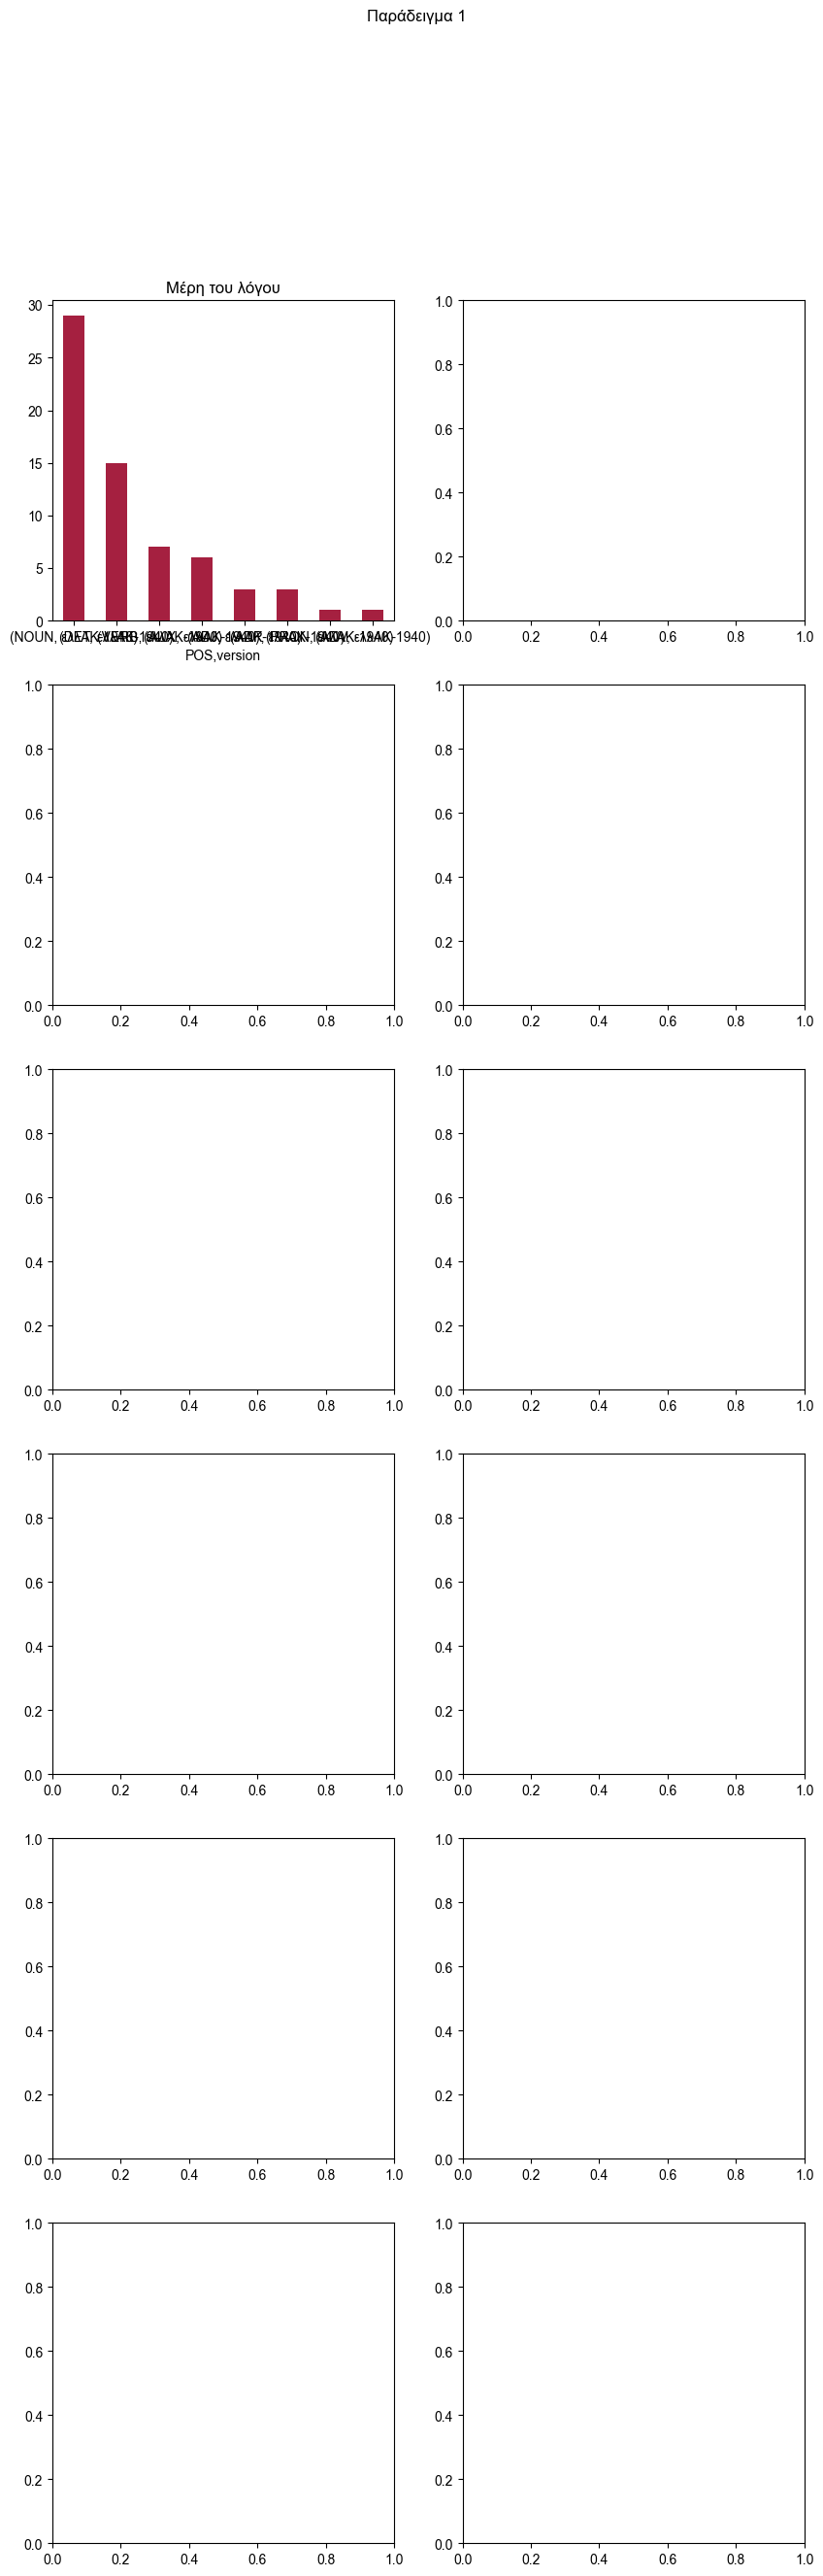

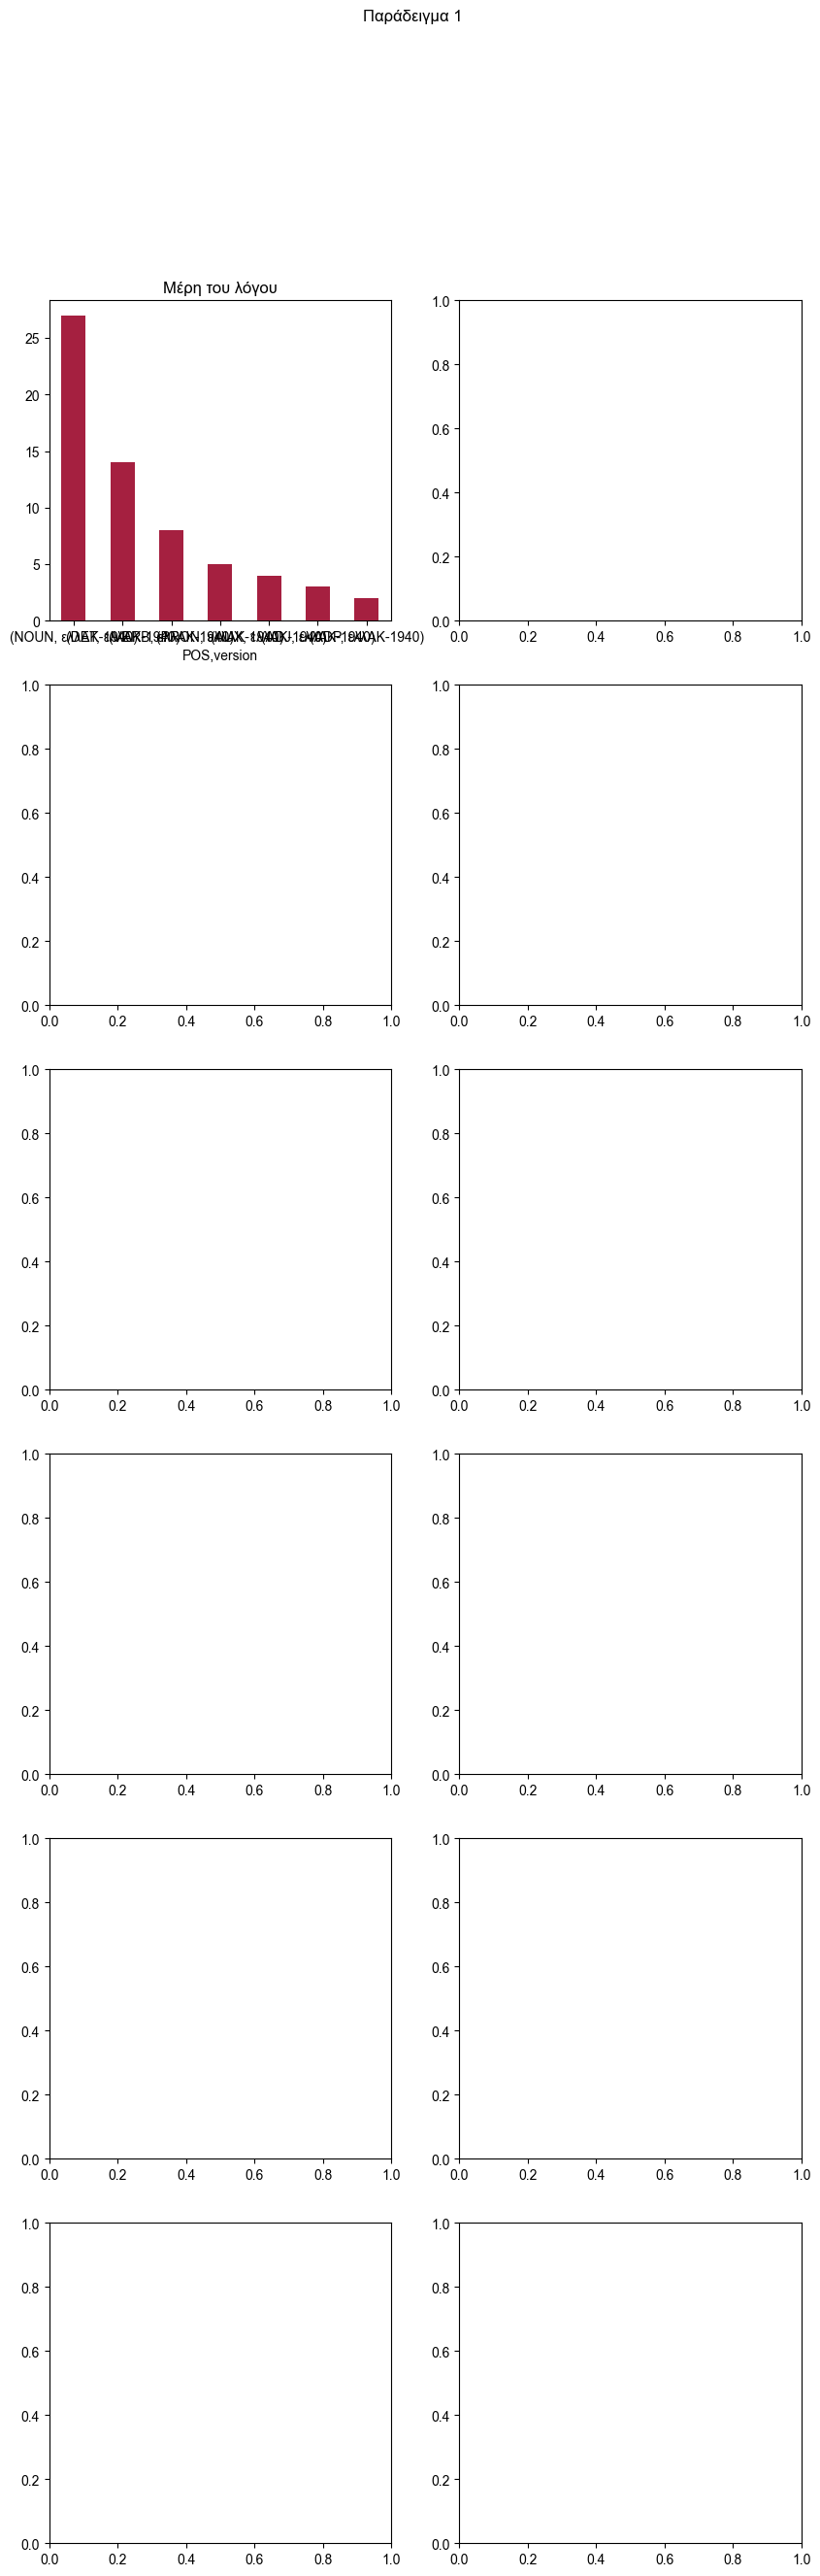

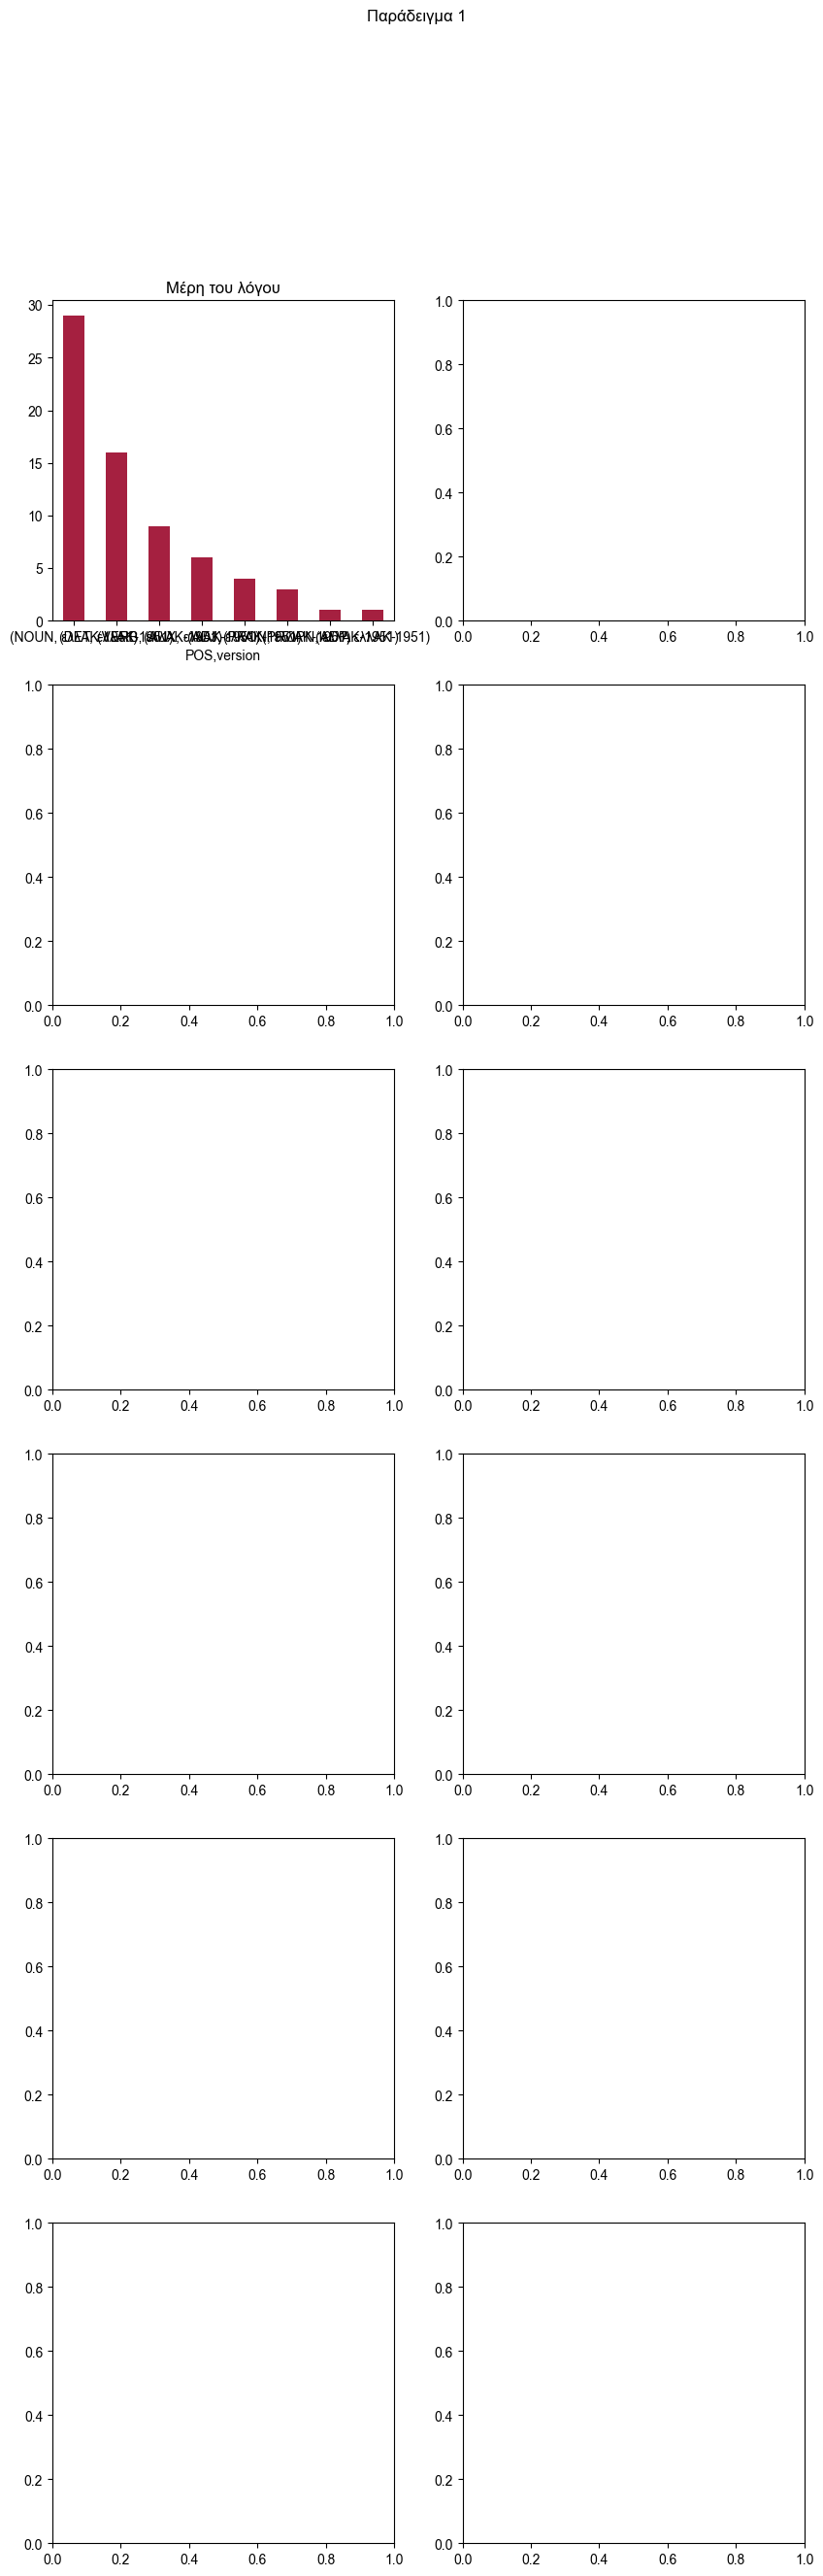

In [26]:
# group by tranlation and visualize the morphology of each one
for translator, group in analysis_df.groupby('translator'):
    print('Μετάφραση:', translator)
    try:
        visualizer.visualize_morphology(group, group_by='version', save=True)
    except ValueError:
        continue

In [27]:
# pos_df_ = pos_df.assign(translation=pos_df['version'].str.split('-').str[-1])
pos_df_ = pos_df.copy()

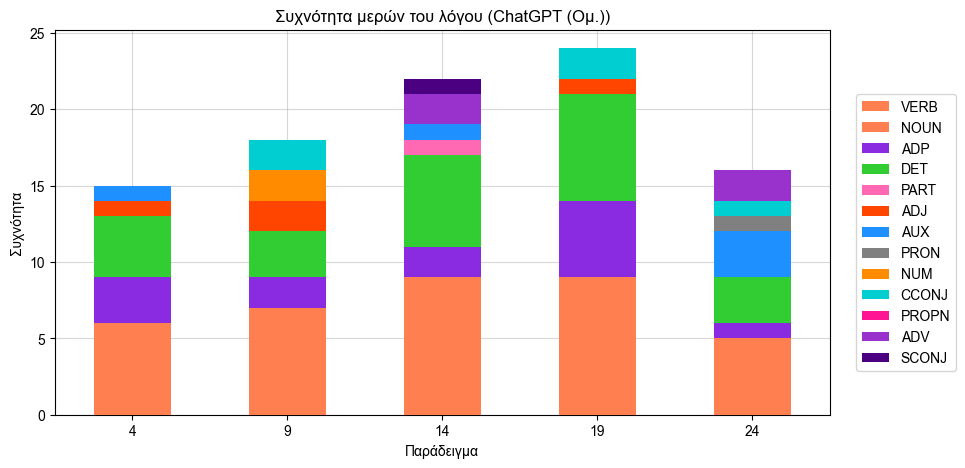

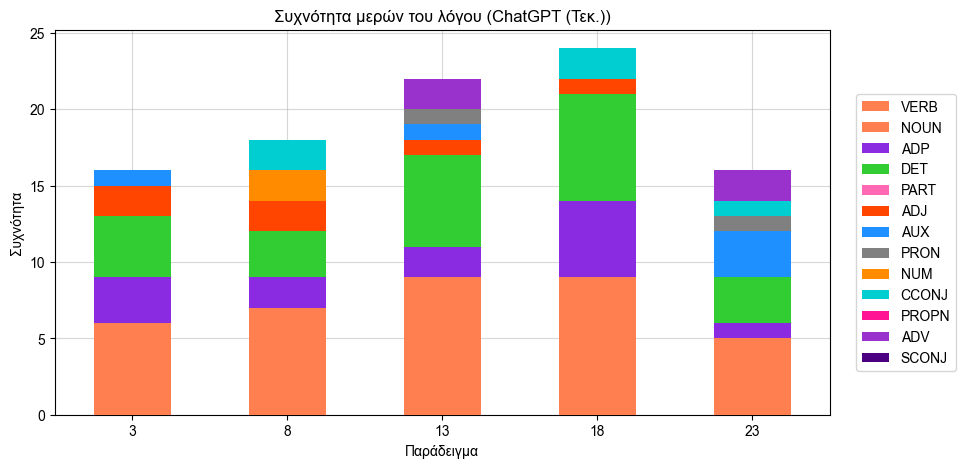

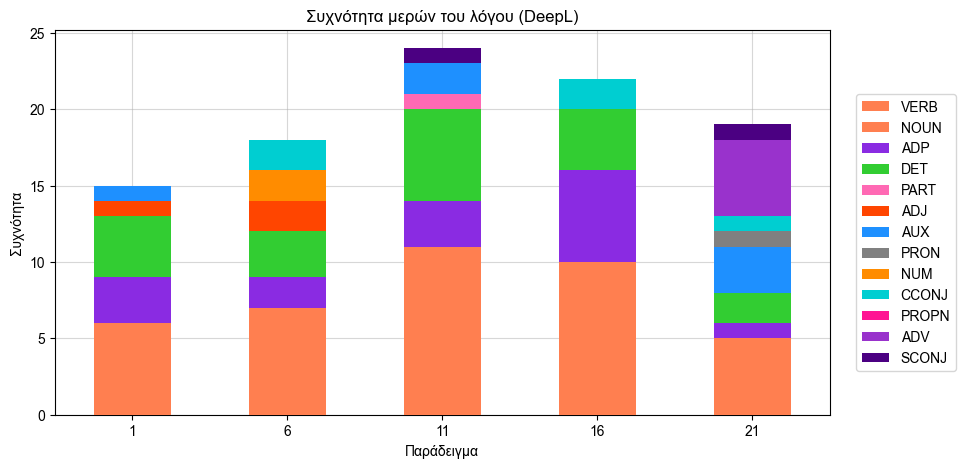

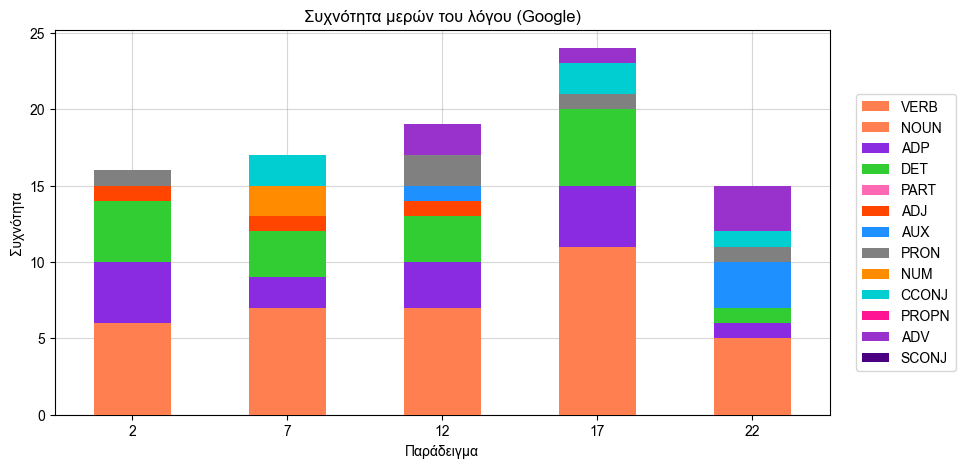

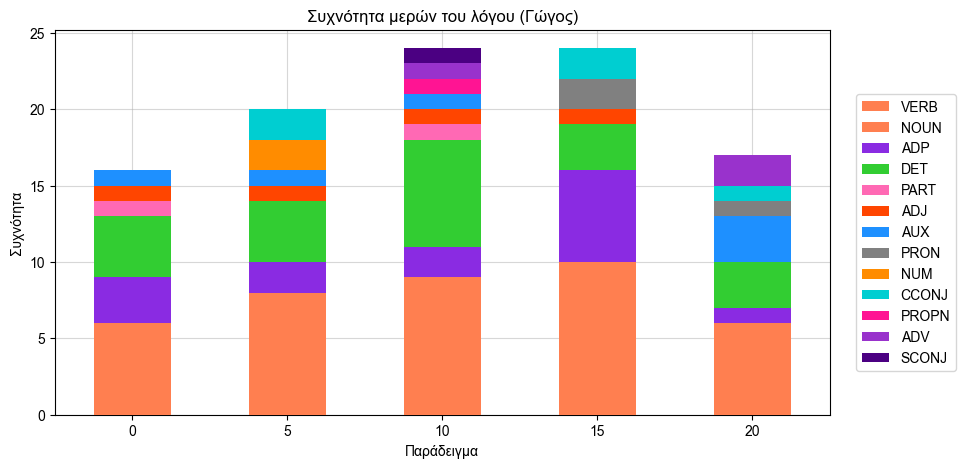

In [28]:
pos_per_translator = (pos_df_
    .drop(columns=[col for col in pos_df.columns if not col.isupper() and col != 'translator'])
    .groupby('translator')
)

for translator, group in pos_per_translator:
    plot = group.plot.bar(title=f'Συχνότητα μερών του λόγου ({translator})', 
                          xlabel='Παράδειγμα', ylabel='Συχνότητα',
                          stacked=True, figsize=(10, 5), rot=0, 
                          color=list(UPOS_COLORS.values()), zorder=10)
    plot.grid(True, zorder=0, alpha=.5)
    plot.legend(bbox_to_anchor=(1.025, .85));

C:\Users\dimboump\AppData\Local\Temp\ipykernel_70692\3738659350.py:64: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show();


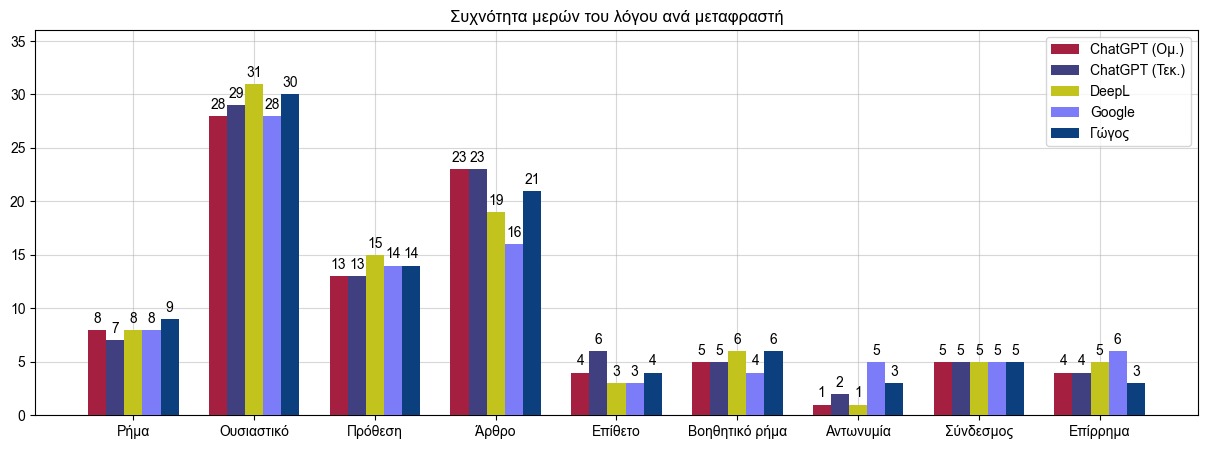

In [29]:
pos_per_version = (pos_df
    .drop(columns=[col for col in pos_df.columns 
                   if not col.isupper() and col != 'version'])
    .groupby('version')
)

# for version, group in pos_per_version:
#     plot = group.plot.bar(title=f'Συχνότητα μερών του λόγου ({version})', 
#                           xlabel='Παράδειγμα', ylabel='Συχνότητα',
#                           stacked=True, figsize=(10, 5), rot=0, 
#                           color=list(UPOS_COLORS.values())[1:], zorder=10)
#     plot.grid(True, zorder=0, alpha=.5)
#     plot.legend(bbox_to_anchor=(1.025, .85));

pos_per_translator = (pos_df_
    .drop(columns=[col for col in pos_df.columns 
                   if not col.isupper() and col != 'translator'])
    .drop(columns=['NUM'])
    .groupby(['translator'])
    .sum()
)

# drop columns whose sum is 0 for any language
pos_per_translator = pos_per_translator.loc[:, (pos_per_translator != 0).all(axis=0)]

fig, ax = plt.subplots(figsize=(15, 5))
# a single bar chart, each POS tag has two bars, one for each language, each
# language has a different color

# the width of each bar
width = .15
# the x locations of the bars
pivot = np.arange(len(pos_per_translator.columns))
# the x locations of the bars
x1, x2, x3, x4, x5 = [[x + width * i for x in pivot] for i in range(5)]

# plot the bars
ax.bar(x1, pos_per_translator.iloc[0], width, label=pos_per_translator.index[0],
            color=list(COLORS.values())[0], zorder=10)
ax.bar(x2, pos_per_translator.iloc[1], width, label=pos_per_translator.index[1],
            color=list(COLORS.values())[1], zorder=10)
ax.bar(x3, pos_per_translator.iloc[2], width, label=pos_per_translator.index[2],
            color=list(COLORS.values())[2], zorder=10)
ax.bar(x4, pos_per_translator.iloc[3], width, label=pos_per_translator.index[3],
            color=list(COLORS.values())[4], zorder=10)
ax.bar(x5, pos_per_translator.iloc[4], width, label=pos_per_translator.index[4],
            color=list(COLORS.values())[3], zorder=10)

# sort the bars by their height
ax.bar_label(ax.containers[0], fmt='%.0f', padding=3)
ax.bar_label(ax.containers[1], fmt='%.0f', padding=3)
ax.bar_label(ax.containers[2], fmt='%.0f', padding=3)
ax.bar_label(ax.containers[3], fmt='%.0f', padding=3)
ax.bar_label(ax.containers[4], fmt='%.0f', padding=3)

# add some text for labels, title and axes ticks
ax.set_title('Συχνότητα μερών του λόγου ανά μεταφραστή')
ax.set_xticks(pivot + width * 2)
ax.set_xticklabels([MORPH_LOC[col] for col in pos_per_translator.columns])
ax.set_ylim(min(pos_per_translator.min()) - 1, round(max(pos_per_translator.max()) + 5))
ax.grid(True, zorder=0, alpha=.5)
ax.legend()
save_fig(fig, name='pos_per_translator.svg', path='translations/parts_of_speech/all', format='svg')
fig.show();

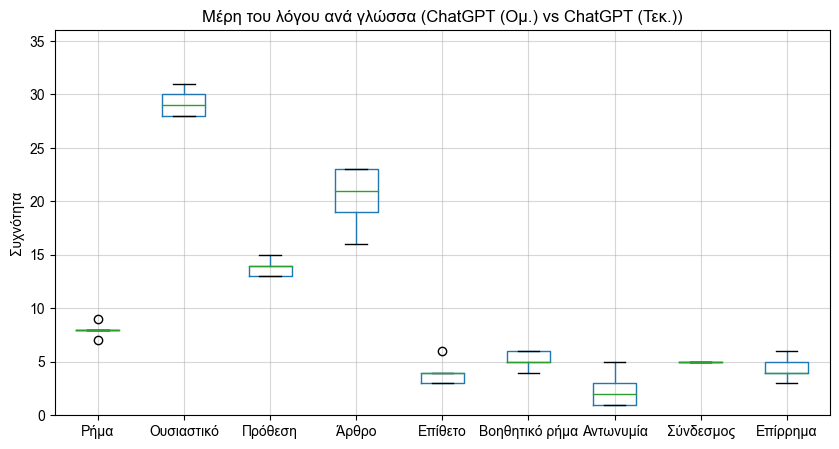

In [30]:
pos_per_translator_clean = pos_per_translator
pos_per_translator_ax = pos_per_translator_clean.boxplot(figsize=(10, 5), return_type='axes')
pos_per_translator_ax.set_title(f'Μέρη του λόγου ανά γλώσσα ({pos_per_translator.index[0]} vs {pos_per_translator.index[1]})')
pos_per_translator_ax.set_ylabel('Συχνότητα')
pos_per_translator_ax.set_ylim(min(pos_per_translator.min()) - 1, round(max(pos_per_translator.max()) + 5))
pos_per_translator_ax.set_xticklabels([MORPH_LOC[col] for col in pos_per_translator_clean.columns])
pos_per_translator_ax.grid(True, zorder=0, alpha=.5)

In [31]:
# get correlation between the frequency of each POS tag and lang
pos_per_translator_corr = (pos_df_
    .drop(columns=[col for col in pos_df_.columns
                     if not col.isupper() and col != 'translator'])
    .groupby('translator')
    .corr()
)

pos_per_translator_corr = pos_per_translator_corr.dropna(axis=0, how='all')
# # set a divider line between the two languages
# divider = pos_per_translator_corr.index.get_loc('DE')
# # get the correlation between the two languages
# corr = pos_per_translator_corr.iloc[divider, :].drop(columns=['X'])
# get the POS tags that are highly correlated between the two languages
pos_per_translator_corr[pos_per_translator_corr > .5].style.background_gradient(cmap='coolwarm').format('{:.5f}')

# export the correlation matrix to an Excel file
pos_per_translator_corr[pos_per_translator_corr > .5].style.background_gradient(cmap='coolwarm').format('{:.5f}').to_excel('pos_per_translator_corr.xlsx')

In [32]:
pos_corr = (pos_df_
    .drop(columns=[col for col in pos_df_.columns
                     if not col.isupper() and col != 'translator'])
    .replace({'translator': {'Γώγος': 0, 'DeepL': 1, 'Google': 2, 'ChatGPT (Τεκ.):': 3, 'ChatGPT (Ομ.):': 4}})
    .corr()
)

display(pos_corr)

# get the correlation among the translators
corr = pos_corr.iloc[0, 1:].to_frame('Συσχέτιση')
corr.style.background_gradient(cmap='coolwarm')


C:\Users\dimboump\AppData\Local\Temp\ipykernel_70692\2352052391.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  .corr()


VERB      NOUN       ADP       DET      PART       ADJ       AUX  \
VERB   1.000000 -0.106668 -0.303933  0.265092  0.670694 -0.540062  0.451506   
NOUN  -0.106668  1.000000  0.766069  0.582532  0.038708  0.134417 -0.734030   
ADP   -0.303933  0.766069  1.000000  0.404228 -0.076812  0.109428 -0.675432   
DET    0.265092  0.582532  0.404228  1.000000  0.463417  0.014684 -0.367494   
PART   0.670694  0.038708 -0.076812  0.463417  1.000000 -0.188982  0.082359   
ADJ   -0.540062  0.134417  0.109428  0.014684 -0.188982  1.000000 -0.612197   
AUX    0.451506 -0.734030 -0.675432 -0.367494  0.082359 -0.612197  1.000000   
PRON   0.066815 -0.141353 -0.005077 -0.395799 -0.327327 -0.324760  0.310019   
NUM   -0.267261  0.044346 -0.257227 -0.279761 -0.218218  0.577350 -0.377415   
CCONJ -0.418330  0.421433  0.242180 -0.170609 -0.487950  0.129099 -0.361682   
PROPN  0.109109  0.131255 -0.105012  0.378977  0.467707  0.058926 -0.007337   
ADV    0.243157 -0.477897 -0.567443 -0.334320 -0.044500 -0.570562  0.736370   
SCONJ  0.524891  0.038708 -0.224526  0.324669  0.702381 -0.346467  0.278451   

           PRON       NUM     CCONJ     PROPN       ADV     SCONJ  
VERB   0.066815 -0.267261 -0.418330  0.109109  0.243157  0.524891  
NOUN  -0.141353  0.044346  0.421433  0.131255 -0.477897  0.038708  
ADP   -0.005077 -0.257227  0.242180 -0.105012 -0.567443 -0.224526  
DET   -0.395799 -0.279761 -0.170609  0.378977 -0.334320  0.324669  
PART  -0.327327 -0.218218 -0.487950  0.467707 -0.044500  0.702381  
ADJ   -0.324760  0.577350  0.129099  0.058926 -0.570562 -0.346467  
AUX    0.310019 -0.377415 -0.361682 -0.007337  0.736370  0.278451  
PRON   1.000000 -0.375000 -0.069877 -0.153093  0.511769 -0.156844  
NUM   -0.375000  1.000000  0.559017 -0.102062 -0.345101 -0.218218  
CCONJ -0.069877  0.559017  1.000000 -0.228218 -0.210455 -0.365963  
PROPN -0.153093 -0.102062 -0.228218  1.000000  0.019212  0.467707  
ADV    0.511769 -0.345101 -0.210455  0.019212  1.000000  0.383382  
SCONJ -0.156844 -0.218218 -0.365963  0.467707  0.383382  1.000000

In [33]:
morph_df = analysis_df[['id', 'version', 'translator', 'morph_features']]
morph_df['morph_features'] = morph_df['morph_features'].apply(json.loads)
morph_df = morph_df.explode('morph_features')
morph_df['morph_features'] = morph_df['morph_features'].apply(json.dumps, ensure_ascii=False)
# Unpack the nested dictionary into separate columns
# morph_df = morph_df.join(pd.json_normalize(morph_df['morph_features']))
morph_df['morph_features'] = morph_df['morph_features'].apply(json.loads).apply(lambda x: x.values())
morph_df = morph_df.explode('morph_features')
morph_df_ = morph_df['morph_features'].apply(pd.Series)

# for i, val in enumerate(morph_df['morph_features'].items()):
#     for _, v in morph_df['morph_features'].items():
#         # print(i+1,v)
#         try:
#             morph_df.at[i, 'morph_features'] = v
#             for morph, j in v.items():
#                 # print(morph, j)
#                 # at given the index i and the morphological feature morph, set the value j to the corresponding cell
#                 morph_df.at[i, morph] = j
#         except AttributeError:
#             continue

            # morph_df = pd.concat([morph_df, pd.DataFrame({k1: v1})], axis=1)
# morph_df['morph_features'] = morph_df['morph_features'].apply(lambda x: [d.values() for d in x])
# morph_df = morph_df.explode('morph_features')
# morph_df['morph_features'] = morph_df['morph_features'].apply(list)
# take the first element of each list and create a new column
# morph_df['pos_tag'] = morph_df['morph_features'].apply(lambda x: x[0])
# morph_df['morph_features'] = morph_df['morph_features'].apply(lambda x: x[1:])
# convert the values of pos_tag column to separate columns
# morph_df = morph_df.explode('morph_features')
# morph_df = morph_df.join(pd.DataFrame(morph_df.pop('pos_tag').tolist(), index=morph_df.index))

# convert the values of morph_features column to separate columns assigned to pos_tag
# morph_df_ = morph_df.pop('morph_features').apply(pd.Series).fillna('')
# morph_df_ = morph_df_.join(morph_df['pos_tag'])
morph_df_ = pd.concat([morph_df, morph_df_], axis=1)
# morph_df_ = morph_df_.join(morph_df['pos_tag'])

# morph_df_ = morph_df_.apply(lambda x: pd.Series(x)).fillna('')
# explode the morph_features column into separate rows
# morph_df_ = pd.concat([morph_df, morph_df_], axis=1)
with pd.option_context('display.max_colwidth', None):
    display(morph_df_.drop(columns=['morph_features']))

C:\Users\dimboump\AppData\Local\Temp\ipykernel_70692\2394679343.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morph_df['morph_features'] = morph_df['morph_features'].apply(json.loads)


id           version     translator   POS Case Definite Gender Number  \
0    1        ελλΑΚ-1951          Γώγος   DET  Nom      Def   Masc   Sing   
0    1        ελλΑΚ-1951          Γώγος  NOUN  Dat      NaN    Fem   Sing   
0    1        ελλΑΚ-1951          Γώγος   DET  Gen      Ind    Fem   Sing   
0    1        ελλΑΚ-1951          Γώγος  NOUN  Gen      NaN    Fem   Sing   
0    1        ελλΑΚ-1951          Γώγος   AUX  NaN      NaN    NaN   Sing   
..  ..               ...            ...   ...  ...      ...    ...    ...   
24   5  Ομοιολειτουργική  ChatGPT (Ομ.)  NOUN  Dat      NaN   Masc   Sing   
24   5  Ομοιολειτουργική  ChatGPT (Ομ.)  NOUN  Gen      NaN    Fem   Sing   
24   5  Ομοιολειτουργική  ChatGPT (Ομ.)  VERB  NaN      NaN    NaN   Sing   
24   5  Ομοιολειτουργική  ChatGPT (Ομ.)  VERB  NaN      NaN    NaN    NaN   
24   5  Ομοιολειτουργική  ChatGPT (Ομ.)   AUX  NaN      NaN    NaN   Sing   

   PronType Mood Person Tense VerbForm Degree Reflex Poss  
0       Art  NaN    NaN   NaN      NaN    NaN    NaN  NaN  
0       NaN  NaN    NaN   NaN      NaN    NaN    NaN  NaN  
0       Art  NaN    NaN   NaN      NaN    NaN    NaN  NaN  
0       NaN  NaN    NaN   NaN      NaN    NaN    NaN  NaN  
0       NaN  Ind      3  Pres      Fin    NaN    NaN  NaN  
..      ...  ...    ...   ...      ...    ...    ...  ...  
24      NaN  NaN    NaN   NaN      NaN    NaN    NaN  NaN  
24      NaN  NaN    NaN   NaN      NaN    NaN    NaN  NaN  
24      NaN  Ind      3  Pres      Fin    NaN    NaN  NaN  
24      NaN  NaN    NaN   NaN     Part    NaN    NaN  NaN  
24      NaN  Ind      3  Past      Fin    NaN    NaN  NaN  

[326 rows x 16 columns]

Μεταφραστής: ChatGPT (Ομ.)


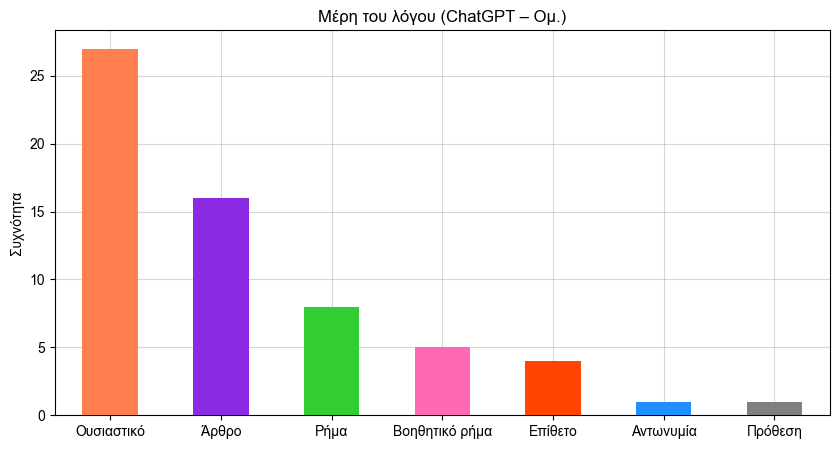

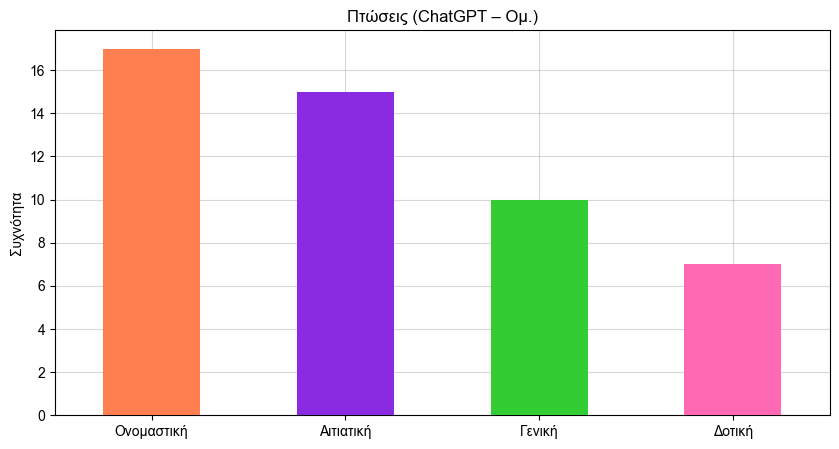

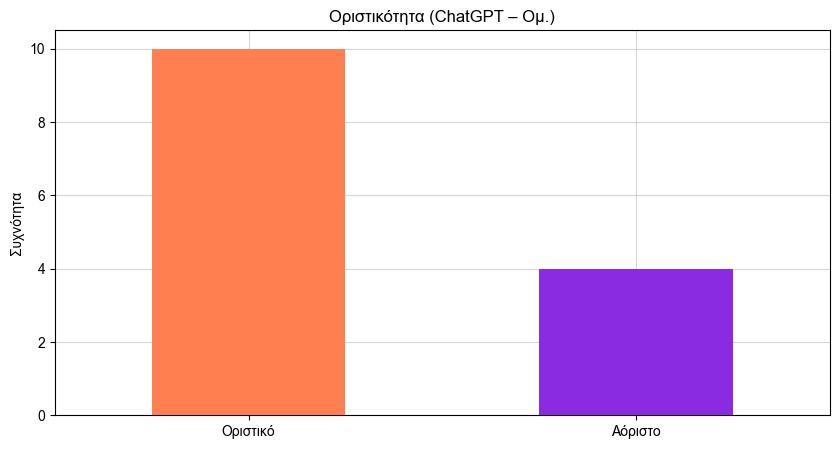

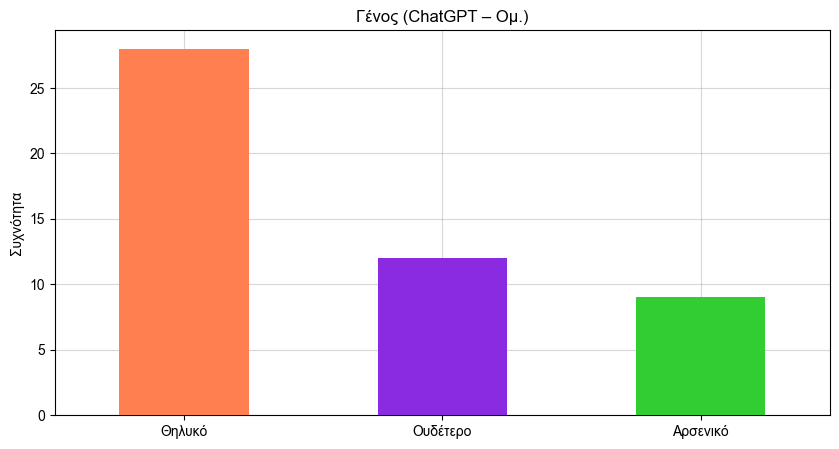

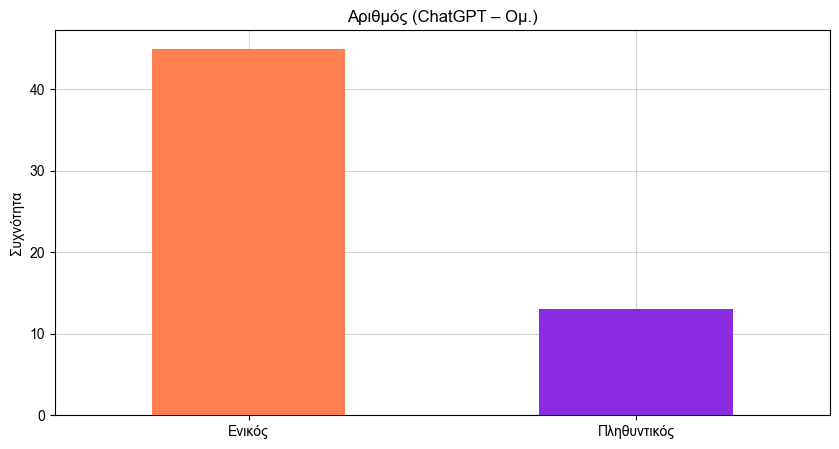

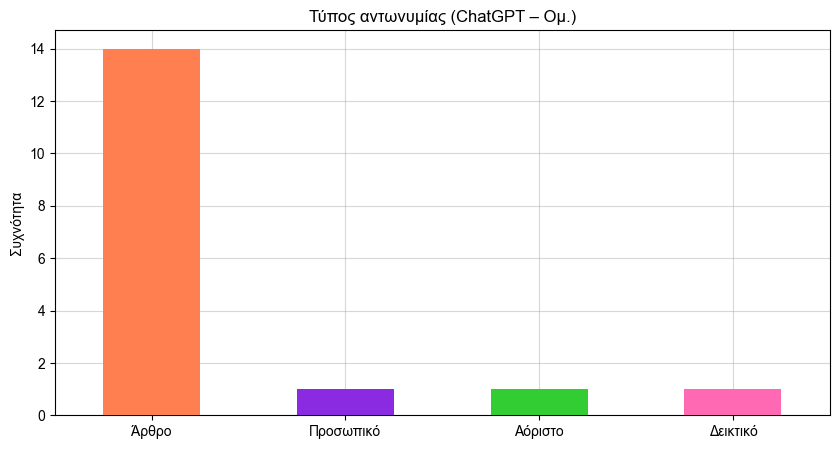

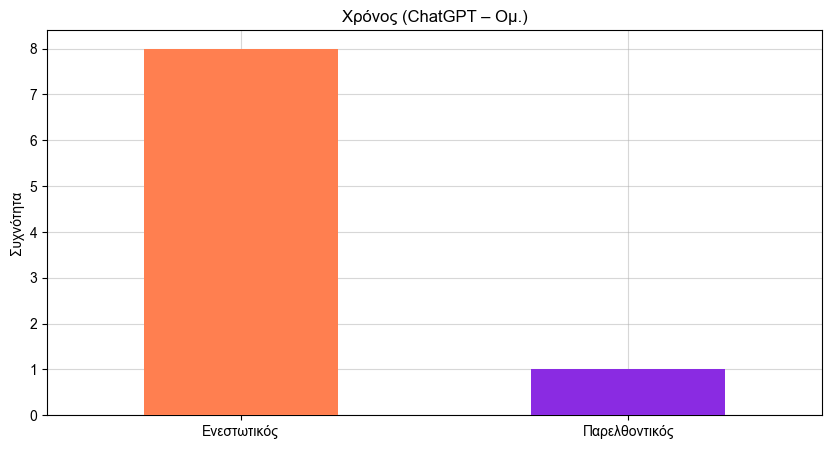

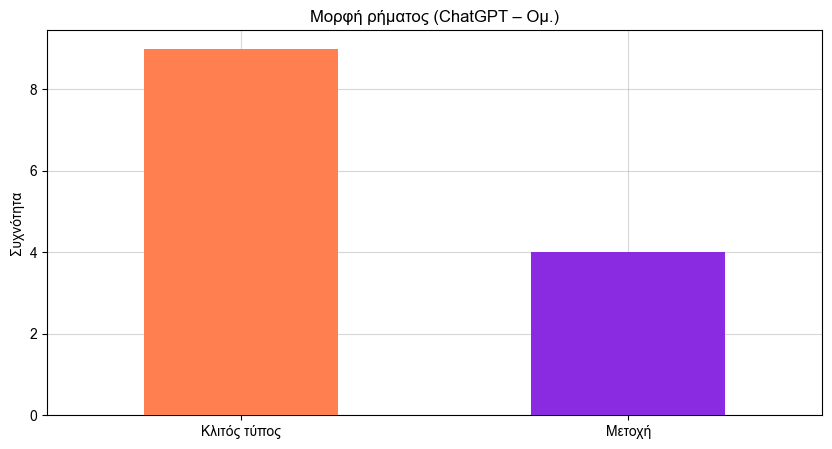

Μεταφραστής: ChatGPT (Τεκ.)


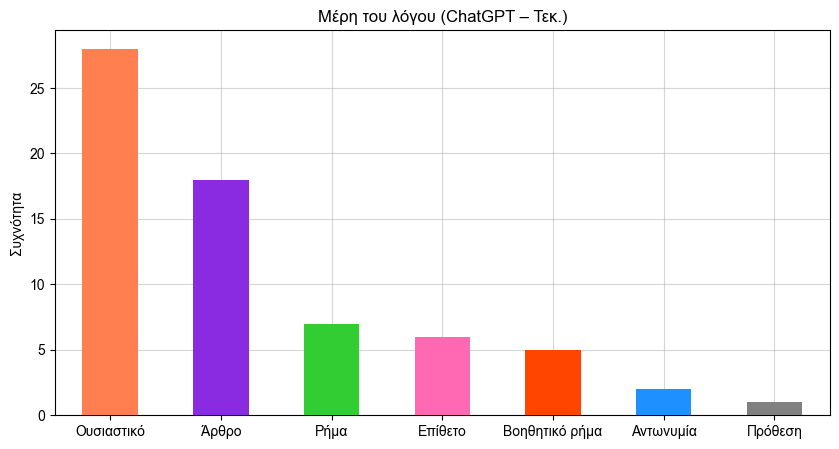

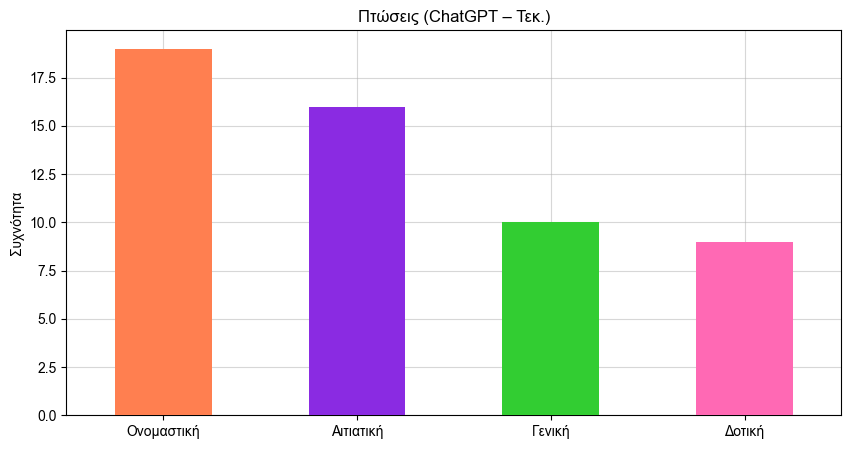

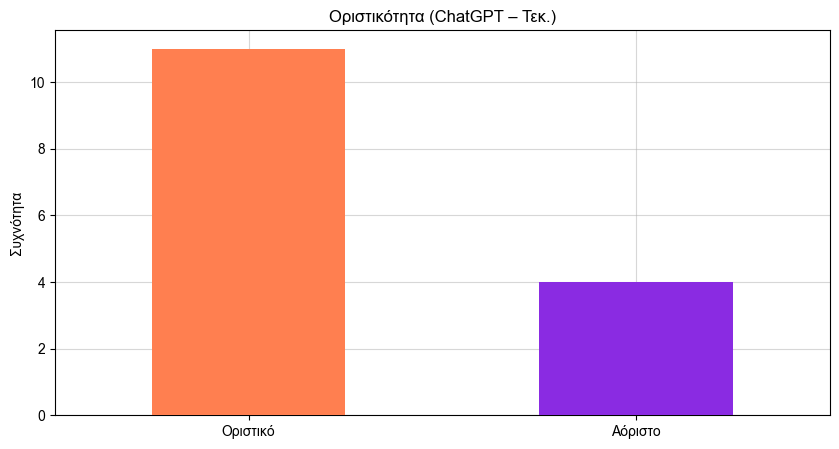

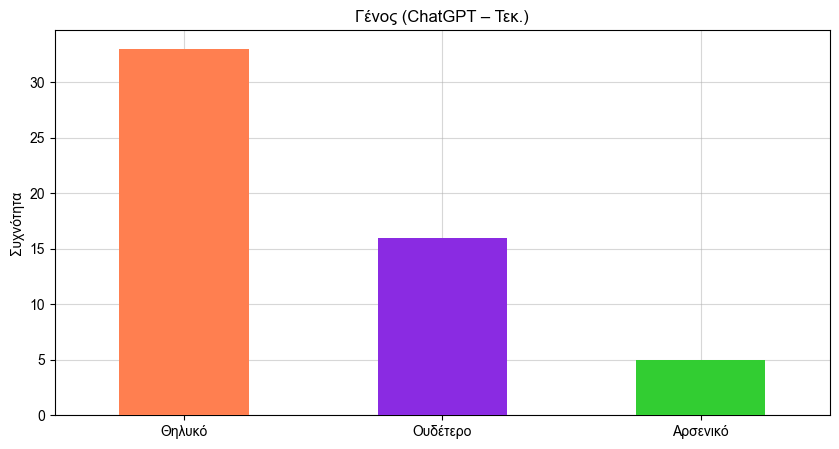

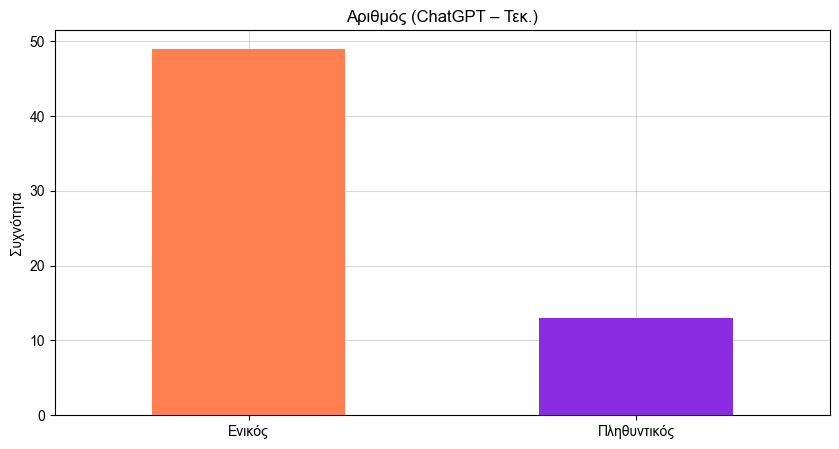

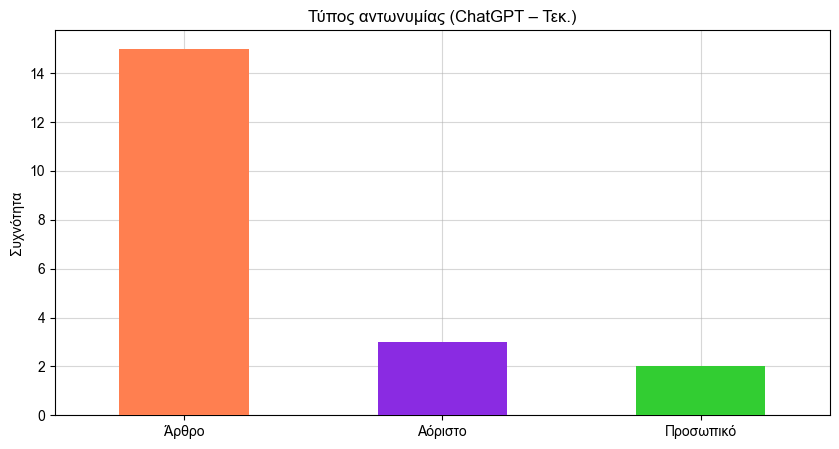

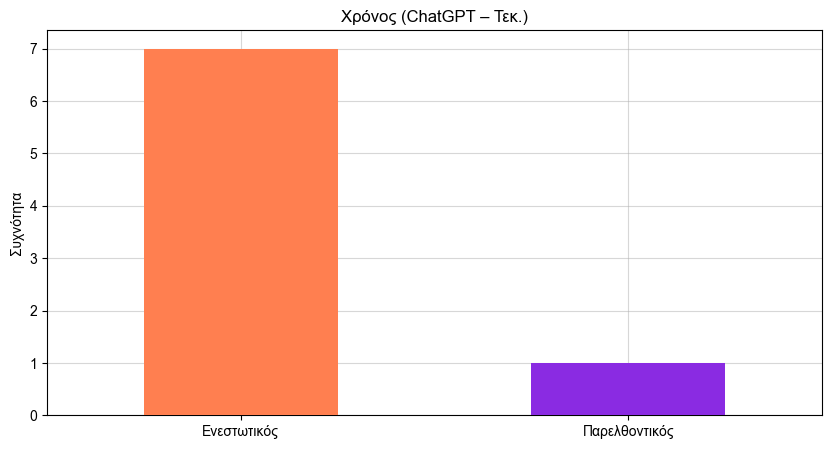

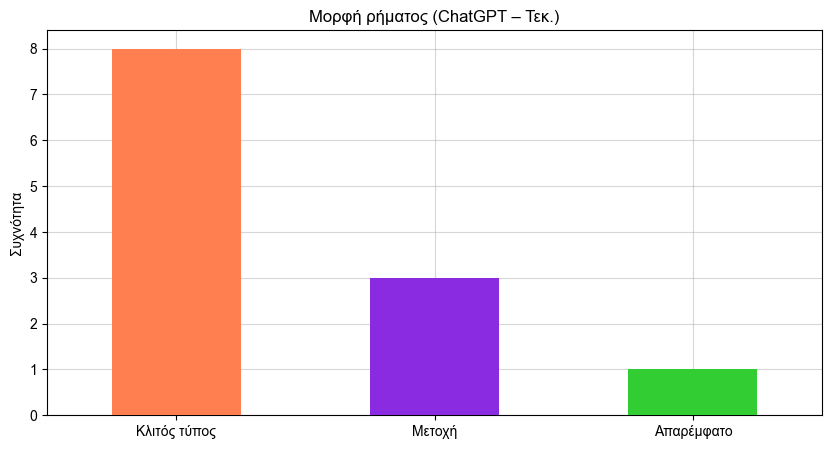

Μεταφραστής: DeepL


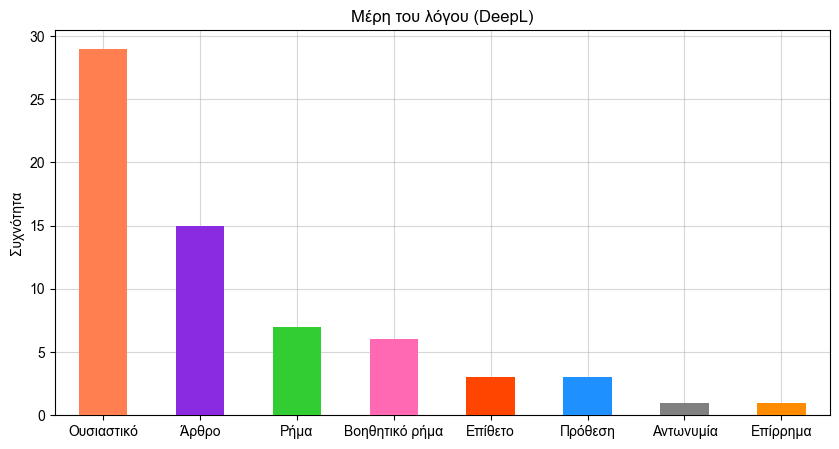

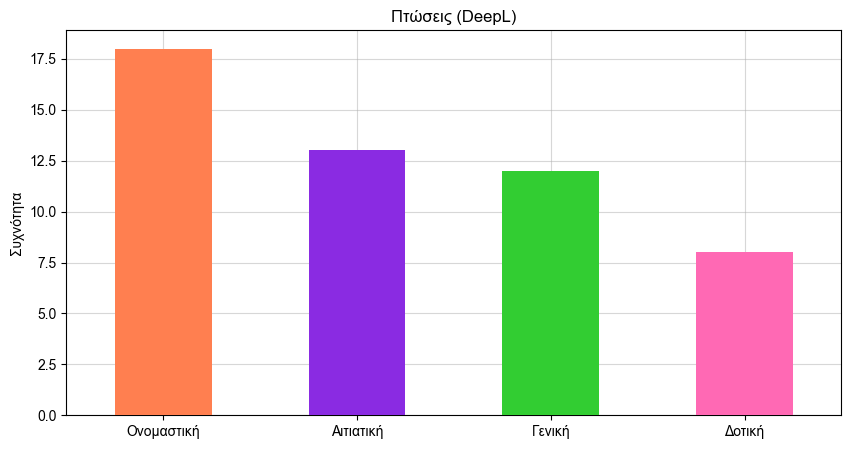

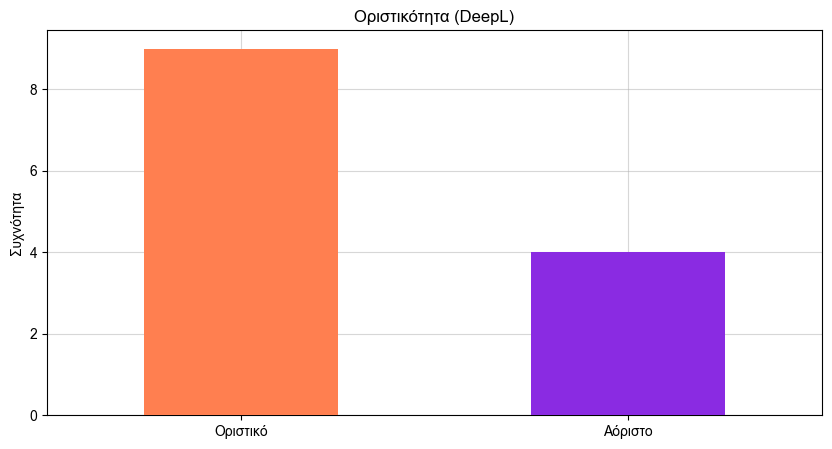

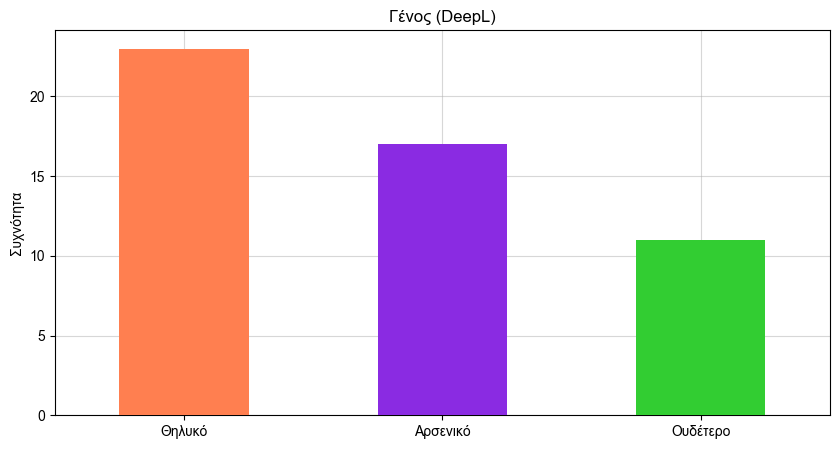

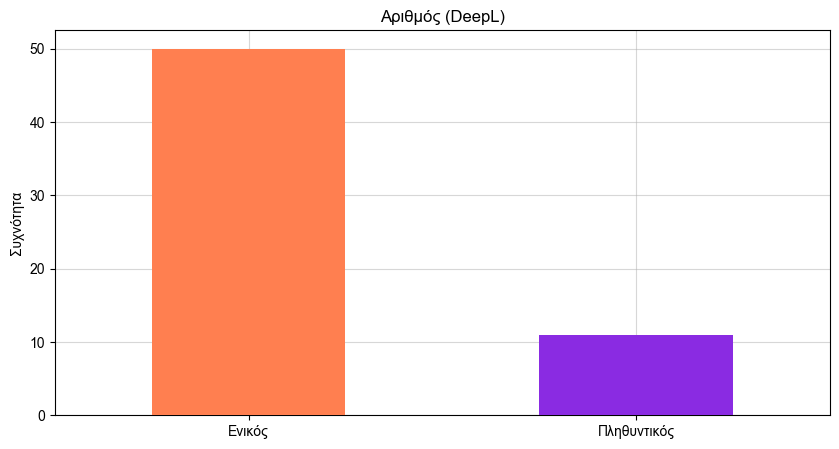

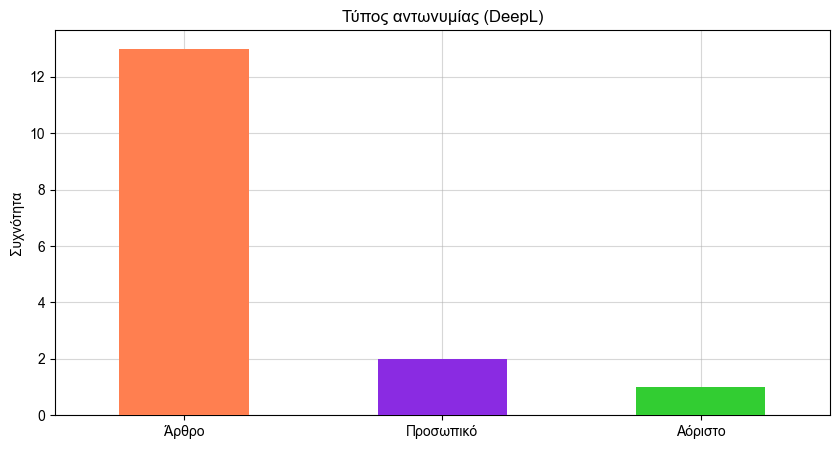

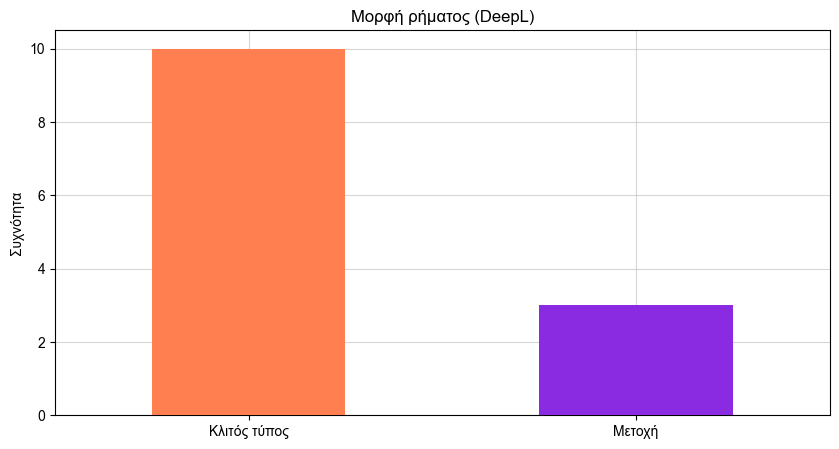

Μεταφραστής: Google


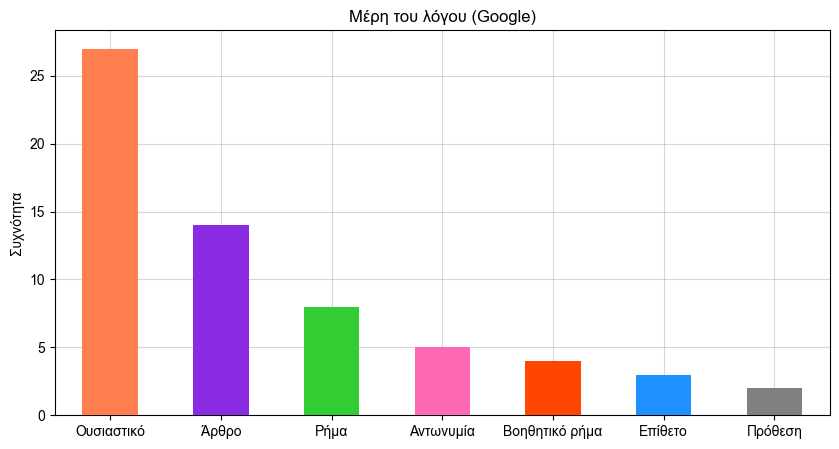

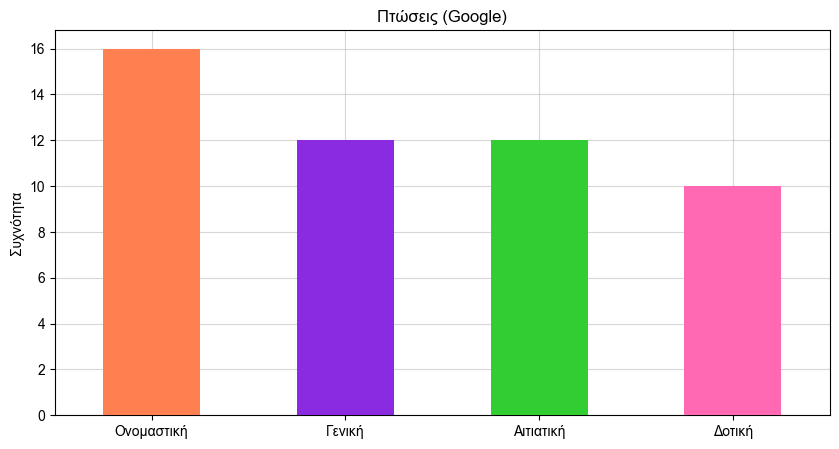

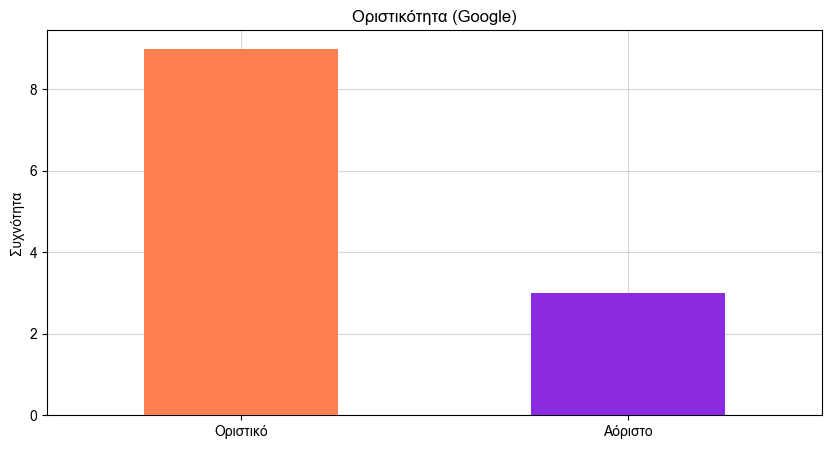

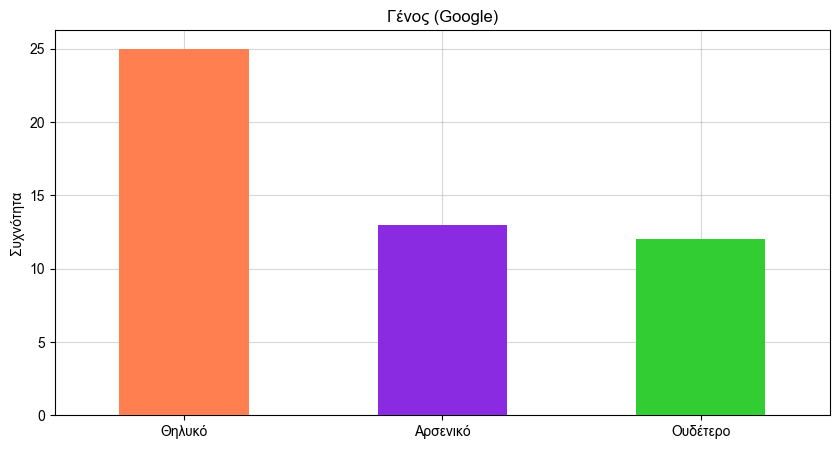

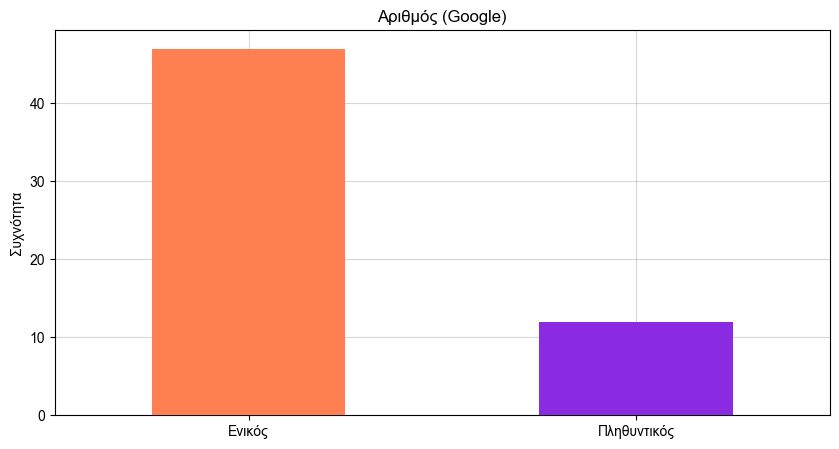

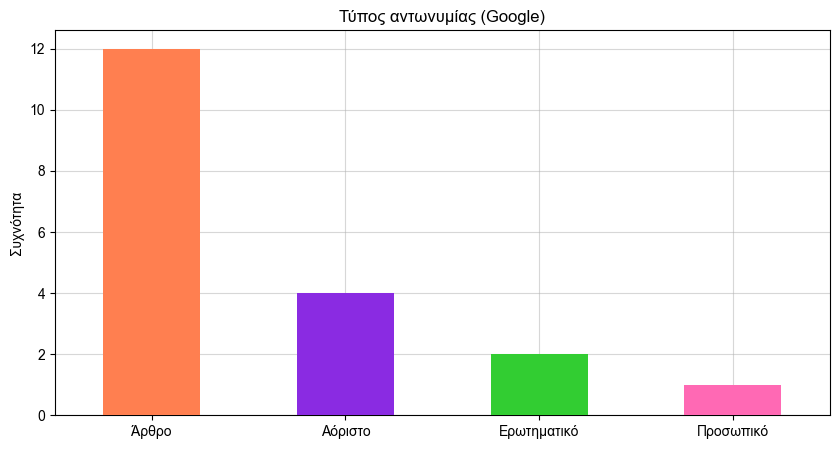

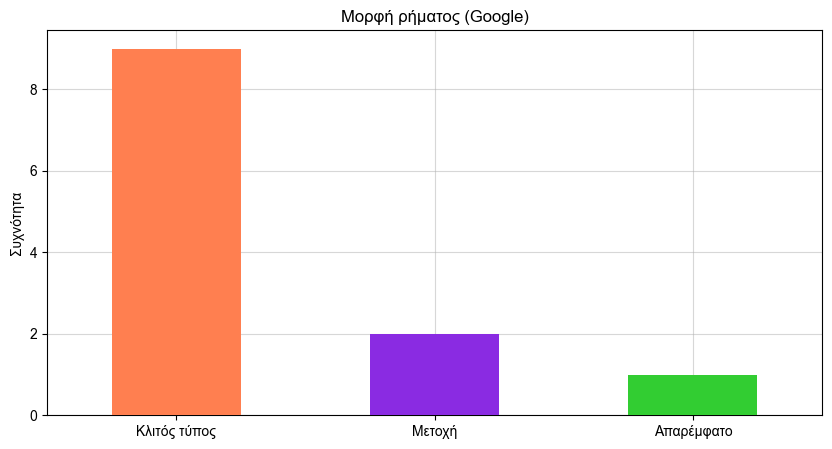

Μεταφραστής: Γώγος


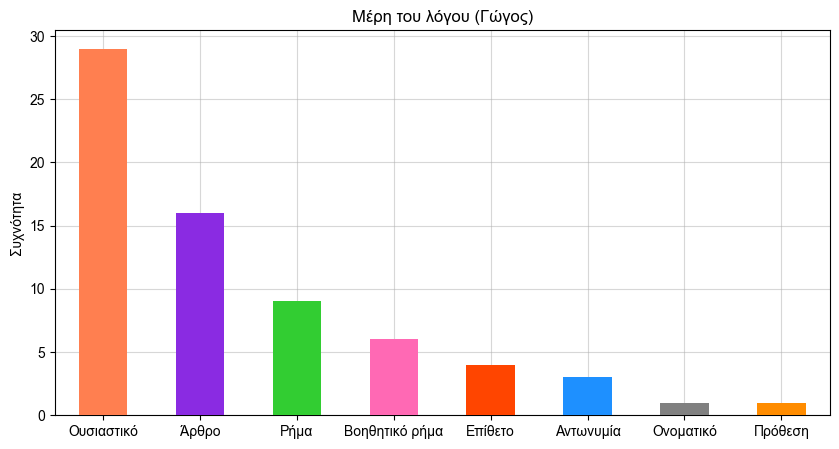

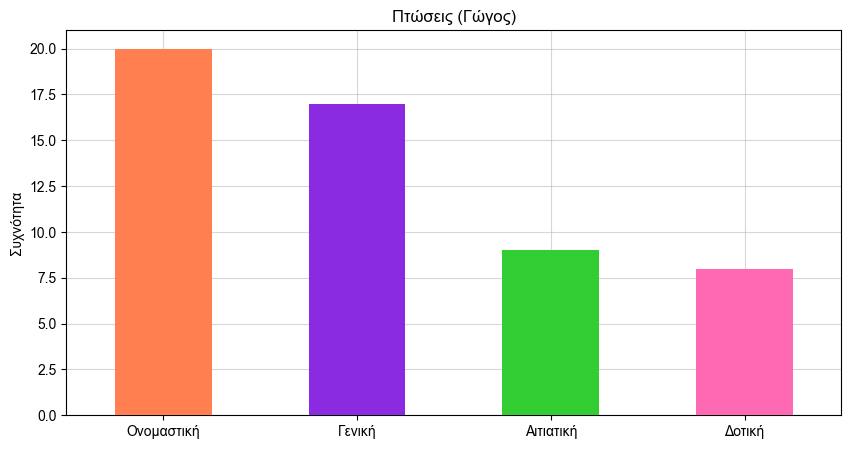

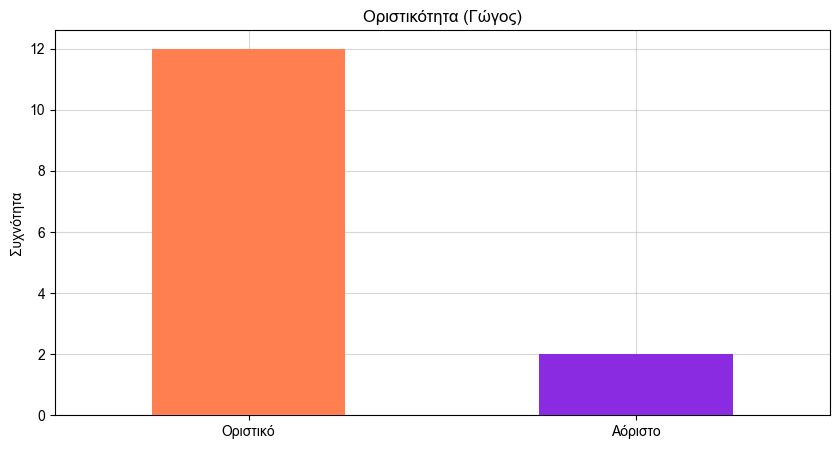

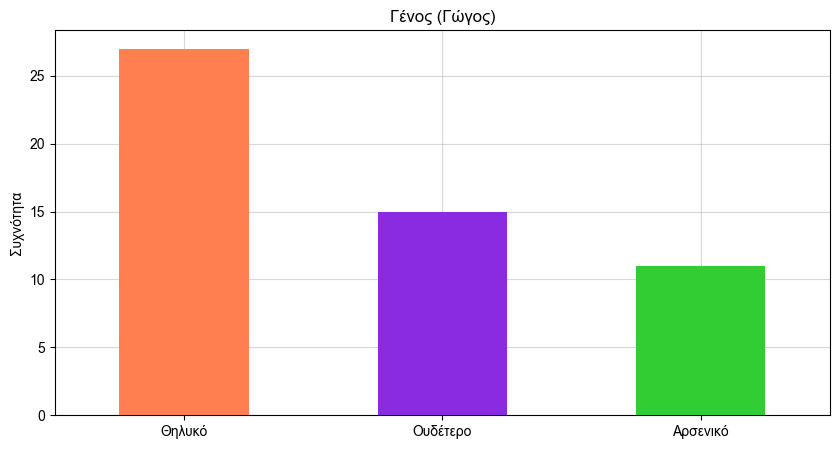

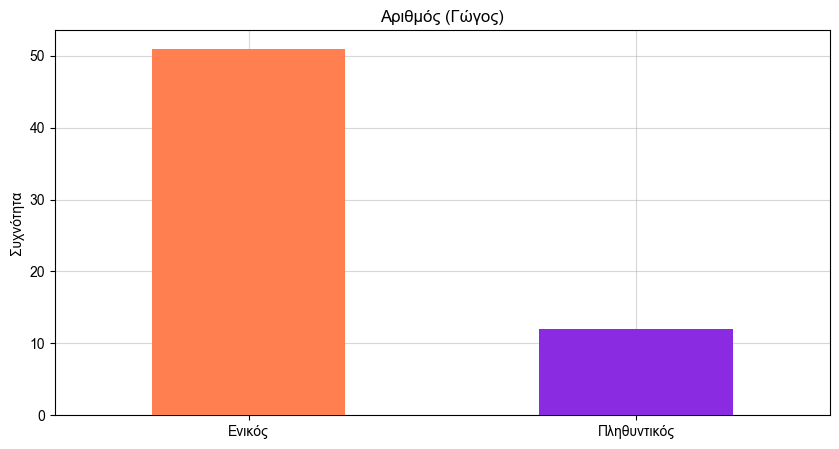

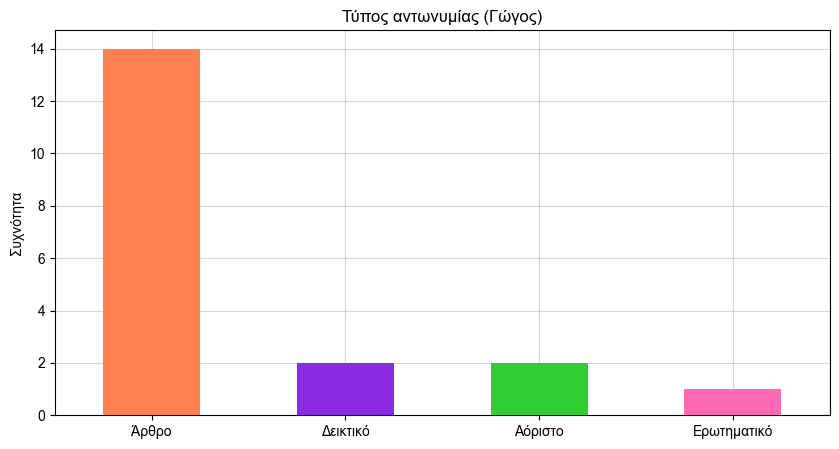

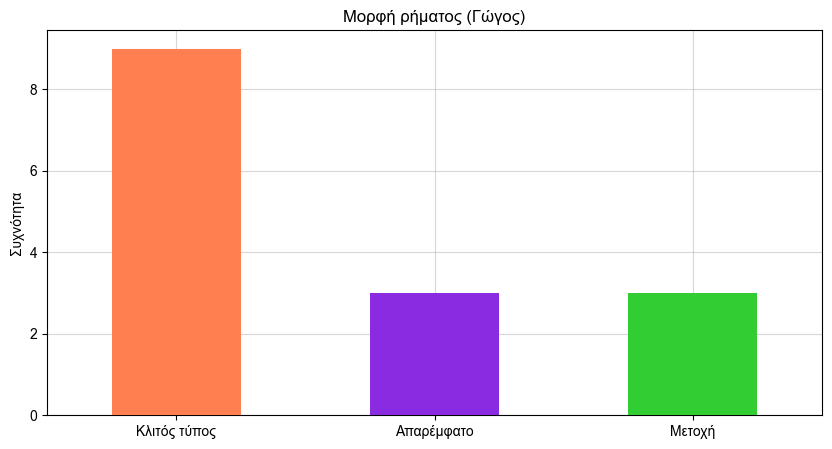

In [34]:
# plot the frequency of each morphological feature per language and version
for (translator, version), group in morph_df_.groupby(['translator', 'version']):
    print(f'Μεταφραστής: {translator}')
    translator = translator.replace('(', '– ').replace(')', '')
    cols = [col for col in group.columns
            if col[0].isupper() and len(group[col].value_counts()) >= 2]
    for col in cols:
        morph = MORPH_LOC.get(col, col)
        vcs = group[col].map(MORPH_LOC.get).value_counts()
        fig, ax = plt.subplots(figsize=(10, 5))
        plot = vcs.plot.bar(title=f'{morph} ({translator})',
                            ylabel='Συχνότητα', rot=0,
                            color=list(UPOS_COLORS.values())[1:], zorder=10)
        plot.grid(True, zorder=0, alpha=.5)
        save_fig(fig, f"{translator.replace(' –', '_').replace(' Ομ.', '').replace(' Τεκ.', '')}_{version}", 
                 path=f'translations/morphology/{col}', format='svg')
        plt.show();

Μεταφραστής: ChatGPT (Ομ.)


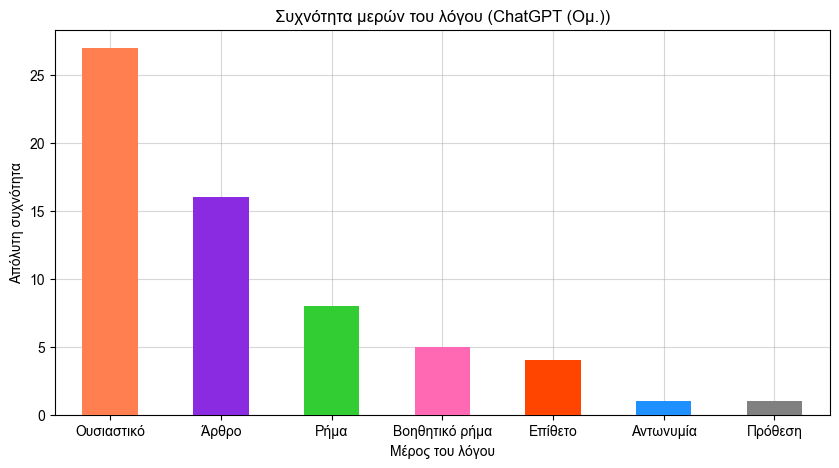

Μεταφραστής: ChatGPT (Τεκ.)


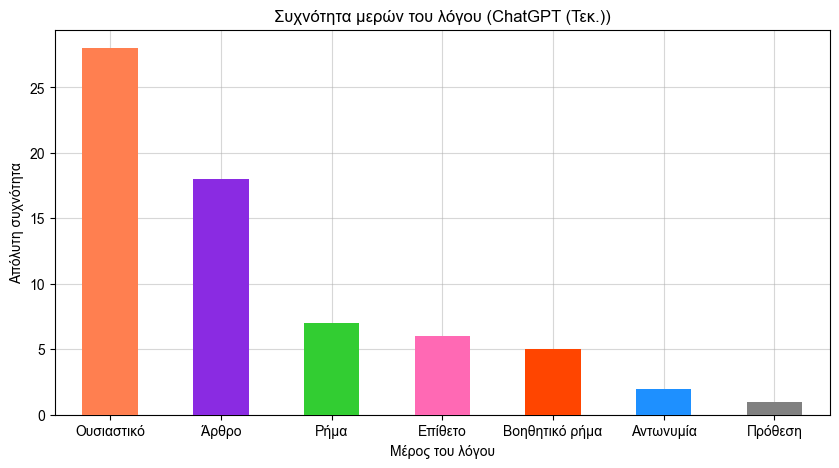

Μεταφραστής: DeepL


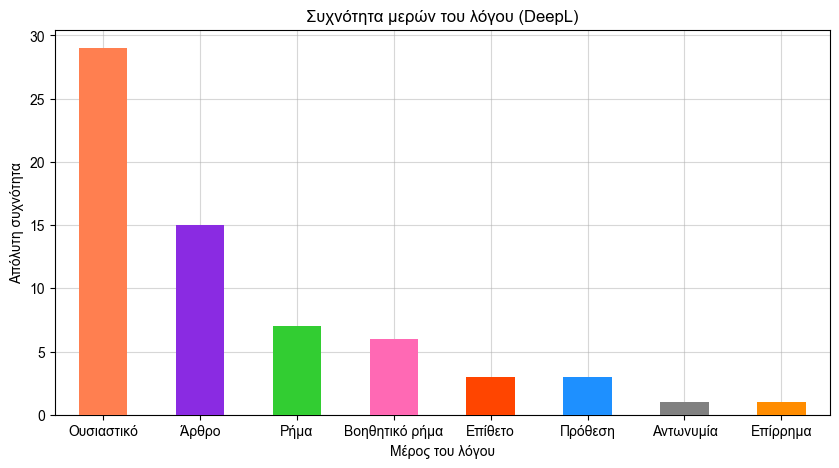

Μεταφραστής: Google


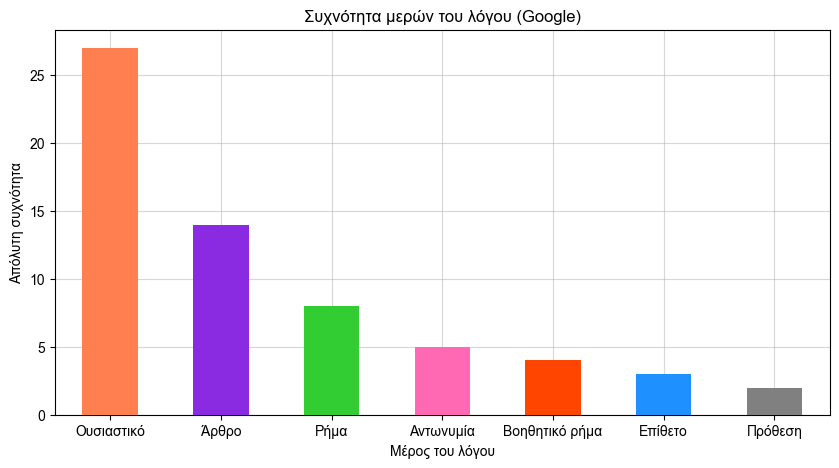

Μεταφραστής: Γώγος


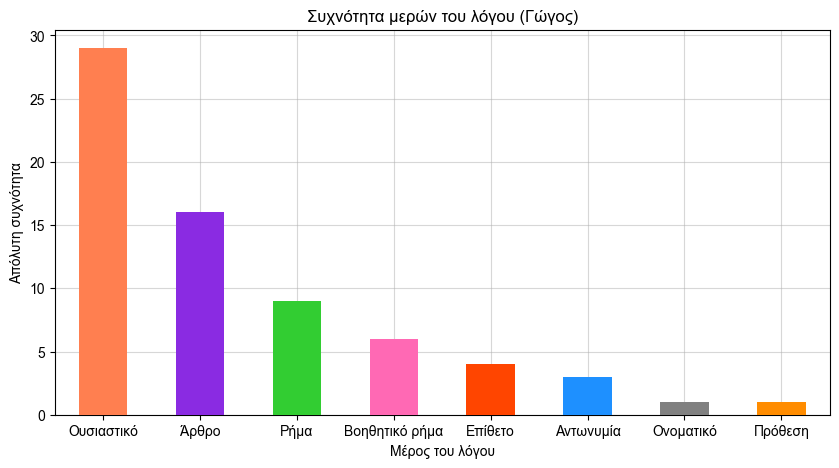

In [35]:
# plot the frequency of each morphological feature per translator
for translator, group in morph_df_.groupby('translator'):
    print('Μεταφραστής:', translator)
    vcs = group['POS'].map(MORPH_LOC.get).value_counts()
    fig, ax = plt.subplots(figsize=(10, 5))
    plot = vcs.plot.bar(title=f'Συχνότητα μερών του λόγου ({translator})',
                        xlabel='Μέρος του λόγου', ylabel='Απόλυτη συχνότητα', 
                        rot=0, color=list(UPOS_COLORS.values())[1:], zorder=10)
    plot.grid(True, zorder=0, alpha=.5)
    save_fig(fig, f"{translator.replace(' –', '_').replace(' Ομ._', '').replace(' Τεκ._', '')}", 
             path=f'translations/parts_of_speech/all', format='svg')
    plt.show();

Μεταφραστής: ChatGPT (Ομ.)


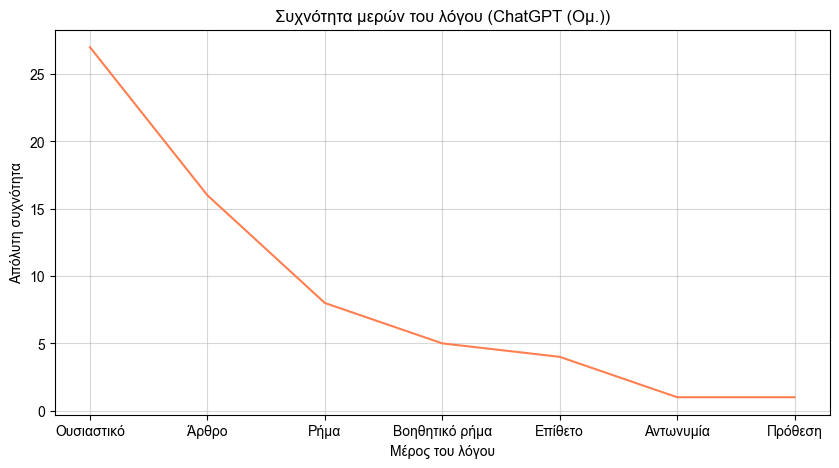

Μεταφραστής: ChatGPT (Τεκ.)


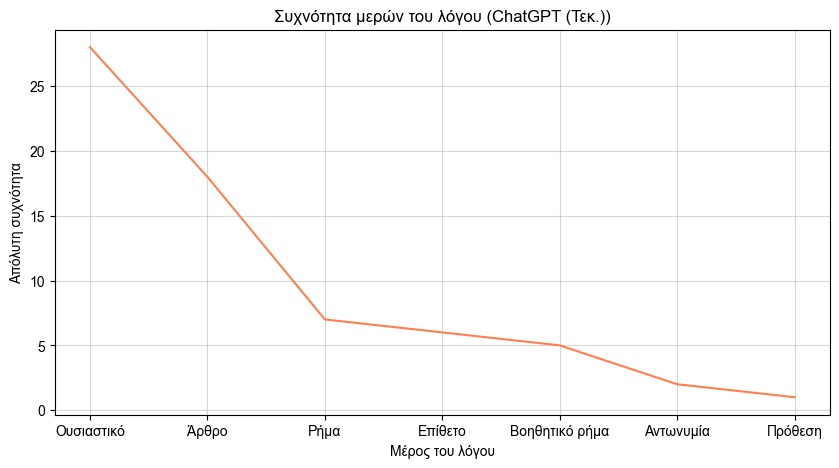

Μεταφραστής: DeepL


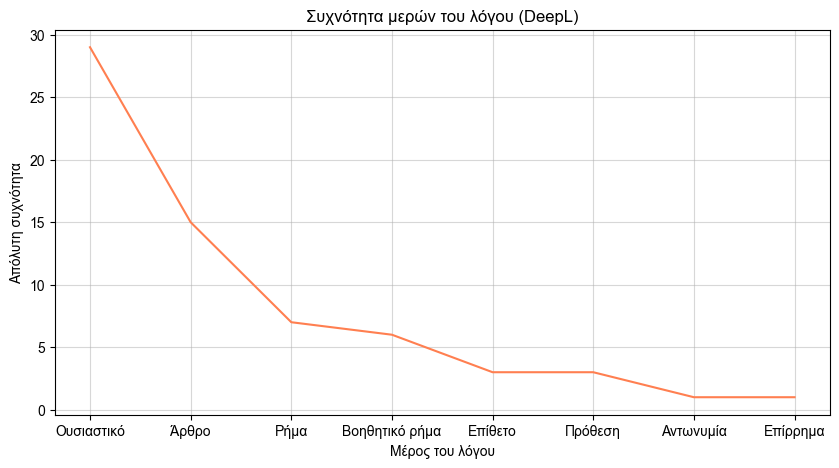

Μεταφραστής: Google


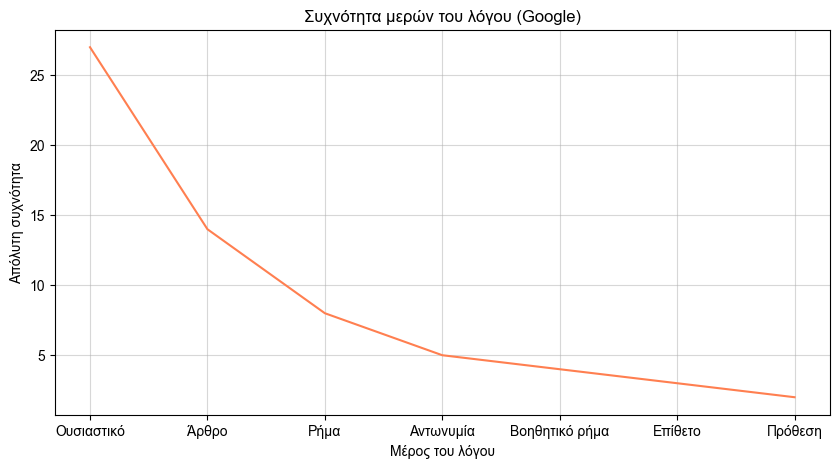

Μεταφραστής: Γώγος


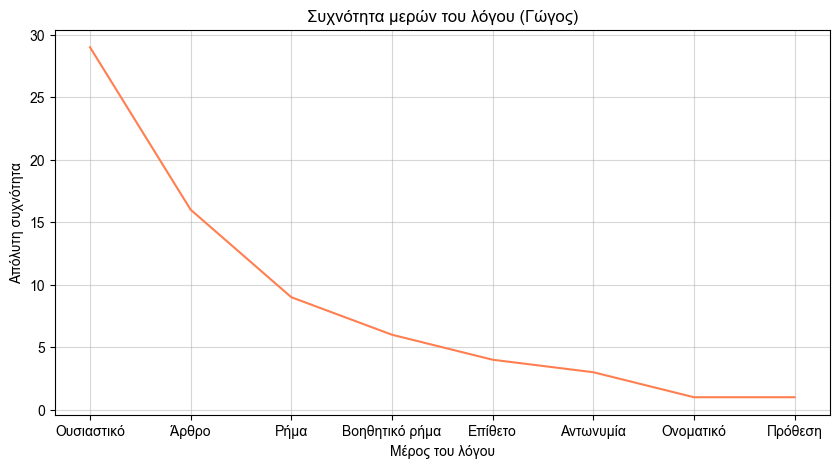

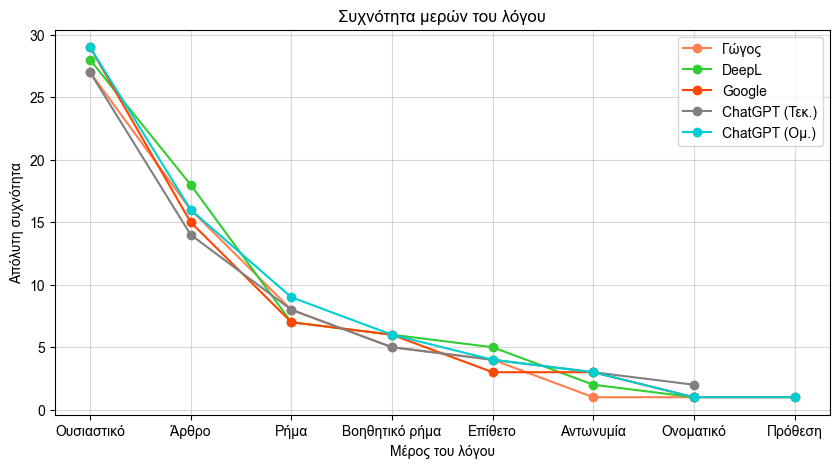

In [54]:
# plot the frequency of each morphological feature per translator
for translator, group in morph_df_.groupby('translator'):
    print('Μεταφραστής:', translator)
    vcs = group['POS'].map(MORPH_LOC.get).value_counts()
    fig, ax = plt.subplots(figsize=(10, 5))
    plot = vcs.plot.line(title=f'Συχνότητα μερών του λόγου ({translator})',
                         xlabel='Μέρος του λόγου', ylabel='Απόλυτη συχνότητα', 
                         rot=0, color=list(UPOS_COLORS.values())[1:], zorder=10)
    plot.grid(True, zorder=0, alpha=.5)
    # save_fig(fig, f"{translator.replace(' –', '_').replace(' Ομ._', '').replace(' Τεκ._', '')_line}", 
    #          path=f'translations/parts_of_speech/all', format='svg')
    plt.show();

# combine the lines into a single plot
fig, ax = plt.subplots(figsize=(10, 5))
for i, (translator, group) in enumerate(morph_df_.groupby('translator')):
    vcs = group['POS'].map(MORPH_LOC.get).value_counts()
    plot = vcs.plot.line(title=f'Συχνότητα μερών του λόγου',
                         xlabel='Μέρος του λόγου', ylabel='Απόλυτη συχνότητα', 
                         color=list(UPOS_COLORS.values())[(2*i+1):(4*i+2)],
                         marker='o', rot=0, zorder=10)
    plot.grid(True, zorder=0, alpha=.5)
    save_fig(fig, f"{translator.replace(' –', '_').replace(' Ομ._', '').replace(' Τεκ._', '')}_line", 
             path=f'translations/parts_of_speech/all', format='svg')
plt.legend(list(morph_df_['translator'].unique()))
plt.show();

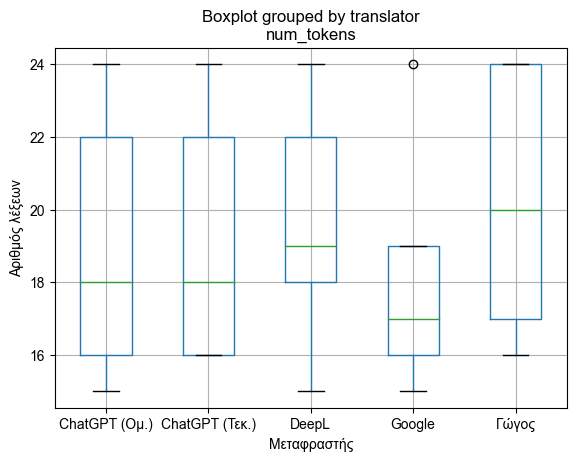

In [36]:
# make boxplots of the number of tokens per translator
analysis_df.boxplot(column='num_tokens', by='translator', xlabel='Μεταφραστής', ylabel='Αριθμός λέξεων')
plt.savefig('graphs/translations/num_tokens.svg', format='svg')